# Optically-dark short GRBs

**Caden Gobat**, The George Washington University

## Imports/loading/setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, astropy.units as u
from matplotlib import ticker

from astropy.io import votable, ascii
from astropy.coordinates import SkyCoord
from gdpyc.core import GasMap, DustMap
from scipy import interpolate, stats, optimize

from src.xrt import XRT_lightcurve, get_photonIndex, get_temporalIndex, get_columnDensity

from asymmetric_uncertainty import a_u, UncertaintyArray

#calc_code = importlib.import_module("legacy.Calculation Code.calc_beta_ox")
#graph_code = importlib.import_module("legacy.Graphing Code.Graphing_Beta_OX")
log_mean = lambda a, b : 10**np.mean((np.log10(a), np.log10(b)))
log_slope = lambda point1, point2 : np.log10(point2[1]/point1[1])/np.log10(point2[0]/point1[0])
Hz_per_keV = 241797944177033445

Main code has been moved to [`pipeline.ipynb`](./pipeline.ipynb). Running the cell below will perform the entire analysis and output the list of dark sGRBs.

In [3]:
error_B_ox  = True # whether to incorporate Δβₒₓ (due to temporal separation) in errors
restrictive = True # whether to use a permissive inequality cut (w.r.t. error bars) for determining darkness (<< vs. <)
max_dt      = 0.20 # maximum allowable temporal separation between optical and X-ray data points (%)

%run pipeline.ipynb

Finished xray.
Finished optical.
Finished Δβₒₓ.           
Using B_ox_w_err
211227A	 7
211106A	 1
211023B	 19
210919A	 2
210726A	 2
210725B	 3
210704A	 3
210410A	 6
210323A	 12
201006A	 5
200907B	 3
200826A	 1
200716C	 1
200522A	 9
200411A	 9
200219A	 2
191031D	 2
190719C	 7
190627A	 13
181123B	 4
180727A	 8
180618A	 14
180418A	 98
180402A	 2
180204A	 12
170827A	 2
170822A	 14
170728B	 34
170728A	 4
170127B	 4
161004A	 14
161001A	 1
160927A	 6
160821B	 12
160624A	 4
160601A	 2
160525B	 8
160411A	 8
160408A	 9
160303A	 1
151229A	 12
151127A	 4
150831A	 6
150424A	 107
150423A	 6
150301A	 5
150120A	 3
150101B	 4
141212A	 7
140930B	 9
140903A	 13
140622A	 10
140516A	 1
131004A	 38
130912A	 33
130822A	 2
130603B	 34
130515A	 2
121226A	 16
120804A	 18
120630A	 1
120521A	 7
120305A	 5
111222A	 2
111121A	 9
111117A	 17
111020A	 4
110402A	 10
110112B	 1
110112A	 7
110106A	 17
101219A	 5
100816A	 17
100702A	 2
100625A	 2
100213A	 3
100206A	 1
100117A	 1
091109B	 5
090621B	 1
090607	 1
090531B	 2

## $\LaTeX$ table formatting

In [47]:
round_scientific = lambda number, places : float(f"%.{places}e"%number)

sample_df = sGRBs[['GRB', 'TriggerNumber', 'BAT T90[sec]', 'Redshift', 'Beta_X', 'Beta_X_neg', 'Beta_X_pos', 'N_H (intrinsic)']].copy()
sample_df.loc[sample_df["Beta_X"].notna(),"B_x"] = [a_u(*row[['Beta_X', 'Beta_X_pos', 'Beta_X_neg']]) for i,row in sample_df.loc[sample_df["Beta_X"].notna(),:].iterrows()]
# sample_df.loc[sample_df["N_H (intrinsic)"].notna(),"N_H (intrinsic)"] = [a_u(entry) for entry in sample_df.loc[sample_df["N_H (intrinsic)"].notna(),"N_H (intrinsic)"]]
sample_df.drop(['Beta_X', 'Beta_X_pos', 'Beta_X_neg'], axis=1, inplace=True)
sample_df.rename(columns={"B_x":"Beta_X","BAT T90[sec]":"T90","TriggerNumber":"Trigger"},inplace=True)

for i,row in sample_df.iterrows():
    bx = row["Beta_X"]
    nh = row["N_H (intrinsic)"]
    if pd.notna(nh):
#         rounded_nh = (round_scientific(number,3) for number in nh.items())
#         rounded_nh = a_u(*rounded_nh)
        sample_df.loc[i,"N_H (intrinsic)"] = a_u(round(nh.value/1e21,3),
                                                 round(nh.plus/1e21,3),
                                                 round(nh.minus/1e21,3))
    if pd.notna(bx):
        rounded_bx = (round(number,2) for number in bx.items())
        rounded_bx = a_u(*rounded_bx)
        sample_df.loc[i,"Beta_X"] = rounded_bx
table_str = sample_df.to_latex(index=False, columns=["GRB","Trigger","T90","Redshift","Beta_X","N_H (intrinsic)"],na_rep='---')

In [48]:
for line in table_str.split("\n")[4:-3]:
    grb,trig,t90,z,beta_orig,n_h_orig = line.split("&")
    n_h_orig = n_h_orig[:-2]
    if beta_orig.strip() != "---":
        beta = beta_orig
        beta = beta.replace(" (+","^{+")
        beta = beta.replace(", -","}_{-")
        beta = beta.replace(")","}")
        beta = beta.replace("±",r"\pm")
        table_str = table_str.replace(beta_orig," $"+beta.strip()+"$ ")
    if n_h_orig.strip() != "---":
        n_h = n_h_orig
        n_h = n_h.replace(" (+","^{+")
        n_h = n_h.replace(", -","}_{-")
        n_h = n_h.replace(")","}")
        if "±" not in n_h:
            pass
#             print(n_h)
#             val,err = n_h.split()
#             n_h = "("+val+")"+err
        else:
            n_h = n_h.replace("±",r"\pm")
        table_str = table_str.replace(n_h_orig," $"+n_h.strip()+"$ ")
# table_str = table_str.replace("e+19",r"\times10^{19}")
# table_str = table_str.replace("e+20",r"\times10^{20}")
# table_str = table_str.replace("e+21",r"\times10^{21}")
# table_str = table_str.replace("e+22",r"\times10^{22}")
print(table_str)

\begin{tabular}{llllll}
\toprule
    GRB &                    Trigger &        T90 &              Redshift &               Beta\_X &        N\_H (intrinsic) \\
\midrule
211227A &                    1091101 &      83.79 &                   --- & $2.0^{+0.7}_{-0.6}$ & $2.9 ^{+1.8}_{-1.5}$ \\
211221A &                    1090472 &     671.67 &                   --- & $0.59^{+0.31}_{-0.29}$ & $9.0 ^{+4.0}_{-3.0}$ \\
211207A &                    1088376 &       3.73 &                 2.272 & $1.02^{+0.25}_{-0.24}$ & $15.7 ^{+11.5}_{-9.6}$ \\
211106A &                  BAT/GUANO &       1.75 &                   --- & $0.1^{+1.06}_{-0.42}$ & $0.0 ^{+3.43}_{-0.0}$ \\
211023B &                    1080859 &       1.30 &                 0.862 & $1.12^{+0.23}_{-0.21}$ & $0.9 ^{+0.6}_{-0.5}$ \\
210919A &                    1073893 &       0.16 &                   --- & $1.1^{+3.3}_{-1.1}$ & $1.1 ^{+24.7}_{-1.1}$ \\
210726A &                    1061687 &       0.39 &                   --- & $1.2^{+0

In [ ]:
xtable = xrt_data[['GRB', 'Time', 'Tpos', 'Tneg', 'SpecFlux']].round(2).copy()
xtable["tx"] = [a_u(*row[["Time","Tpos","Tneg"]]) for i,row in xtable.iterrows()]
xtable["SpecFlux"] *= 1e6
xtable["Fx"] = [a_u(round(row["SpecFlux"].value,3),
                                      round(row["SpecFlux"].plus,3),
                                      round(row["SpecFlux"].minus,3)) for i,row in xtable.iterrows()]
print(xtable[["GRB","tx","Fx"]].to_latex(index=False).replace(" (","^{").replace(", ","}_{").replace(")","}$").replace("& ","& $"))

In [7]:
A1 = pd.DataFrame(np.array([[grb, float(sGRBs.loc[sGRBs["GRB"]==grb, "T90"]),
                             sum(xrt_data["GRB"]==grb),sum(all_optical["GRB"]==grb),
                             sum(results["GRB"]==grb),sum(dark_matches["GRB"]==grb)] for grb in sGRBs["GRB"]]),
                  columns=["GRB", "T90 [sec]", "X-ray", "Optical", "Temporal matches", "Dark"])
A1.to_csv("./products/TableA1.csv", index=False)
print(A1.to_latex(index=False))

\begin{tabular}{lllllll}
 & GRB & T90 [sec] & X-ray & Optical & Temporal matches & Dark \\
0 & 211227A & 83.792 & 101 & 22 & 86 & 83 \\
1 & 211106A & 1.75 & 4 & 13 & 1 & 0 \\
2 & 211023B & 1.296 & 19 & 39 & 32 & 2 \\
3 & 210919A & 0.164 & 2 & 35 & 2 & 0 \\
4 & 210726A & 0.388 & 15 & 5 & 2 & 1 \\
5 & 210725B & 418.96 & 20 & 5 & 5 & 4 \\
6 & 210704A & nan & 5 & 20 & 4 & 0 \\
7 & 210618A & 2.16 & 0 & 0 & 0 & 0 \\
8 & 210413B & 1.088 & 0 & 4 & 0 & 0 \\
9 & 210410A & 52.876 & 66 & 16 & 14 & 0 \\
10 & 210323A & 1.124 & 30 & 18 & 30 & 3 \\
11 & 210217A & 4.224 & 17 & 0 & 0 & 0 \\
12 & 210119A & 0.064 & 0 & 6 & 0 & 0 \\
13 & 201221D & 0.16 & 2 & 20 & 0 & 0 \\
14 & 201015A & 9.776 & 9 & 0 & 0 & 0 \\
15 & 201006A & 0.492 & 6 & 17 & 5 & 0 \\
16 & 200917A & 19.392 & 29 & 0 & 0 & 0 \\
17 & 200907B & 0.832 & 8 & 9 & 4 & 0 \\
18 & 200826A & nan & 7 & 4 & 1 & 0 \\
19 & 200729A & 122.0 & 74 & 0 & 0 & 0 \\
20 & 200716C & 86.572 & 363 & 15 & 3 & 0 \\
21 & 200623A & nan & 0 & 1 & 0 & 0 \\
22 & 200522A & 0

## *Swift*-XRT lightcurve/spectrum demo

In [24]:
burst = "050603"
fluxdata = XRT_lightcurve(burst)
Gamma,mode = get_photonIndex(burst)
NH,mode = get_columnDensity(burst)

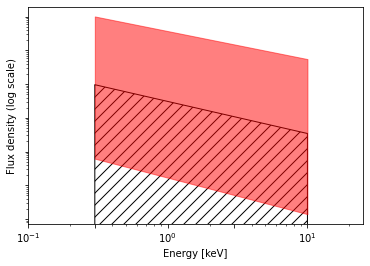

In [25]:
E_range = np.linspace(0.3,10,100)
spectrum = (E_range / 4.135667696e-18)**-(Gamma.value-1)
spec1 = (E_range / 4.135667696e-18)**-(Gamma.maximum-1)
spec2 = (E_range / 4.135667696e-18)**-(Gamma.minimum-1)

plt.fill_between(E_range,[0]*len(E_range),spectrum,fc="none",ec="k",hatch="//")
plt.fill_between(E_range,spec1,spec2,alpha=0.5,color="r")
plt.xlim(1e-1,25)
#plt.ylim(1e-16,1e-4)
plt.yscale("log")
plt.xscale("log")
plt.gca().set_xticks([0.1,0.3,1,3,10])
#plt.gca().set_xticklabels([0.1,0.3,1,3,10])
#plt.gca().set_yticks([])
plt.gca().set_yticklabels([])
plt.xlabel("Energy [keV]")
plt.ylabel("Flux density (log scale)")
plt.show()

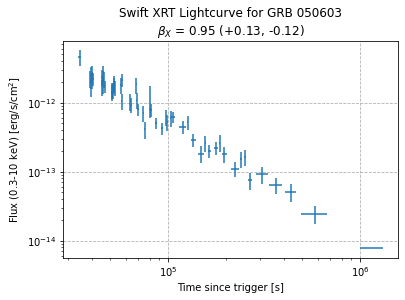

In [26]:
plt.errorbar(fluxdata.Time,fluxdata.Flux,xerr=np.array(fluxdata.Tneg,fluxdata.Tpos).T,
             yerr=np.array(fluxdata.Fluxneg,fluxdata.Fluxpos).T,linestyle="",capthick=0)
plt.xscale("log")
plt.yscale("log")
plt.title("Swift XRT Lightcurve for GRB %s\n$\\beta_X$ = %s" % (burst,Gamma-1))
plt.xlabel("Time since trigger [s]")
plt.ylabel("Flux (0.3-10 keV) [erg/s/cm$^2$]")
plt.grid(linestyle="--")

plt.show()

## Filter transmission calculations

c:\users\caden gobat\appdata\local\programs\python\python38\lib\site-packages\pandas\io\parsers.py:765: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return read_csv(**locals())


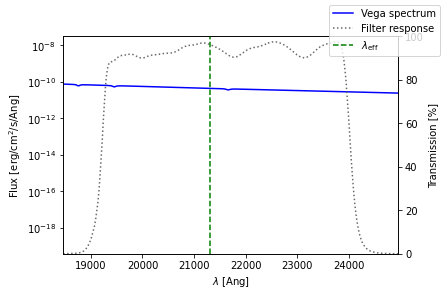

21303.690943444715

In [4]:
from src.fluxtools import effective_wavelength

# I_filter = pd.read_table("http://www2.lowell.edu/rsch/LMI/I.txt",header=None)
# I_filter.columns = ["Wavelength","Transmission"]
# I_filter["Wavelength"] *= 10
# rprime_filter = pd.read_table("http://www2.lowell.edu/rsch/LMI/r-band.txt").drop(columns=["T%"],axis=0)
# rprime_filter.columns = ["Wavelength","Transmission"]
# rprime_filter["Wavelength"] *= 10
MOSFIRE_J = pd.read_table("https://www2.keck.hawaii.edu/inst/mosfire/data/filter/mosfire_J.txt",delimiter="   ").iloc[:,:2]
MOSFIRE_J = MOSFIRE_J.rename(columns=dict(zip(MOSFIRE_J.columns,["Wavelength","Transmission"]))).apply(pd.to_numeric,errors="coerce").dropna()
MOSFIRE_J["Wavelength"] *= 10000
MOSFIRE_J["Transmission"] *= 100

MOSFIRE_K = pd.read_table("https://www2.keck.hawaii.edu/inst/mosfire/data/filter/mosfire_K.txt",delimiter="   ",engine='python').iloc[:,:2]
MOSFIRE_K = MOSFIRE_K.rename(columns=dict(zip(MOSFIRE_K.columns,["Wavelength","Transmission"]))).apply(pd.to_numeric,errors="coerce").dropna()
MOSFIRE_K["Wavelength"] *= 10000
MOSFIRE_K["Transmission"] *= 100

# REMIR_H = pd.read_csv("./data/REM/H.csv",header=None,names=["Wavelength","Transmission"])
# REMIR_H.sort_values(by="Wavelength",inplace=True)
# REMIR_H["Wavelength"] *= 10
# REMIR_r = pd.read_csv("./data/REM/r'.csv")
# REMIR_r.sort_values(by="Wavelength",inplace=True)
# REMIR_r["Wavelength"] *= 10

# LDSS3_i = pd.read_table("http://www.lco.cl/wp-content/uploads/telescopes/magellan/instruments/ldss3/filters-data/i01.txt",
#                         header=None,names=["Wavelength","Transmission"])
# LDSS3_r = pd.read_table("http://www.lco.cl/wp-content/uploads/telescopes/magellan/instruments/ldss3/filters-data/r01.txt",
#                         header=None,names=["Wavelength","Transmission"])
# LDSS3_r["Wavelength"] *= 10 # nm to Ang

# IMACS_r_below = pd.read_csv("./data/Magellan/IMACS_r.csv",header=None)
# IMACS_r_below.columns = ["Wavelength","Transmission"]
# IMACS_r_below = IMACS_r_below[IMACS_r_below["Wavelength"]<600].copy()
# IMACS_r_below.sort_values(by="Wavelength",inplace=True)
# IMACS_r_below.drop_duplicates(subset=["Wavelength"],inplace=True)
# IMACS_r_above = pd.read_table("http://www.lco.cl/wp-content/uploads/telescopes/magellan/instruments/imacs/imacs-filters/sloan_r_red01.txt",
#                               delimiter="\t",names=["Wavelength","Transmission"])
# IMACS_r = IMACS_r_below.append(IMACS_r_above,ignore_index=True)
# IMACS_r["Wavelength"] *= 10

effective_wavelength(MOSFIRE_K,show_plot=True)

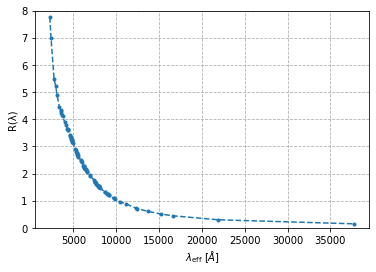

In [72]:
RbTable = pd.read_csv("./data/Rb.csv") # Table 6 from Schlafly & Finkbeiner (2011)
Rb = interpolate.interp1d(RbTable["lambda_eff"],RbTable["R_b"],fill_value="extrapolate") # function that takes a wavelength [Ang] and returns the corresponding R_b value

RbTable.drop([37,55,61,73],axis=0,inplace=True) # smoothing
RbTable.sort_values(by="lambda_eff",inplace=True) # sort in order of wavelength: UV -> IR
plt.plot(RbTable["lambda_eff"], RbTable["R_b"], ".--")
plt.xlabel("$\lambda_\mathrm{eff}$ [$\AA$]")
plt.ylabel("R(λ)")
plt.ylim(0,8)
plt.grid(linestyle="--")
# plt.savefig("./products/RbTable.png",bbox_inches="tight",dpi=300,)

## Plot dark GRBs' lightcurves

0 1 3


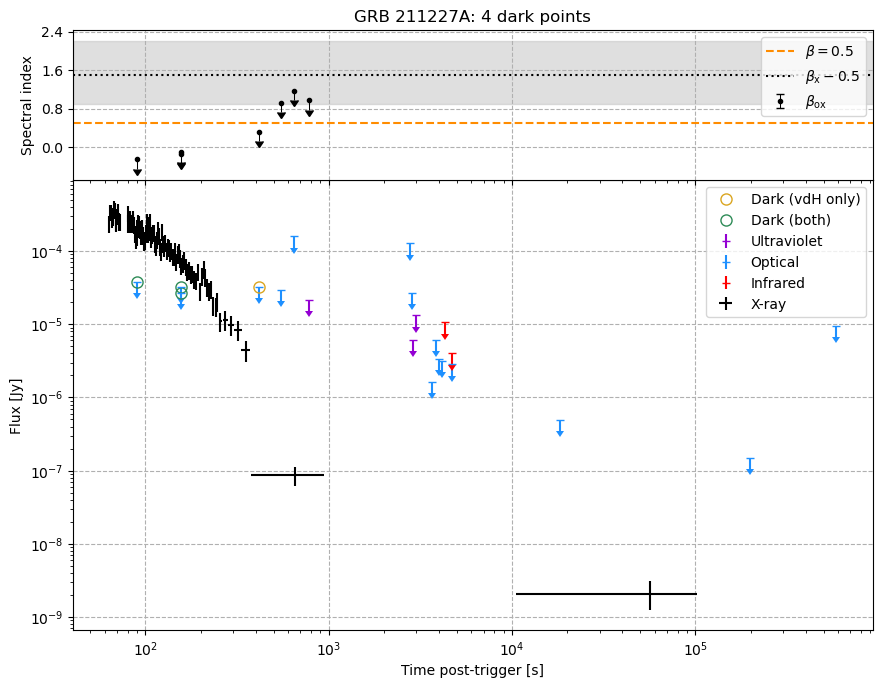

GRB     t_o       dt%  \
14  211227A   90.14  0.002865   
49  211227A  156.00  0.007854   
71  211227A  157.00  0.001495   
82  211227A  419.00  0.191221   
83  211227A  551.50  0.162239   
84  211227A  646.00  0.018687   
85  211227A  782.00  0.187905   

                                           B_ox_w_err               B_x     α  \
14  -0.25099302608658447 (+0.049333933712908624, -...  2.0 (+0.7, -0.6)  1.19   
49  -0.13267376352220342 (+0.045001752696141234, -...  2.0 (+0.7, -0.6)  2.30   
71  -0.10341966507580574 (+0.04297943211925725, -inf)  2.0 (+0.7, -0.6)  2.30   
82    0.3197416906818682 (+0.40491619429722603, -inf)  2.0 (+0.7, -0.6)  5.26   
83    0.9267124667895975 (+0.36723677405324184, -inf)  2.0 (+0.7, -0.6)  5.26   
84    1.1724417170377992 (+0.16337369690637318, -inf)  2.0 (+0.7, -0.6)  5.26   
85      0.9735765292430156 (+0.421222070169985, -inf)  2.0 (+0.7, -0.6)  5.26   

   Jak_dark vdH_dark  
14     True     True  
49     True     True  
71     True     True  
82    False     True  
83    False    False  
84    False    False  
85    False    False

0 0 1


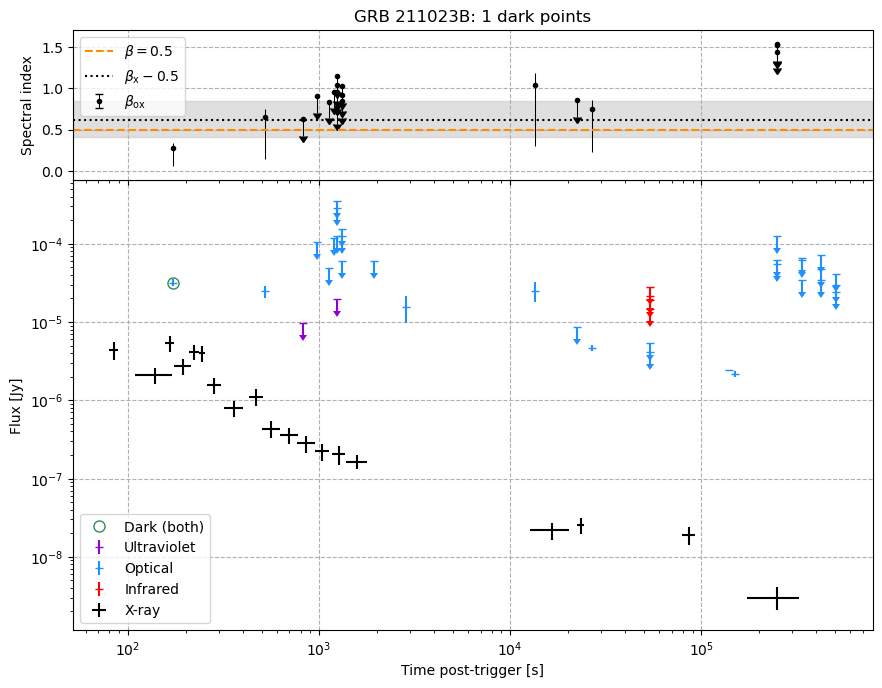

GRB         t_o       dt%  \
87   211023B     172.500  0.043595   
90   211023B     522.000  0.073808   
92   211023B     827.000  0.036906   
94   211023B     973.728  0.063206   
95   211023B    1122.500  0.079923   
98   211023B    1196.500  0.060967   
100  211023B    1241.000  0.026043   
102  211023B    1241.000  0.026043   
104  211023B    1241.000  0.026043   
106  211023B    1246.500  0.021726   
107  211023B    1324.000  0.039097   
109  211023B    1324.000  0.039097   
111  211023B    1324.000  0.039097   
113  211023B   13489.632  0.181126   
114  211023B   22320.000  0.047784   
115  211023B   26706.240  0.139341   
116  211023B  250560.000  0.005205   
117  211023B  250560.000  0.005205   
118  211023B  250560.000  0.005205   

                                            B_ox_w_err                  B_x  \
87   0.28112896338672066 (+0.05707456511353485, -0....  1.12 (+0.23, -0.21)   
90   0.6517958876840213 (+0.10368705765060536, -0.5...  1.12 (+0.23, -0.21)   
92      0.6255741588078932 (+0.1013525454331819, -inf)  1.12 (+0.23, -0.21)   
94      0.905455071978658 (+0.11827840576111703, -inf)  1.12 (+0.23, -0.21)   
95     0.8403814558860491 (+0.11889259599102356, -inf)  1.12 (+0.23, -0.21)   
98     0.9592597311819141 (+0.12840957072031275, -inf)  1.12 (+0.23, -0.21)   
100    1.1521672336999942 (+0.15285699684845014, -inf)  1.12 (+0.23, -0.21)   
102     0.952100804948431 (+0.12333930033168881, -inf)  1.12 (+0.23, -0.21)   
104    1.0428944809053946 (+0.13017071264080116, -inf)  1.12 (+0.23, -0.21)   
106    0.7699768186392831 (+0.11656485289743572, -inf)  1.12 (+0.23, -0.21)   
107    1.0242661398596438 (+0.13773977475886834, -inf)  1.12 (+0.23, -0.21)   
109    0.8430138668299184 (+0.11142608609221115, -inf)  1.12 (+0.23, -0.21)   
111    0.9236026173670062 (+0.11730549637201867, -inf)  1.12 (+0.23, -0.21)   
113  1.0364935017278023 (+0.1536104669224118, -0.73...  1.12 (+0.23, -0.21)   
114    0.8593294221197547 (+0.11134379131204827, -inf)  1.12 (+0.23, -0.21)   
115  0.7514351786229936 (+0.11001576298017463, -0.5...  1.12 (+0.23, -0.21)   
116     1.531068361917801 (+0.20034929907487087, -inf)  1.12 (+0.23, -0.21)   
117     1.4421500264258627 (+0.1804841857234215, -inf)  1.12 (+0.23, -0.21)   
118    1.5193600668734892 (+0.18441490709855024, -inf)  1.12 (+0.23, -0.21)   

         α Jak_dark vdH_dark  
87   0.948     True     True  
90   0.948    False    False  
92   0.948    False    False  
94   0.948    False    False  
95   0.948    False    False  
98   0.948    False    False  
100  0.948    False    False  
102  0.948    False    False  
104  0.948    False    False  
106  0.948    False    False  
107  0.948    False    False  
109  0.948    False    False  
111  0.948    False    False  
113  0.948    False    False  
114  0.948    False    False  
115  0.948    False    False  
116  0.948    False    False  
117  0.948    False    False  
118  0.948    False    False

no Ultraviolet for GRB 210726A
no Infrared for GRB 210726A
1 0 0


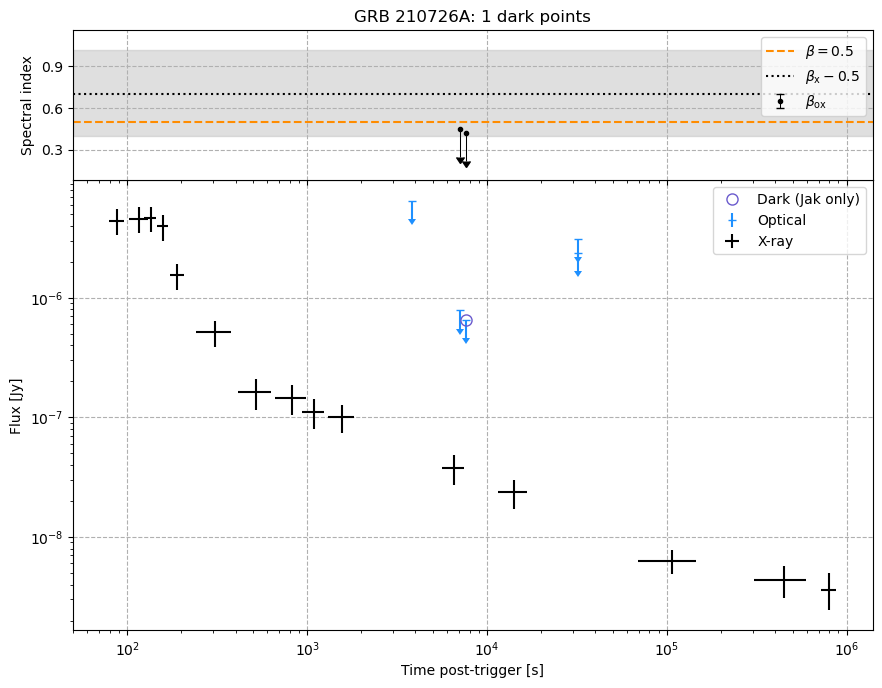

GRB     t_o       dt%  \
121  210726A  7041.6  0.076535   
122  210726A  7650.0  0.169548   

                                           B_ox_w_err                B_x  \
121   0.4506156575831122 (+0.07110941463007812, -inf)  1.2 (+0.32, -0.3)   
122  0.42114169739227614 (+0.07644274617931837, -inf)  1.2 (+0.32, -0.3)   

        α Jak_dark vdH_dark  
121  0.58    False    False  
122  0.58     True    False

no Infrared for GRB 210725B
2 0 0


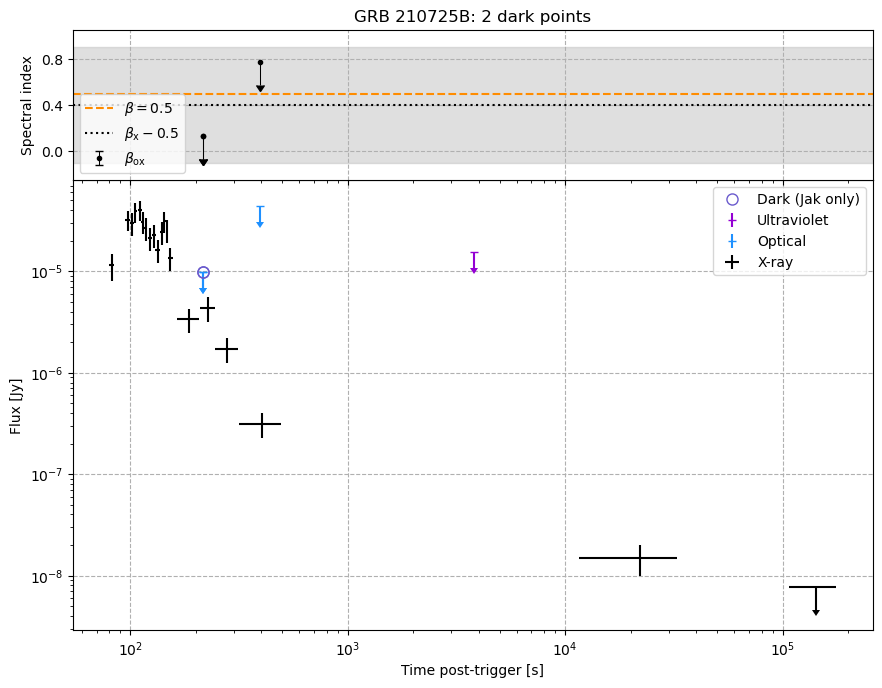

GRB    t_o       dt%  \
124  210725B  216.5  0.048431   
126  210725B  216.5  0.048431   
127  210725B  393.0  0.028834   

                                           B_ox_w_err        B_x     α  \
124  0.13020871804521683 (+0.06595051691675644, -inf)  0.9 ± 0.5  2.22   
126  0.13020871804521683 (+0.06595051691675644, -inf)  0.9 ± 0.5  2.22   
127   0.7725649669525019 (+0.11153803623101657, -inf)  0.9 ± 0.5  2.22   

    Jak_dark vdH_dark  
124     True    False  
126     True    False  
127    False    False

no Infrared for GRB 210323A
1 0 0


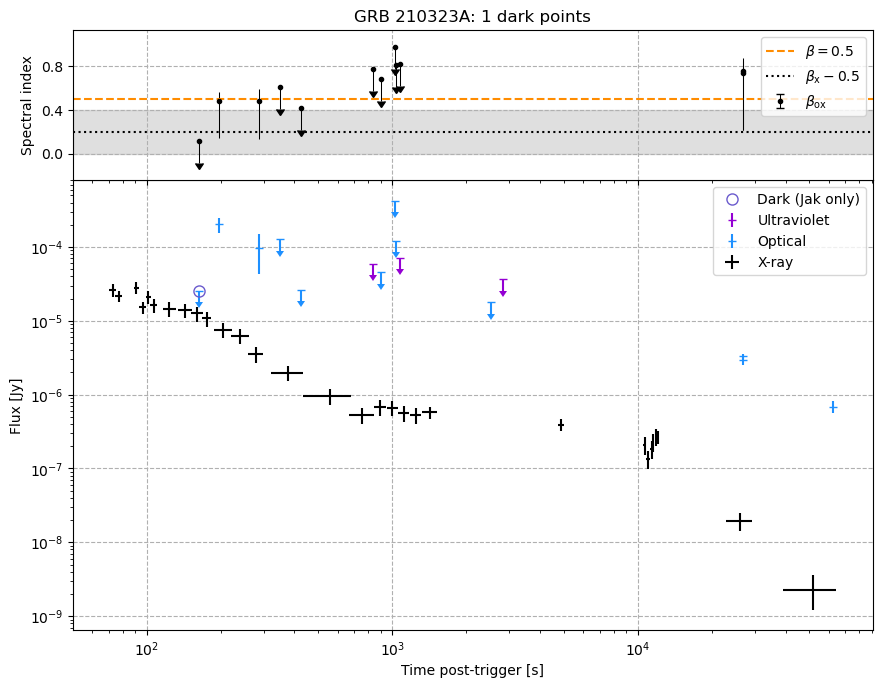

GRB        t_o       dt%  \
147  210323A    164.000  0.022176   
150  210323A    197.856  0.037024   
153  210323A    287.712  0.032951   
154  210323A    348.192  0.078930   
155  210323A    427.000  0.129540   
157  210323A    838.000  0.060724   
160  210323A    899.500  0.008208   
164  210323A   1027.500  0.027058   
168  210323A   1040.000  0.039553   
172  210323A   1077.000  0.033029   
174  210323A  26820.000  0.031177   
175  210323A  26939.520  0.035773   

                                            B_ox_w_err        B_x      α  \
147   0.11224670473253857 (+0.04278139383706613, -inf)  0.7 ± 0.2  1.600   
150  0.48146308092807644 (+0.07892234633808277, -0....  0.7 ± 0.2  1.600   
153  0.48413314165013294 (+0.10816552278366268, -0....  0.7 ± 0.2  1.600   
154    0.6096691043170209 (+0.09695544285472978, -inf)  0.7 ± 0.2  1.600   
155    0.4168772313152361 (+0.10816280268550332, -inf)  0.7 ± 0.2  1.600   
157    0.7770398035669612 (+0.11960739073850142, -inf)  0.7 ± 0.2  0.452   
160    0.6782290321733282 (+0.09815391355477487, -inf)  0.7 ± 0.2  0.452   
164    0.9749658384217068 (+0.12678590989086103, -inf)  0.7 ± 0.2  0.452   
168     0.8118359094467696 (+0.1112225131543405, -inf)  0.7 ± 0.2  0.452   
172    0.8188118699194027 (+0.12104775098046179, -inf)  0.7 ± 0.2  0.452   
174  0.7593483832591326 (+0.11007418307821619, -0.5...  0.7 ± 0.2  3.130   
175  0.7378449358856282 (+0.11113614352790967, -0.5...  0.7 ± 0.2  3.130   

    Jak_dark vdH_dark  
147     True    False  
150    False    False  
153    False    False  
154    False    False  
155    False    False  
157    False    False  
160    False    False  
164    False    False  
168    False    False  
172    False    False  
174    False    False  
175    False    False

no Infrared for GRB 200411A
1 0 0


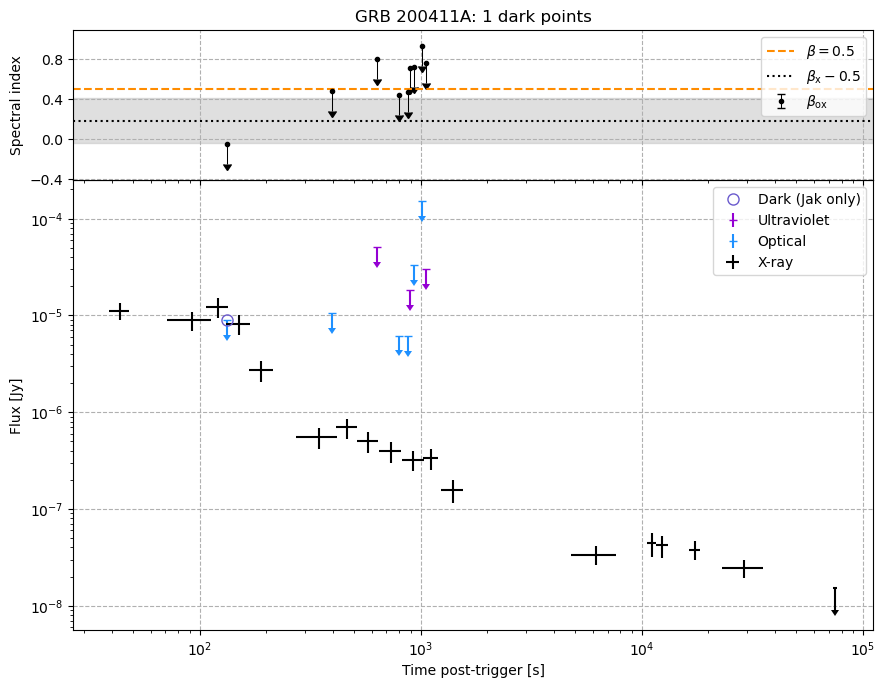

GRB     t_o       dt%  \
200  200411A   133.0  0.102198   
202  200411A   395.0  0.142021   
204  200411A   636.0  0.105920   
206  200411A   799.0  0.092668   
208  200411A   880.0  0.047658   
209  200411A   898.0  0.028178   
211  200411A   934.0  0.010781   
213  200411A  1009.0  0.091946   
216  200411A  1058.5  0.047526   

                                            B_ox_w_err                  B_x  \
200  -0.04851978052332558 (+0.05688337699006908, -inf)  0.68 (+0.23, -0.22)   
202    0.4783689882776384 (+0.09487235881232385, -inf)  0.68 (+0.23, -0.22)   
204     0.8042328731734381 (+0.1306512312686606, -inf)  0.68 (+0.23, -0.22)   
206    0.4373515063480147 (+0.07913264777404969, -inf)  0.68 (+0.23, -0.22)   
208   0.47447759588625593 (+0.07670545605582574, -inf)  0.68 (+0.23, -0.22)   
209    0.7092132768244779 (+0.11208122627933255, -inf)  0.68 (+0.23, -0.22)   
211     0.7227931242105741 (+0.1003803999823947, -inf)  0.68 (+0.23, -0.22)   
213    0.9299491714944917 (+0.12745818617667767, -inf)  0.68 (+0.23, -0.22)   
216    0.7609495275141429 (+0.11535404995967484, -inf)  0.68 (+0.23, -0.22)   

        α Jak_dark vdH_dark  
200  1.02     True    False  
202  1.02    False    False  
204  1.02    False    False  
206  1.02    False    False  
208  1.02    False    False  
209  1.02    False    False  
211  1.02    False    False  
213  1.02    False    False  
216  1.02    False    False

no Infrared for GRB 200219A
0 0 1


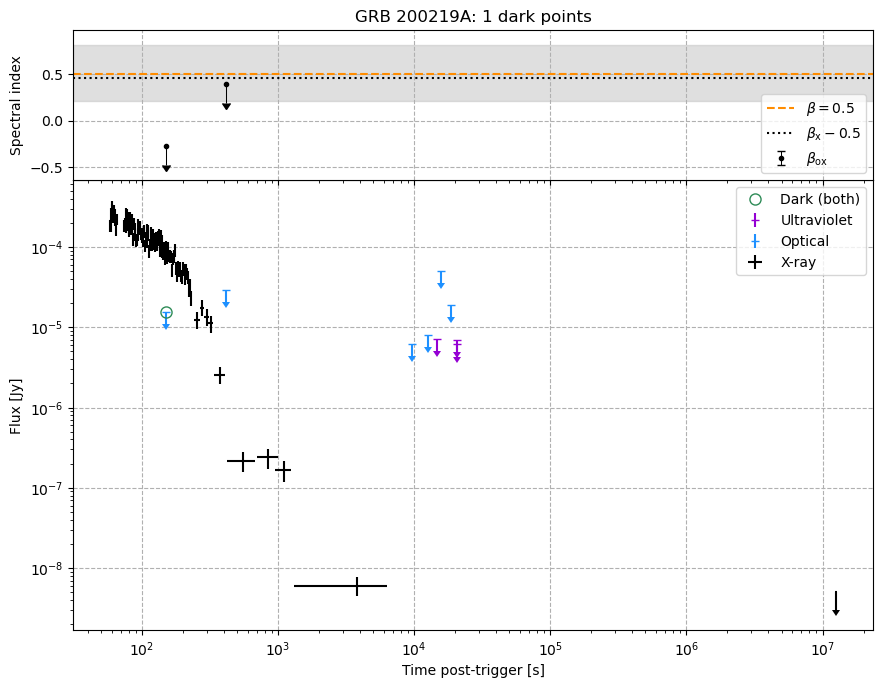

GRB    t_o       dt%  \
232  200219A  150.0  0.004870   
249  200219A  412.0  0.106046   

                                           B_ox_w_err                  B_x  \
232  -0.2738795394973301 (+0.04551266355059989, -inf)  0.96 (+0.35, -0.25)   
249    0.3930623206621587 (+0.2363715253434425, -inf)  0.96 (+0.35, -0.25)   

        α Jak_dark vdH_dark  
232  2.05     True     True  
249  5.19    False    False

1 0 0


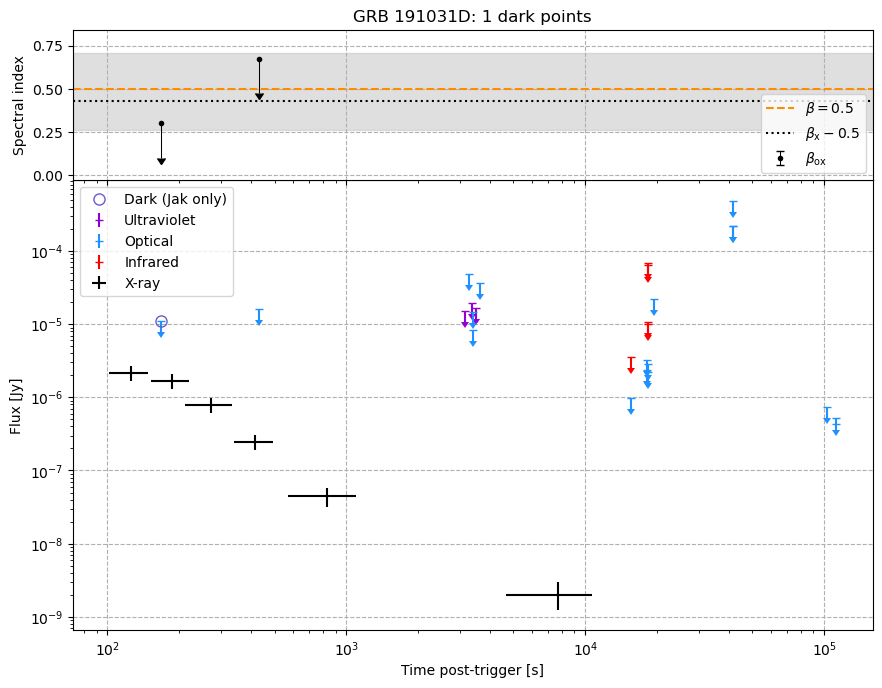

GRB    t_o       dt%  \
250  191031D  167.5  0.099559   
251  191031D  430.5  0.036059   

                                          B_ox_w_err                  B_x  \
250  0.3013995792493801 (+0.09686586908982647, -inf)  0.93 (+0.28, -0.17)   
251  0.6746782734039395 (+0.10202858622274029, -inf)  0.93 (+0.28, -0.17)   

        α Jak_dark vdH_dark  
250  1.95     True    False  
251  1.95    False    False

no Infrared for GRB 190719C
4 0 1


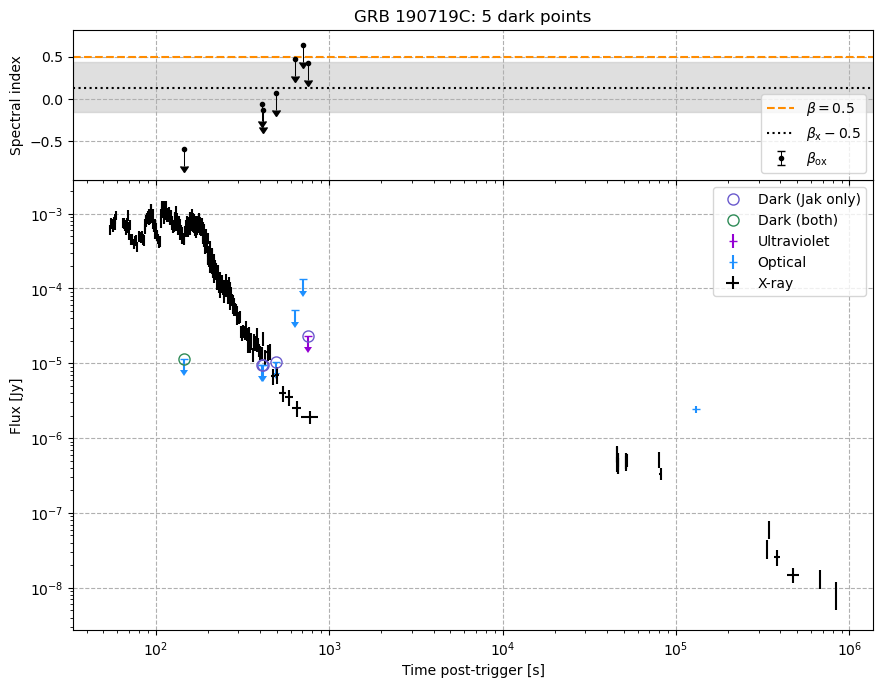

GRB    t_o       dt%  \
277  190719C  146.0  0.000404   
340  190719C  408.0  0.001813   
360  190719C  413.5  0.000571   
371  190719C  494.5  0.018019   
376  190719C  635.0  0.023853   
379  190719C  710.0  0.079953   
381  190719C  759.0  0.016457   

                                            B_ox_w_err                 B_x  \
277   -0.5889694249784356 (+0.08118119720248067, -inf)  0.63 (+0.3, -0.28)   
340  -0.05661184230678618 (+0.03480549045206605, -inf)  0.63 (+0.3, -0.28)   
360  -0.12907305411767916 (+0.03672237773612865, -inf)  0.63 (+0.3, -0.28)   
371   0.06343831813919938 (+0.04109125428086391, -inf)  0.63 (+0.3, -0.28)   
376    0.47189679713636695 (+0.0721816717296729, -inf)  0.63 (+0.3, -0.28)   
379    0.6405047267121906 (+0.09135601915920856, -inf)  0.63 (+0.3, -0.28)   
381    0.42094216852109856 (+0.0675042707551657, -inf)  0.63 (+0.3, -0.28)   

       α Jak_dark vdH_dark  
277  1.0     True     True  
340  1.0     True    False  
360  1.0     True    False  
371  1.0     True    False  
376  1.0    False    False  
379  1.0    False    False  
381  1.0     True    False

1 0 0


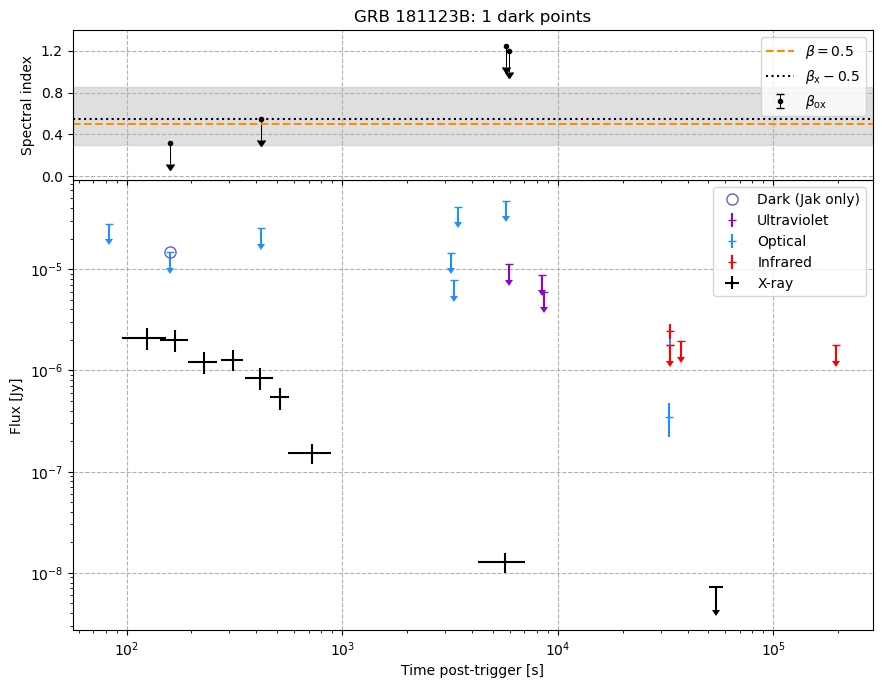

GRB     t_o       dt%  \
433  181123B   158.5  0.056227   
434  181123B   421.0  0.014967   
436  181123B  5774.0  0.017439   
437  181123B  5917.0  0.042637   

                                           B_ox_w_err                 B_x  \
433  0.31724610479428333 (+0.06562468296156637, -inf)  1.05 (+0.3, -0.25)   
434   0.5489210873989546 (+0.08340075224975443, -inf)  1.05 (+0.3, -0.25)   
436   1.2412891991341262 (+0.15884182215870998, -inf)  1.05 (+0.3, -0.25)   
437   1.1960044352612713 (+0.18049580276881366, -inf)  1.05 (+0.3, -0.25)   

        α Jak_dark vdH_dark  
433  1.41     True    False  
434  1.41    False    False  
436  1.41    False    False  
437  1.41    False    False

no Infrared for GRB 180727A
1 0 0


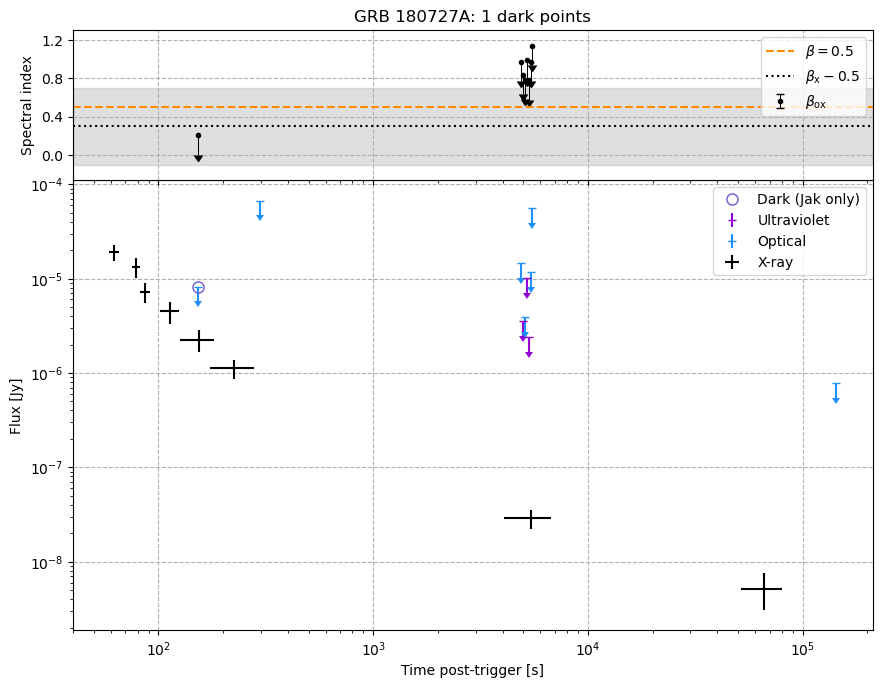

GRB     t_o       dt%  \
438  180727A   152.0  0.011286   
439  180727A  4892.5  0.094739   
440  180727A  4995.0  0.075773   
441  180727A  5097.5  0.056808   
442  180727A  5201.0  0.037657   
443  180727A  5303.5  0.018692   
444  180727A  5405.0  0.000089   
445  180727A  5501.0  0.017852   

                                           B_ox_w_err        B_x     α  \
438  0.20493517918355417 (+0.04999241805790475, -inf)  0.8 ± 0.4  1.38   
439   0.9705350869930872 (+0.14089705850990228, -inf)  0.8 ± 0.4  1.38   
440    0.8357851707828052 (+0.1337817749268779, -inf)  0.8 ± 0.4  1.38   
441   0.7797222565865061 (+0.11337834093214914, -inf)  0.8 ± 0.4  1.38   
442    0.9876889710985113 (+0.1446214718752361, -inf)  0.8 ± 0.4  1.38   
443   0.7780083241285315 (+0.12059979463992108, -inf)  0.8 ± 0.4  1.38   
444   0.9683910078866975 (+0.13417740367028747, -inf)  0.8 ± 0.4  1.38   
445   1.1417056516989406 (+0.14679112636914804, -inf)  0.8 ± 0.4  1.38   

    Jak_dark vdH_dark  
438     True    False  
439    False    False  
440    False    False  
441    False    False  
442    False    False  
443    False    False  
444    False    False  
445    False    False

no Infrared for GRB 180618A
0 0 1


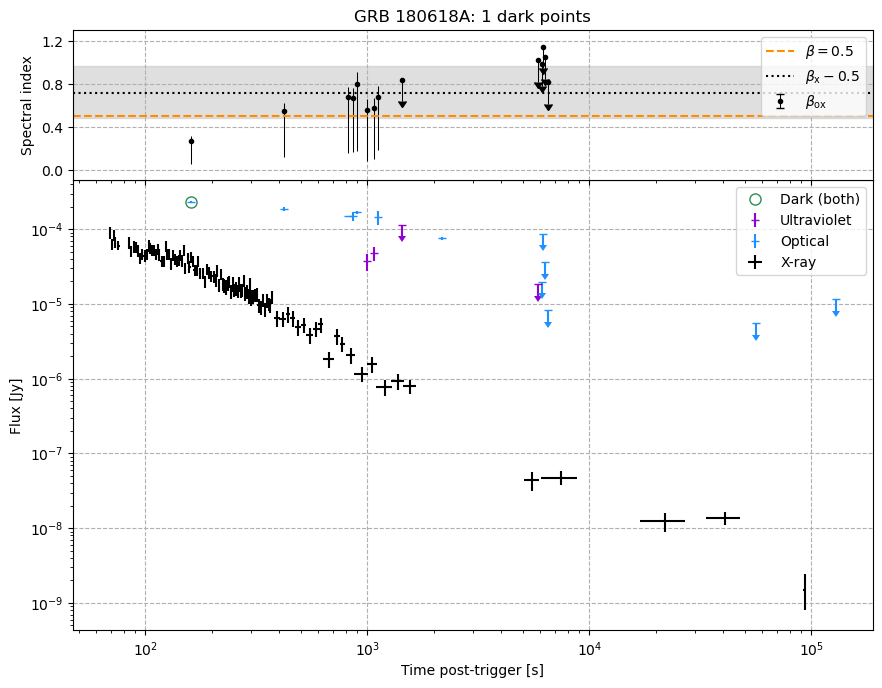

GRB     t_o       dt%  \
455  180618A   161.0  0.001487   
470  180618A   423.0  0.016343   
477  180618A   815.0  0.031596   
481  180618A   864.0  0.026627   
486  180618A   897.5  0.046156   
490  180618A  1001.0  0.048888   
493  180618A  1074.0  0.020474   
496  180618A  1112.0  0.056580   
499  180618A  1437.5  0.050929   
501  180618A  5882.5  0.071921   
502  180618A  6087.5  0.109277   
504  180618A  6190.0  0.127955   
506  180618A  6292.5  0.146632   
509  180618A  6497.5  0.124063   

                                            B_ox_w_err                  B_x  \
455  0.2701817734707163 (+0.04474859606087953, -0.2...  1.22 (+0.25, -0.23)   
470  0.5462199361034078 (+0.0818627937857624, -0.42...  1.22 (+0.25, -0.23)   
477  0.677317056166536 (+0.09773780698132033, -0.51...  1.22 (+0.25, -0.23)   
481  0.6674828969336349 (+0.09729216604542491, -0.4...  1.22 (+0.25, -0.23)   
486  0.800724408534892 (+0.11536874054817413, -0.61...  1.22 (+0.25, -0.23)   
490  0.5563424102797698 (+0.10409478164988357, -0.4...  1.22 (+0.25, -0.23)   
493  0.5759094251223985 (+0.09770079103414002, -0.4...  1.22 (+0.25, -0.23)   
496  0.6804661264558614 (+0.10004264407911767, -0.4...  1.22 (+0.25, -0.23)   
499    0.8398757950940956 (+0.12927202054024545, -inf)  1.22 (+0.25, -0.23)   
501    1.0199452356852825 (+0.15271008584954765, -inf)  1.22 (+0.25, -0.23)   
502    0.9870282975728539 (+0.14609675880156883, -inf)  1.22 (+0.25, -0.23)   
504     1.1470094712914323 (+0.1579203445903674, -inf)  1.22 (+0.25, -0.23)   
506    1.0483195418809161 (+0.15386565599251006, -inf)  1.22 (+0.25, -0.23)   
509    0.8189779366377461 (+0.12361144056492365, -inf)  1.22 (+0.25, -0.23)   

       α Jak_dark vdH_dark  
455  1.0     True     True  
470  1.0    False    False  
477  1.0    False    False  
481  1.0    False    False  
486  1.0    False    False  
490  1.0    False    False  
493  1.0    False    False  
496  1.0    False    False  
499  1.0    False    False  
501  1.0    False    False  
502  1.0    False    False  
504  1.0    False    False  
506  1.0    False    False  
509  1.0    False    False

no Infrared for GRB 180204A
1 0 1


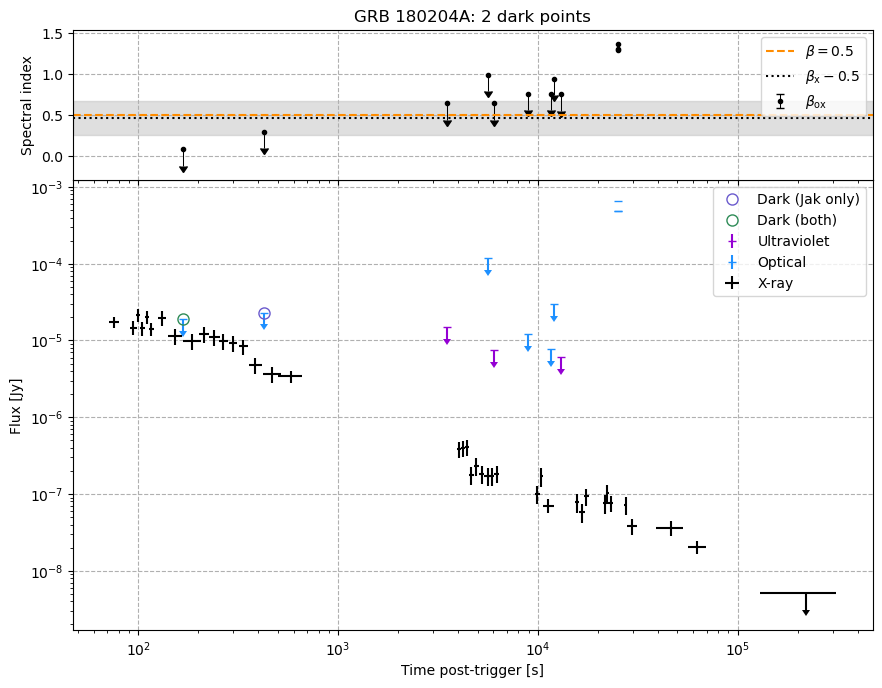

GRB      t_o       dt%  \
873  180204A    167.0  0.088473   
876  180204A    429.0  0.085590   
877  180204A   3503.5  0.133224   
881  180204A   5610.0  0.000121   
887  180204A   6075.0  0.026713   
888  180204A   8988.0  0.098983   
892  180204A  11683.0  0.032183   
894  180204A  12091.0  0.068230   
895  180204A  13045.5  0.152559   
900  180204A  25200.0  0.086293   
905  180204A  25200.0  0.086293   
910  180204A  25200.0  0.086293   

                                           B_ox_w_err                 B_x  \
873  0.08172057145899975 (+0.05496415412971789, -inf)  0.96 (+0.21, -0.2)   
876   0.2976121359239437 (+0.06691837997167112, -inf)  0.96 (+0.21, -0.2)   
877   0.6420782288764217 (+0.11787048321312481, -inf)  0.96 (+0.21, -0.2)   
881   0.9865262434120861 (+0.12962497057014724, -inf)  0.96 (+0.21, -0.2)   
887   0.6443715561357405 (+0.10348192015402807, -inf)  0.96 (+0.21, -0.2)   
888   0.7599729952378779 (+0.11709400620099102, -inf)  0.96 (+0.21, -0.2)   
892   0.7558615623967244 (+0.10708795905675003, -inf)  0.96 (+0.21, -0.2)   
894     0.943958369500233 (+0.1295769652664703, -inf)  0.96 (+0.21, -0.2)   
895   0.7522870715167811 (+0.12875003032360594, -inf)  0.96 (+0.21, -0.2)   
900                   1.3596352869760355 (+nan, -nan)  0.96 (+0.21, -0.2)   
905                   1.2938015684891093 (+nan, -nan)  0.96 (+0.21, -0.2)   
910                   1.3035755745867539 (+nan, -nan)  0.96 (+0.21, -0.2)   

         α Jak_dark vdH_dark  
873  1.073     True     True  
876  1.073     True    False  
877  1.073    False    False  
881  1.073    False    False  
887  1.073    False    False  
888  1.073    False    False  
892  1.073    False    False  
894  1.073    False    False  
895  1.073    False    False  
900  1.073    False    False  
905  1.073    False    False  
910  1.073    False    False

no Ultraviolet for GRB 170827A
0 0 2


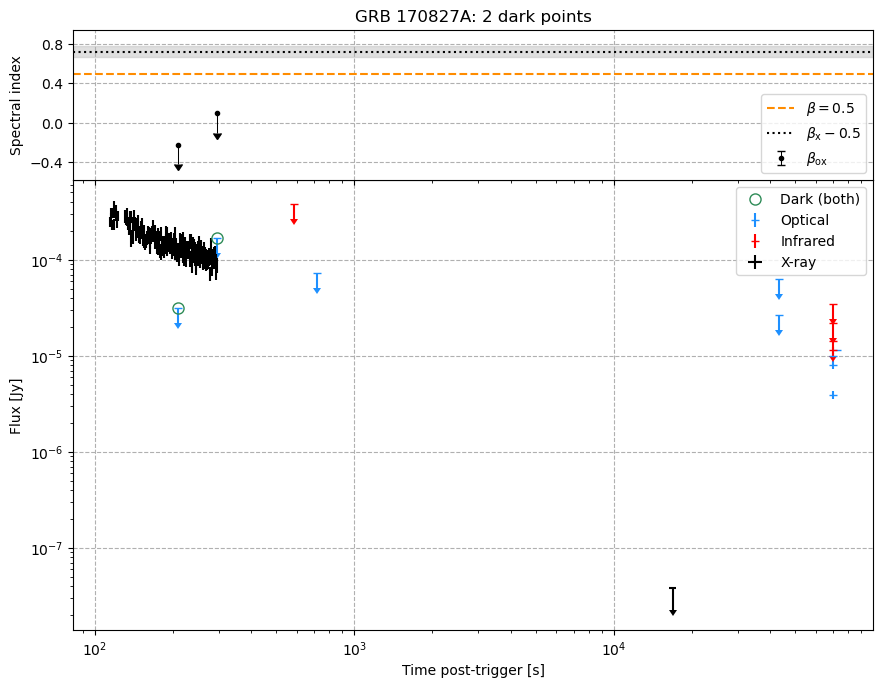

GRB    t_o       dt%  \
945   170827A  209.0  0.001620   
1035  170827A  295.0  0.001141   

                                             B_ox_w_err                  B_x  \
945   -0.2203397298098377 (+0.039224001726319235, -inf)  1.22 (+0.06, -0.05)   
1035   0.10113836807528154 (+0.03191948707598461, -inf)  1.22 (+0.06, -0.05)   

         α Jak_dark vdH_dark  
945   1.19     True     True  
1035  1.19     True     True

5 0 2


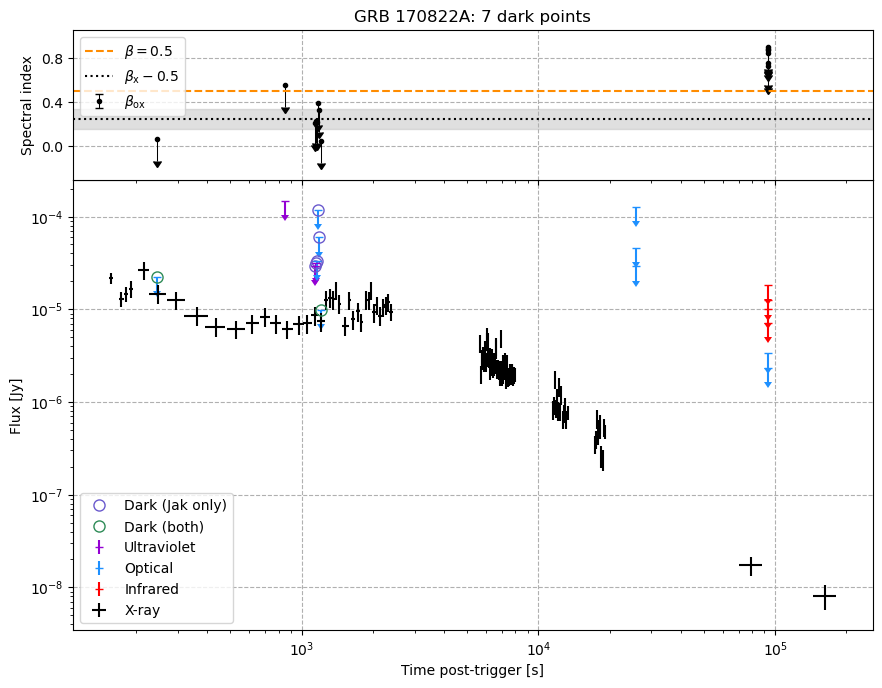

GRB      t_o       dt%  \
1037  170822A    246.0  0.006438   
1040  170822A    852.5  0.021796   
1045  170822A   1137.5  0.001324   
1053  170822A   1151.0  0.010528   
1061  170822A   1162.5  0.020625   
1069  170822A   1171.0  0.028088   
1078  170822A   1187.0  0.017710   
1086  170822A   1211.5  0.002565   
1092  170822A  93294.0  0.178768   
1093  170822A  93294.0  0.178768   
1094  170822A  93294.0  0.178768   
1095  170822A  93294.0  0.178768   
1096  170822A  93294.0  0.178768   
1097  170822A  93294.0  0.178768   

                                             B_ox_w_err          B_x    α  \
1037   0.06632866150371261 (+0.03639487458237825, -inf)  0.75 ± 0.09  1.0   
1040    0.5544462963306861 (+0.08962834553343252, -inf)  0.75 ± 0.09  1.0   
1045    0.2065382858770375 (+0.04815774499357656, -inf)  0.75 ± 0.09  1.0   
1053   0.22706388940018976 (+0.05233729809930151, -inf)  0.75 ± 0.09  1.0   
1061   0.21899768108077097 (+0.04788721575958571, -inf)  0.75 ± 0.09  1.0   
1069   0.39480341427967713 (+0.06132345443956888, -inf)  0.75 ± 0.09  1.0   
1078   0.3255730795351884 (+0.055866177654593896, -inf)  0.75 ± 0.09  1.0   
1086  0.04369080569880635 (+0.037141690846088274, -inf)  0.75 ± 0.09  1.0   
1092     0.7260725864210473 (+0.1189246259640767, -inf)  0.75 ± 0.09  1.0   
1093     0.757191589780777 (+0.11948044169878216, -inf)  0.75 ± 0.09  1.0   
1094     0.8462515631805578 (+0.1257430516258267, -inf)  0.75 ± 0.09  1.0   
1095    0.8776117851423296 (+0.12682754138224064, -inf)  0.75 ± 0.09  1.0   
1096     0.8823887147736473 (+0.1249219067949043, -inf)  0.75 ± 0.09  1.0   
1097    0.9027132829564624 (+0.12380698015314746, -inf)  0.75 ± 0.09  1.0   

     Jak_dark vdH_dark  
1037     True     True  
1040    False    False  
1045     True    False  
1053     True    False  
1061     True    False  
1069     True    False  
1078     True    False  
1086     True     True  
1092    False    False  
1093    False    False  
1094    False    False  
1095    False    False  
1096    False    False  
1097    False    False

no Infrared for GRB 170728B
16 0 15


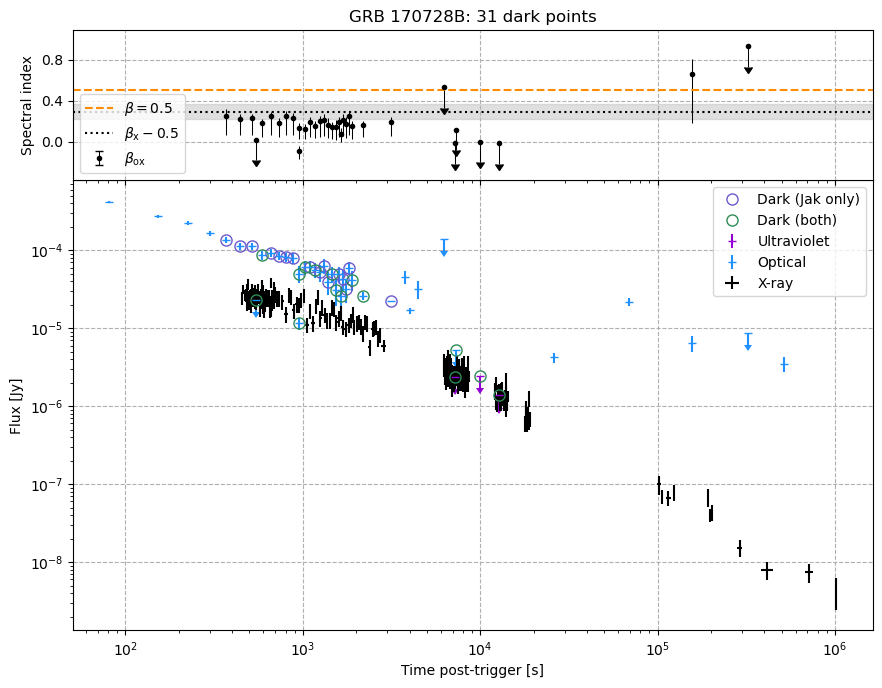

GRB         t_o       dt%  \
1098  170728B     371.000  0.186497   
1100  170728B     444.000  0.026427   
1137  170728B     517.000  0.001554   
1191  170728B     548.000  0.000851   
1251  170728B     589.000  0.002699   
1307  170728B     662.000  0.001591   
1344  170728B     735.000  0.002532   
1360  170728B     807.000  0.004840   
1372  170728B     880.000  0.008298   
1384  170728B     951.000  0.001066   
1396  170728B     953.000  0.003172   
1408  170728B    1026.000  0.014691   
1420  170728B    1098.000  0.000753   
1433  170728B    1171.000  0.012550   
1446  170728B    1243.000  0.007742   
1460  170728B    1316.000  0.013532   
1473  170728B    1389.000  0.013632   
1486  170728B    1462.000  0.000612   
1500  170728B    1534.000  0.006103   
1513  170728B    1607.000  0.009616   
1526  170728B    1644.500  0.006002   
1540  170728B    1680.000  0.000937   
1554  170728B    1753.000  0.003001   
1568  170728B    1825.000  0.007517   
1583  170728B    1898.000  0.004926   
1597  170728B    2190.000  0.001990   
1608  170728B    3150.000  0.101920   
1609  170728B    6244.992  0.000297   
1667  170728B    7255.000  0.001850   
1718  170728B    7285.500  0.002346   
1752  170728B    9965.000  0.154878   
1764  170728B   12764.000  0.001985   
1781  170728B  155360.160  0.192410   
1782  170728B  321670.656  0.107979   

                                             B_ox_w_err                  B_x  \
1098  0.25044226441217077 (+0.06689699664090105, -0....  0.79 (+0.08, -0.07)   
1100  0.22439521296238363 (+0.04201888290485343, -0....  0.79 (+0.08, -0.07)   
1137  0.2273142050325974 (+0.04208145045713396, -0.1...  0.79 (+0.08, -0.07)   
1191   0.018743704294551102 (+0.0293360417086443, -inf)  0.79 (+0.08, -0.07)   
1251  0.1781096822311161 (+0.04016795043538247, -0.1...  0.79 (+0.08, -0.07)   
1307  0.24596624607770318 (+0.04461074272014205, -0....  0.79 (+0.08, -0.07)   
1344  0.18457621386313391 (+0.044494481378185215, -0...  0.79 (+0.08, -0.07)   
1360  0.2492626079164761 (+0.04961978058602232, -0.1...  0.79 (+0.08, -0.07)   
1372  0.227566272804108 (+0.04809312171188405, -0.16...  0.79 (+0.08, -0.07)   
1384  -0.08822109794538191 (+0.04782750223789055, -0...  0.79 (+0.08, -0.07)   
1396  0.1341683621110353 (+0.05126399989145112, -0.1...  0.79 (+0.08, -0.07)   
1408  0.12217608018062213 (+0.04641735870936234, -0....  0.79 (+0.08, -0.07)   
1420  0.18804399412770334 (+0.048225762274585186, -0...  0.79 (+0.08, -0.07)   
1433  0.15557926117772217 (+0.049004795479117264, -0...  0.79 (+0.08, -0.07)   
1446  0.1997430958144993 (+0.05532042479990835, -0.1...  0.79 (+0.08, -0.07)   
1460  0.21350209354040448 (+0.052282654851322316, -0...  0.79 (+0.08, -0.07)   
1473  0.1664405712405106 (+0.06174136147455755, -0.1...  0.79 (+0.08, -0.07)   
1486  0.1426827652097761 (+0.05062247198499502, -0.1...  0.79 (+0.08, -0.07)   
1500  0.14007376539967625 (+0.06826140739792778, -0....  0.79 (+0.08, -0.07)   
1513  0.19094626069006657 (+0.05248011250666278, -0....  0.79 (+0.08, -0.07)   
1526  0.07633621631621328 (+0.05499006066929548, -0....  0.79 (+0.08, -0.07)   
1540  0.2080062878343111 (+0.06039849631156196, -0.1...  0.79 (+0.08, -0.07)   
1554  0.174845244418762 (+0.06462842414425325, -0.13...  0.79 (+0.08, -0.07)   
1568  0.24881537135764847 (+0.0528899656020569, -0.1...  0.79 (+0.08, -0.07)   
1583  0.14997811220446008 (+0.056873356845925226, -0...  0.79 (+0.08, -0.07)   
1597  0.1635409009988904 (+0.04245678763528685, -0.1...  0.79 (+0.08, -0.07)   
1608  0.19460145103402937 (+0.046015371988720334, -0...  0.79 (+0.08, -0.07)   
1609    0.5283712041396927 (+0.07190681929447125, -inf)  0.79 (+0.08, -0.07)   
1667  -0.01582405611031937 (+0.03987156245090574, -inf)  0.79 (+0.08, -0.07)   
1718   0.11631626759799985 (+0.03961845462111817, -inf)  0.79 (+0.08, -0.07)   
1752  0.0012390209473908207 (+0.0863972127521314, -inf)  0.79 (+0.08, -0.07)   
1764  -0.013787394671253103 (+0.038599033560890866, ...  0.79 (+0.08, -0.07)   
1781

no Ultraviolet for GRB 170127B
1 0 0


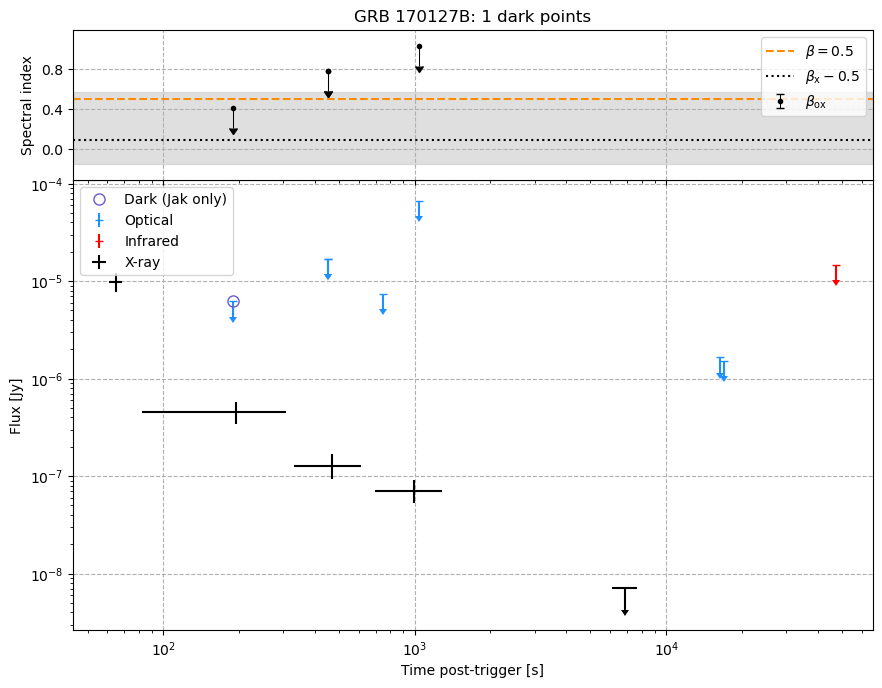

GRB     t_o       dt%  \
1789  170127B   189.0  0.033184   
1790  170127B   451.5  0.040847   
1791  170127B   451.5  0.040847   
1792  170127B  1041.5  0.051929   

                                            B_ox_w_err                  B_x  \
1789  0.41573286666215475 (+0.07187030642336034, -inf)  0.59 (+0.48, -0.24)   
1790   0.7868264752086797 (+0.11860436191480121, -inf)  0.59 (+0.48, -0.24)   
1791   0.7868264752086797 (+0.11860436191480121, -inf)  0.59 (+0.48, -0.24)   
1792    1.0333784403216164 (+0.1407378826257445, -inf)  0.59 (+0.48, -0.24)   

        α Jak_dark vdH_dark  
1789  1.9     True    False  
1790  1.9    False    False  
1791  1.9    False    False  
1792  1.9    False    False

2 0 0


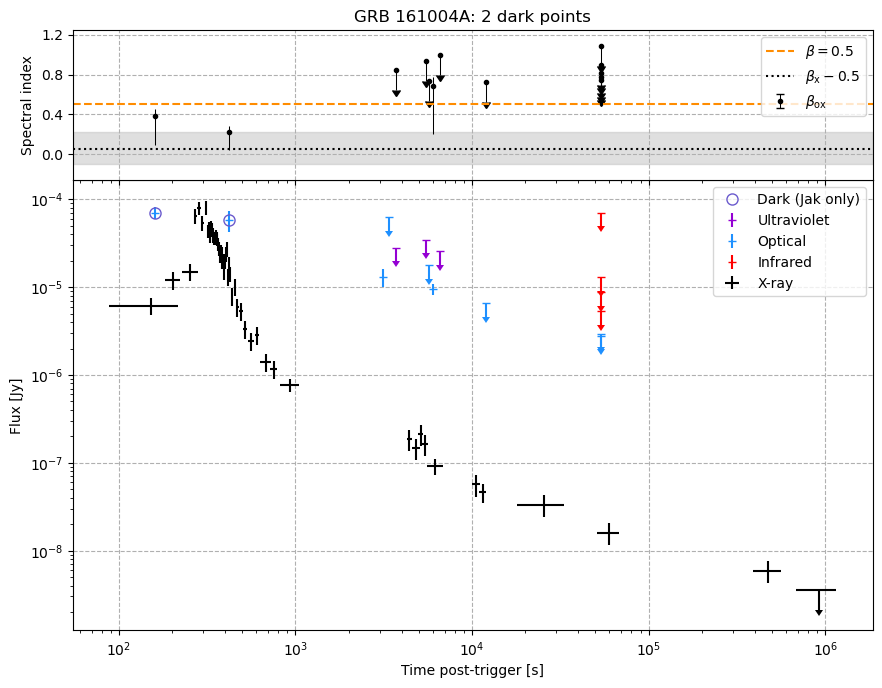

GRB        t_o       dt%  \
1793  161004A    160.000  0.049511   
1810  161004A    422.000  0.006133   
1816  161004A   3689.500  0.165222   
1819  161004A   5508.000  0.016397   
1823  161004A   5739.000  0.059024   
1827  161004A   6031.584  0.026322   
1828  161004A   6554.000  0.058012   
1830  161004A  12061.440  0.049469   
1831  161004A  53496.000  0.099868   
1832  161004A  53496.000  0.099868   
1833  161004A  53496.000  0.099868   
1834  161004A  53496.000  0.099868   
1835  161004A  53496.000  0.099868   
1836  161004A  53496.000  0.099868   

                                             B_ox_w_err                  B_x  \
1793  0.3880093011510872 (+0.06981752143036461, -0.2...  0.55 (+0.17, -0.15)   
1810  0.2271069800104917 (+0.061431669756167734, -0....  0.55 (+0.17, -0.15)   
1816     0.8473018639494653 (+0.1440953380868695, -inf)  0.55 (+0.17, -0.15)   
1819     0.9339777102208214 (+0.1423238646231631, -inf)  0.55 (+0.17, -0.15)   
1823    0.7342353790575469 (+0.10667268257281373, -inf)  0.55 (+0.17, -0.15)   
1827  0.6829336454445946 (+0.09109339737894871, -0.4...  0.55 (+0.17, -0.15)   
1828    0.9937977154246759 (+0.15110339615659701, -inf)  0.55 (+0.17, -0.15)   
1830    0.7283576529608677 (+0.09797631196783615, -inf)  0.55 (+0.17, -0.15)   
1831    0.7722063755142828 (+0.11176208336025191, -inf)  0.55 (+0.17, -0.15)   
1832    0.7424924159741795 (+0.10603918764257649, -inf)  0.55 (+0.17, -0.15)   
1833     0.8175303308371378 (+0.1114571655874065, -inf)  0.55 (+0.17, -0.15)   
1834    0.8681495766736285 (+0.11448847189271323, -inf)  0.55 (+0.17, -0.15)   
1835    0.8974337890306233 (+0.11465192731362879, -inf)  0.55 (+0.17, -0.15)   
1836    1.0867513764461323 (+0.12926224941211678, -inf)  0.55 (+0.17, -0.15)   

         α Jak_dark vdH_dark  
1793  1.04     True    False  
1810  1.04     True    False  
1816  1.04    False    False  
1819  1.04    False    False  
1823  1.04    False    False  
1827  1.04    False    False  
1828  1.04    False    False  
1830  1.04    False    False  
1831  1.04    False    False  
1832  1.04    False    False  
1833  1.04    False    False  
1834  1.04    False    False  
1835  1.04    False    False  
1836  1.04    False    False

no Infrared for GRB 160927A
1 0 0


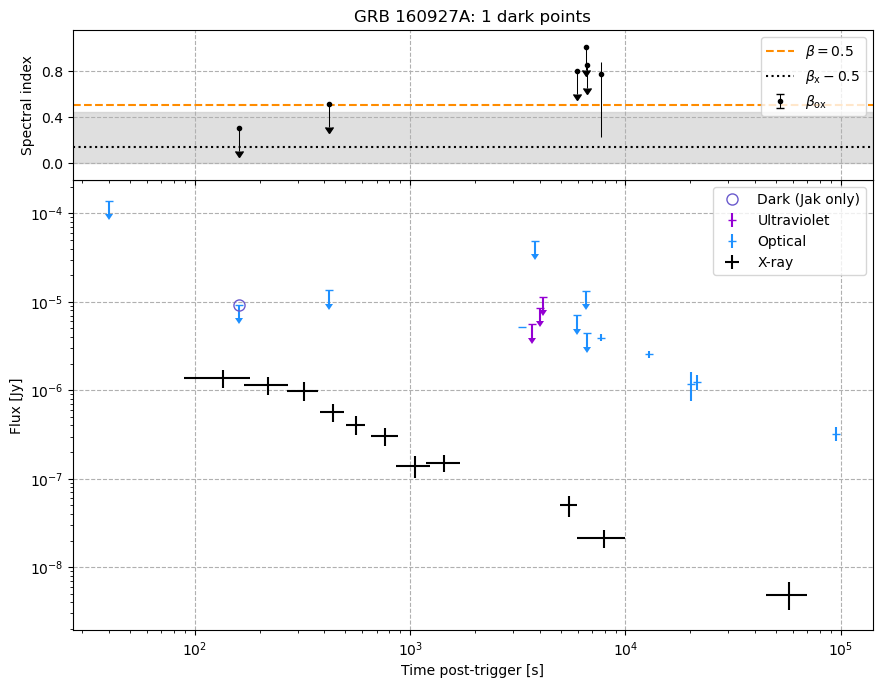

GRB     t_o       dt%  \
1841  160927A   160.0  0.186486   
1842  160927A   422.0  0.034057   
1843  160927A  5942.0  0.090128   
1845  160927A  6526.5  0.179150   
1846  160927A  6634.5  0.165566   
1847  160927A  7668.0  0.035581   

                                             B_ox_w_err                 B_x  \
1841    0.3043567855111735 (+0.09307714658151692, -inf)  0.64 (+0.3, -0.14)   
1842    0.5119706378540153 (+0.07872137712422937, -inf)  0.64 (+0.3, -0.14)   
1843    0.7987395538970372 (+0.12128864425471846, -inf)  0.64 (+0.3, -0.14)   
1845     1.0063520146383453 (+0.1526769050409731, -inf)  0.64 (+0.3, -0.14)   
1846    0.8486969497498111 (+0.13487195914901204, -inf)  0.64 (+0.3, -0.14)   
1847  0.7731784924860126 (+0.10199340349470369, -0.5...  0.64 (+0.3, -0.14)   

         α Jak_dark vdH_dark  
1841  1.02     True    False  
1842  1.02    False    False  
1843  1.02    False    False  
1845  1.02    False    False  
1846  1.02    False    False  
1847  1.02    False    False

1 0 3


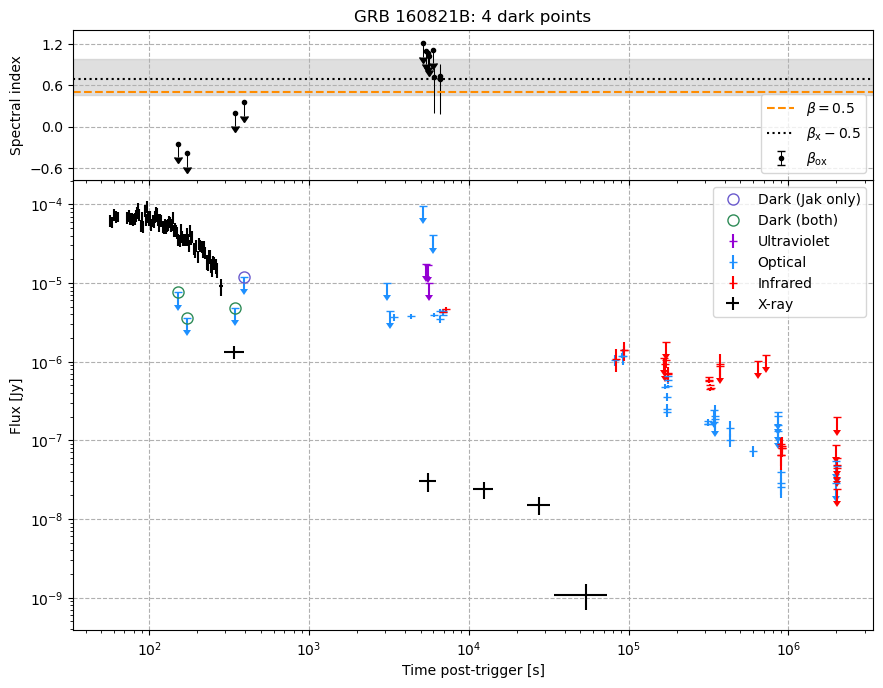

GRB     t_o       dt%  \
1860  160821B   151.0  0.006749   
1883  160821B   172.8  0.006823   
1896  160821B   345.6  0.013968   
1897  160821B   394.5  0.157438   
1898  160821B  5180.0  0.066369   
1899  160821B  5385.0  0.029421   
1900  160821B  5591.0  0.007708   
1901  160821B  5657.0  0.019604   
1902  160821B  6001.0  0.081606   
1903  160821B  6048.0  0.090077   
1904  160821B  6566.4  0.183512   
1905  160821B  6588.0  0.187405   

                                             B_ox_w_err                 B_x  \
1860   -0.2475183058201295 (+0.04262286347909809, -inf)  1.2 (+0.28, -0.24)   
1883   -0.3891564442367287 (+0.05869908696221627, -inf)  1.2 (+0.28, -0.24)   
1896   0.20504740497975443 (+0.04286303429745853, -inf)  1.2 (+0.28, -0.24)   
1897   0.35364396325784125 (+0.14527064340318116, -inf)  1.2 (+0.28, -0.24)   
1898     1.2146676997941956 (+0.1675261705503998, -inf)  1.2 (+0.28, -0.24)   
1899     1.1042728740123586 (+0.1676601540688427, -inf)  1.2 (+0.28, -0.24)   
1900     1.067672678434761 (+0.15582804961585944, -inf)  1.2 (+0.28, -0.24)   
1901      1.02165646869779 (+0.15719606617208984, -inf)  1.2 (+0.28, -0.24)   
1902      1.121564109014966 (+0.1669021590624872, -inf)  1.2 (+0.28, -0.24)   
1903  0.7211540772861706 (+0.12523509619105466, -0.5...  1.2 (+0.28, -0.24)   
1904  0.6965031238722958 (+0.18105677167979525, -0.5...  1.2 (+0.28, -0.24)   
1905  0.7331385415285029 (+0.18541600964331537, -0.5...  1.2 (+0.28, -0.24)   

         α Jak_dark vdH_dark  
1860  2.11     True     True  
1883  2.11     True     True  
1896  2.11     True     True  
1897  2.11     True    False  
1898  2.11    False    False  
1899  2.11    False    False  
1900  2.11    False    False  
1901  2.11    False    False  
1902  2.11    False    False  
1903  2.11    False    False  
1904  2.11    False    False  
1905  2.11    False    False

2 0 0


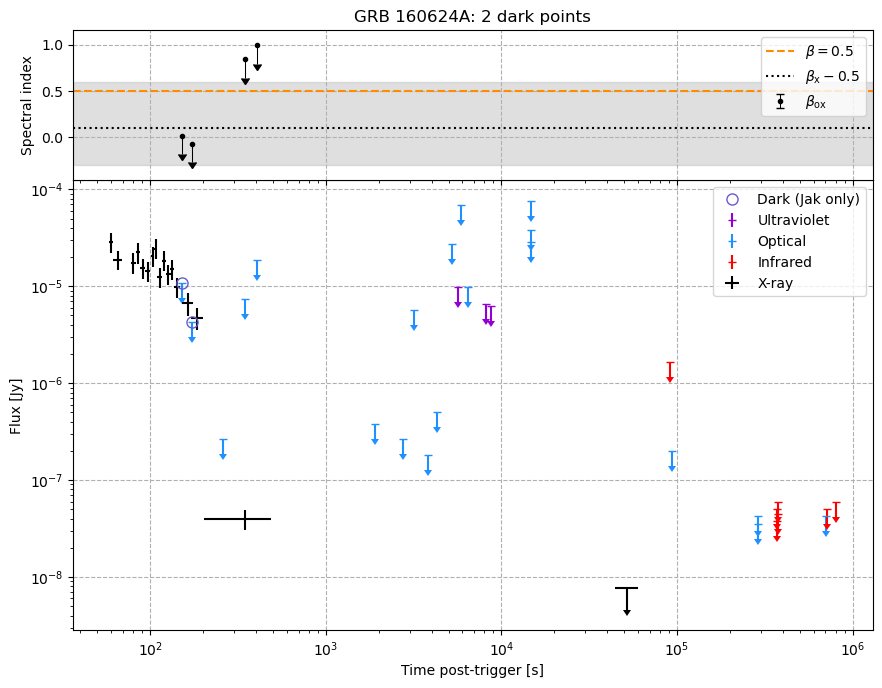

GRB    t_o       dt%  \
1907  160624A  152.0  0.066876   
1910  160624A  172.8  0.058227   
1912  160624A  345.6  0.001057   
1913  160624A  408.0  0.181804   

                                             B_ox_w_err               B_x  \
1907  0.016029122534107654 (+0.11115362302302455, -inf)  0.6 (+0.5, -0.4)   
1910   -0.07121833377450952 (+0.1012355407851191, -inf)  0.6 (+0.5, -0.4)   
1912    0.8446025265261514 (+0.11847515649000338, -inf)  0.6 (+0.5, -0.4)   
1913    0.9931990848042382 (+0.30414961028143517, -inf)  0.6 (+0.5, -0.4)   

         α Jak_dark vdH_dark  
1907  3.74     True    False  
1910  3.74     True    False  
1912  3.74    False    False  
1913  3.74    False    False

no Infrared for GRB 160525B
1 0 0


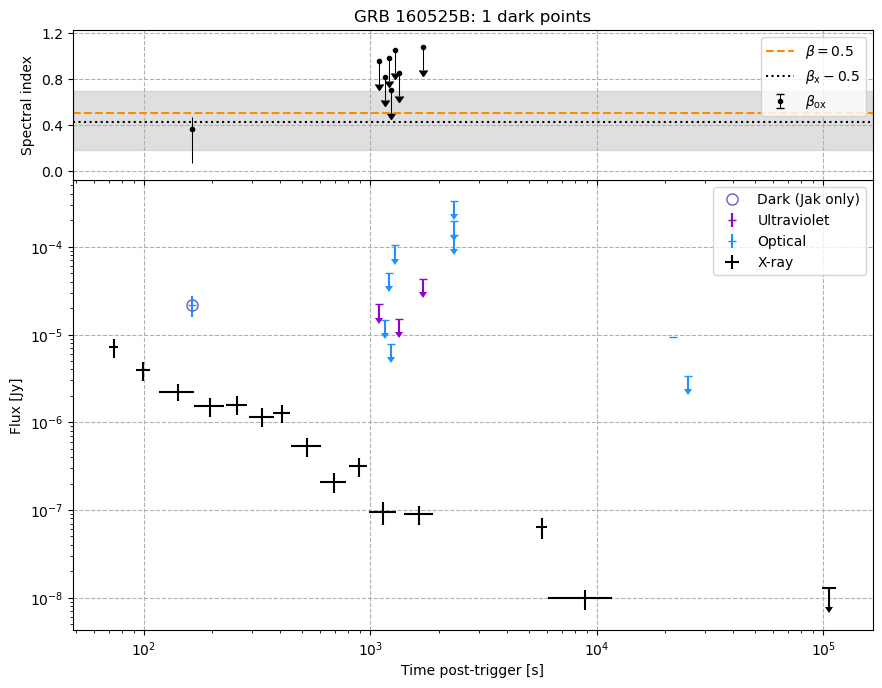

GRB     t_o       dt%  \
1916  160525B   163.0  0.147346   
1918  160525B  1089.5  0.042582   
1919  160525B  1159.0  0.018492   
1920  160525B  1213.0  0.065945   
1921  160525B  1237.5  0.087475   
1922  160525B  1288.0  0.131853   
1923  160525B  1338.0  0.175791   
1925  160525B  1699.0  0.033456   

                                             B_ox_w_err                  B_x  \
1916  0.3610739023388736 (+0.11017183909020013, -0.2...  0.93 (+0.27, -0.25)   
1918     0.9598085722444535 (+0.1505824681624388, -inf)  0.93 (+0.27, -0.25)   
1919    0.8143470698290319 (+0.11839210478964385, -inf)  0.93 (+0.27, -0.25)   
1920     0.9806204332284915 (+0.1393219176331166, -inf)  0.93 (+0.27, -0.25)   
1921     0.7016803005209801 (+0.1140647789965363, -inf)  0.93 (+0.27, -0.25)   
1922    1.0553819432716813 (+0.15683502083892772, -inf)  0.93 (+0.27, -0.25)   
1923    0.8554296117309526 (+0.16068101171700047, -inf)  0.93 (+0.27, -0.25)   
1925     1.0756229807785804 (+0.1617684866363984, -inf)  0.93 (+0.27, -0.25)   

         α Jak_dark vdH_dark  
1916  1.37     True    False  
1918  1.37    False    False  
1919  1.37    False    False  
1920  1.37    False    False  
1921  1.37    False    False  
1922  1.37    False    False  
1923  1.37    False    False  
1925  1.37    False    False

no Infrared for GRB 160408A
1 0 0


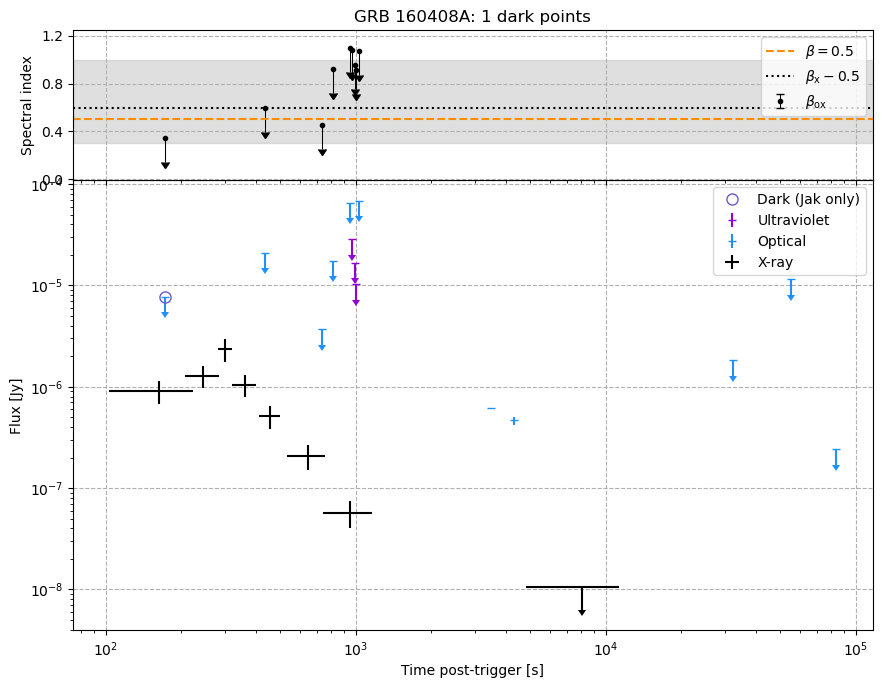

GRB     t_o       dt%  \
1935  160408A   173.0  0.054962   
1936  160408A   436.0  0.041864   
1937  160408A   731.5  0.138956   
1938  160408A   813.5  0.143116   
1939  160408A   953.0  0.003824   
1940  160408A   965.0  0.016464   
1941  160408A   991.0  0.043850   
1942  160408A  1003.5  0.057017   
1943  160408A  1027.5  0.082297   

                                            B_ox_w_err               B_x    α  \
1935  0.34126947057766777 (+0.07021671202580733, -inf)  1.1 (+0.4, -0.3)  1.6   
1936   0.5993653899235445 (+0.09371923045970519, -inf)  1.1 (+0.4, -0.3)  1.6   
1937   0.4573872007139887 (+0.11687892821479748, -inf)  1.1 (+0.4, -0.3)  1.6   
1938     0.923676687657931 (+0.1616111918922529, -inf)  1.1 (+0.4, -0.3)  1.6   
1939   1.0987643700872323 (+0.14916506024123694, -inf)  1.1 (+0.4, -0.3)  1.6   
1940   1.0815420104347433 (+0.16431121885624947, -inf)  1.1 (+0.4, -0.3)  1.6   
1941   0.9587096886990327 (+0.14590892958416357, -inf)  1.1 (+0.4, -0.3)  1.6   
1942   0.9147261680070717 (+0.14828830532504972, -inf)  1.1 (+0.4, -0.3)  1.6   
1943    1.0699514831396904 (+0.1511419161158295, -inf)  1.1 (+0.4, -0.3)  1.6   

     Jak_dark vdH_dark  
1935     True    False  
1936    False    False  
1937    False    False  
1938    False    False  
1939    False    False  
1940    False    False  
1941    False    False  
1942    False    False  
1943    False    False

no Infrared for GRB 151229A
1 0 2


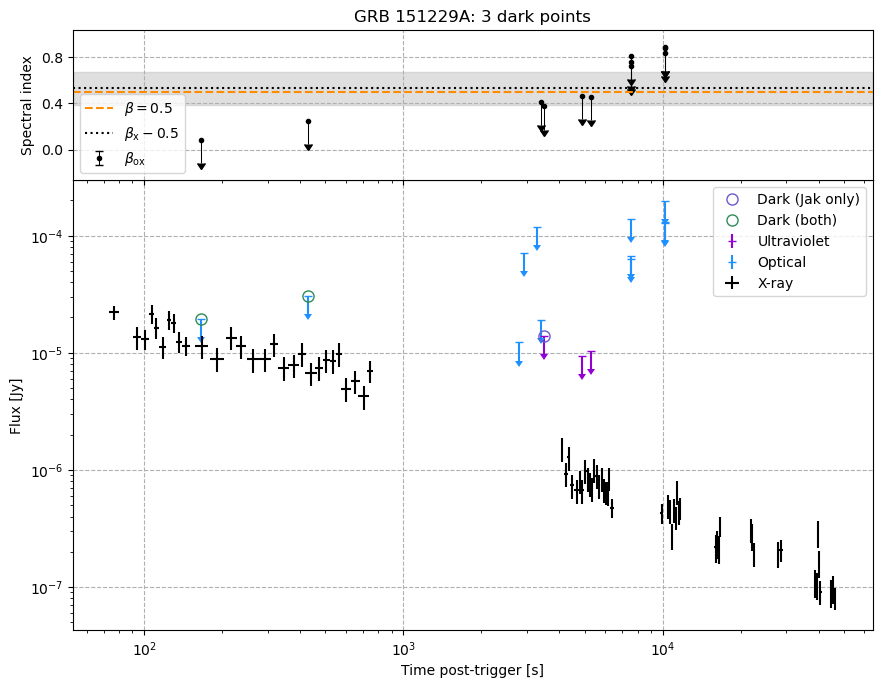

GRB        t_o       dt%  \
1946  151229A    165.000  0.009318   
1950  151229A    427.000  0.031102   
1953  151229A   3407.500  0.168752   
1955  151229A   3497.500  0.146797   
1964  151229A   4881.500  0.003939   
1981  151229A   5291.000  0.004618   
1992  151229A   7533.000  0.180161   
1993  151229A   7533.000  0.180161   
1994  151229A   7533.000  0.180161   
1995  151229A  10172.736  0.025007   
2004  151229A  10172.736  0.025007   
2013  151229A  10172.736  0.025007   

                                             B_ox_w_err          B_x      α  \
1946  0.08551899905655147 (+0.037419935813015996, -inf)  1.03 ± 0.14  0.497   
1950  0.24419921461541708 (+0.048525361239904335, -inf)  1.03 ± 0.14  0.497   
1953   0.40866729611492486 (+0.09212008493579942, -inf)  1.03 ± 0.14  0.950   
1955     0.3734996615407826 (+0.0860956650015564, -inf)  1.03 ± 0.14  0.950   
1964    0.4644253910788263 (+0.07901553636449099, -inf)  1.03 ± 0.14  0.950   
1981     0.4534709302650664 (+0.0765732673538284, -inf)  1.03 ± 0.14  0.950   
1992    0.7537089712252784 (+0.12127242262384737, -inf)  1.03 ± 0.14  0.950   
1993    0.7272558690156109 (+0.11494543007793025, -inf)  1.03 ± 0.14  0.950   
1994    0.8103979885216062 (+0.12056411884043737, -inf)  1.03 ± 0.14  0.950   
1995    0.8838078505832654 (+0.11700752605861212, -inf)  1.03 ± 0.14  0.950   
2004    0.8377419247366603 (+0.10620746740676278, -inf)  1.03 ± 0.14  0.950   
2013      0.87838798259711 (+0.10793835880098035, -inf)  1.03 ± 0.14  0.950   

     Jak_dark vdH_dark  
1946     True     True  
1950     True     True  
1953    False    False  
1955     True    False  
1964    False    False  
1981    False    False  
1992    False    False  
1993    False    False  
1994    False    False  
1995    False    False  
2004    False    False  
2013    False    False

1 0 0


C:\Users\cgobat\Miniconda3\envs\dev\lib\site-packages\matplotlib\axes\_axes.py:3601: RuntimeWarning: invalid value encountered in scalar multiply
  low, high = dep + np.row_stack([-(1 - lolims), 1 - uplims]) * err
C:\Users\cgobat\Miniconda3\envs\dev\lib\site-packages\matplotlib\axes\_axes.py:3601: RuntimeWarning: invalid value encountered in multiply
  low, high = dep + np.row_stack([-(1 - lolims), 1 - uplims]) * err


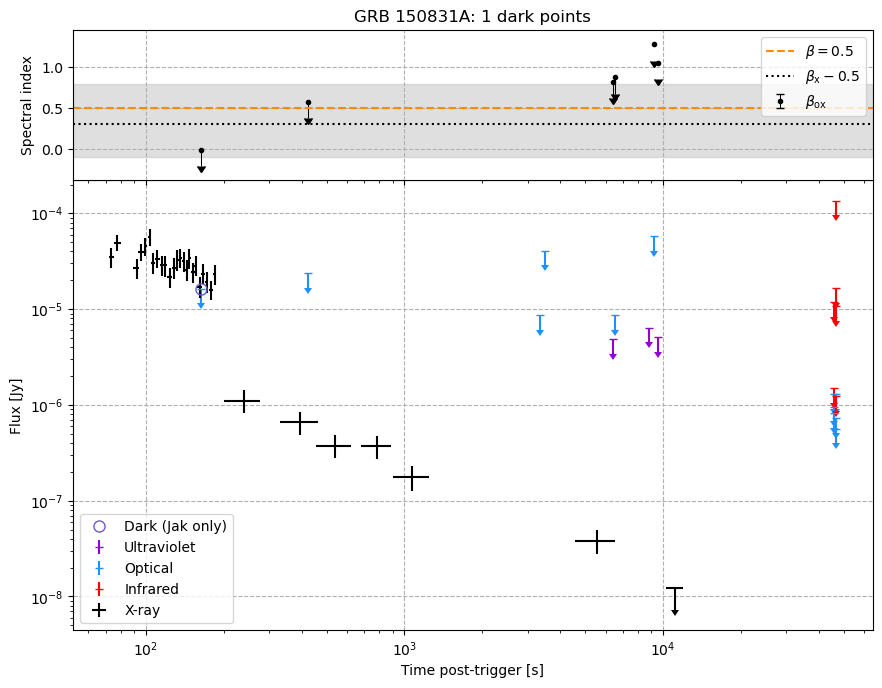

GRB     t_o       dt%  \
2031  150831A   163.0  0.010470   
2036  150831A   425.0  0.072331   
2037  150831A  6396.0  0.150285   
2038  150831A  6542.0  0.176542   
2039  150831A  9258.0  0.167377   
2040  150831A  9592.0  0.137338   

                                             B_ox_w_err               B_x  \
2031  -0.00714602404155144 (+0.038790906752000344, -...  0.8 (+0.5, -0.4)   
2036    0.5787249385195573 (+0.09500633572598878, -inf)  0.8 (+0.5, -0.4)   
2037    0.8181188963369559 (+0.14283691255254122, -inf)  0.8 (+0.5, -0.4)   
2038     0.8761056081892415 (+0.1504578129109857, -inf)  0.8 (+0.5, -0.4)   
2039                           1.2786849871608272 ± inf  0.8 (+0.5, -0.4)   
2040                           1.0501271864637942 ± inf  0.8 (+0.5, -0.4)   

         α Jak_dark vdH_dark  
2031  1.18     True    False  
2036  1.18    False    False  
2037  1.18    False    False  
2038  1.18    False    False  
2039  1.18    False    False  
2040  1.18    False    False

2 0 4


C:\Users\cgobat\Miniconda3\envs\dev\lib\site-packages\matplotlib\axes\_axes.py:3601: RuntimeWarning: invalid value encountered in scalar multiply
  low, high = dep + np.row_stack([-(1 - lolims), 1 - uplims]) * err
C:\Users\cgobat\Miniconda3\envs\dev\lib\site-packages\matplotlib\axes\_axes.py:3601: RuntimeWarning: invalid value encountered in multiply
  low, high = dep + np.row_stack([-(1 - lolims), 1 - uplims]) * err


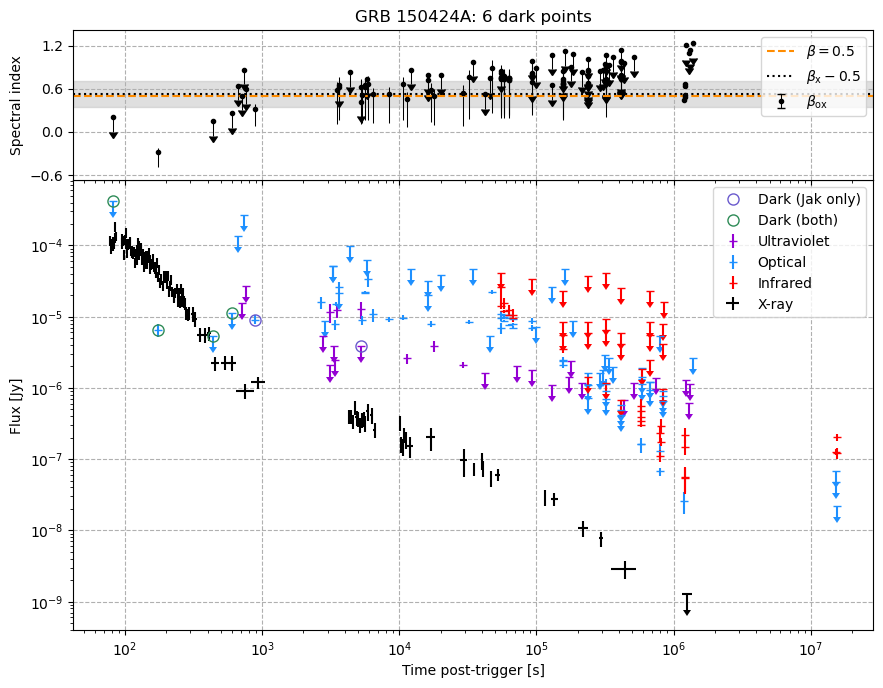

GRB          t_o       dt%  \
2045  150424A       82.000  0.006095   
2071  150424A      174.000  0.002791   
2086  150424A      436.000  0.038665   
2089  150424A      601.000  0.010159   
2090  150424A      664.000  0.093602   
...       ...          ...       ...   
2314  150424A  1206264.096  0.038335   
2315  150424A  1224527.000  0.023775   
2316  150424A  1295417.000  0.032740   
2317  150424A  1310529.000  0.044788   
2318  150424A  1394595.000  0.111807   

                                             B_ox_w_err                  B_x  \
2045   0.2015741817773901 (+0.035108501717430796, -inf)  1.02 (+0.18, -0.17)   
2071  -0.27448807935892167 (+0.055530401460026926, -...  1.02 (+0.18, -0.17)   
2086     0.14382370926139018 (+0.059709905069334, -inf)  1.02 (+0.18, -0.17)   
2089   0.25717748383674716 (+0.05148722044503181, -inf)  1.02 (+0.18, -0.17)   
2090    0.6418120335104655 (+0.09461724595459572, -inf)  1.02 (+0.18, -0.17)   
...                                                 ...                  ...   
2314    0.4877564949109078 (+inf, -0.30963385908012864)  1.02 (+0.18, -0.17)   
2315                           1.2025261435848176 ± inf  1.02 (+0.18, -0.17)   
2316                           1.0901029204818726 ± inf  1.02 (+0.18, -0.17)   
2317                           1.1442678984731742 ± inf  1.02 (+0.18, -0.17)   
2318                           1.2284152302437121 ± inf  1.02 (+0.18, -0.17)   

         α Jak_dark vdH_dark  
2045  1.00     True     True  
2071  2.57     True     True  
2086  2.57     True     True  
2089  2.57     True     True  
2090  0.71    False    False  
...    ...      ...      ...  
2314  1.70    False    False  
2315  1.70    False    False  
2316  1.70    False    False  
2317  1.70    False    False  
2318  1.70    False    False  

[107 rows x 8 columns]

0 0 1


C:\Users\cgobat\Miniconda3\envs\dev\lib\site-packages\matplotlib\axes\_axes.py:3601: RuntimeWarning: invalid value encountered in scalar multiply
  low, high = dep + np.row_stack([-(1 - lolims), 1 - uplims]) * err
C:\Users\cgobat\Miniconda3\envs\dev\lib\site-packages\matplotlib\axes\_axes.py:3601: RuntimeWarning: invalid value encountered in multiply
  low, high = dep + np.row_stack([-(1 - lolims), 1 - uplims]) * err


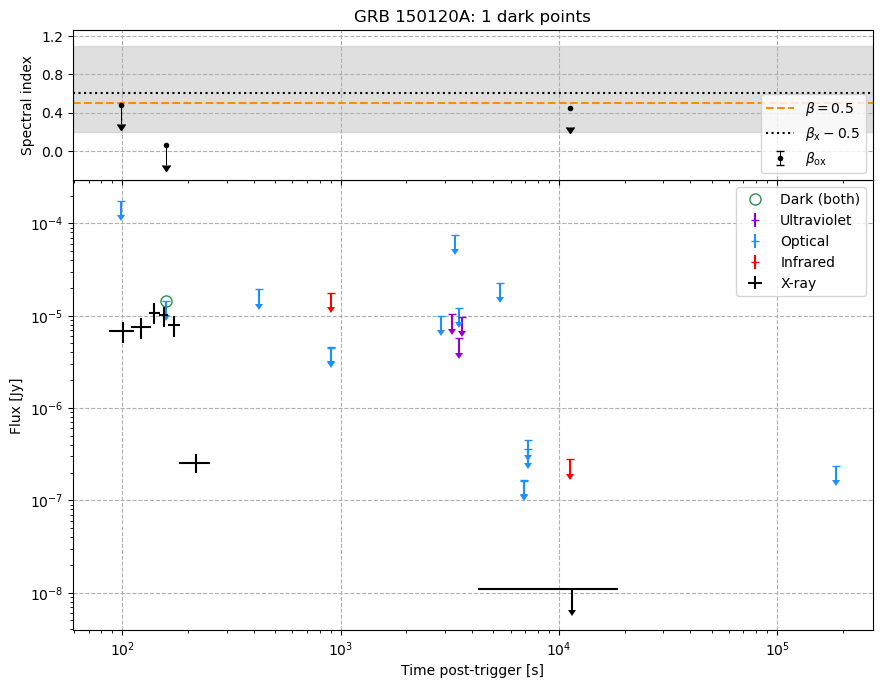

GRB      t_o       dt%  \
2331  150120A     98.0  0.020421   
2334  150120A    158.0  0.022462   
2336  150120A  11232.0  0.020604   

                                           B_ox_w_err               B_x     α  \
2331   0.479977255044103 (+0.07941447192576484, -inf)  1.1 (+0.5, -0.4)  4.38   
2334  0.05687691449590588 (+0.0586804064924505, -inf)  1.1 (+0.5, -0.4)  4.38   
2336                        0.45027988961062976 ± inf  1.1 (+0.5, -0.4)  4.38   

     Jak_dark vdH_dark  
2331    False    False  
2334     True     True  
2336    False    False

no Ultraviolet for GRB 150101B
1 0 0


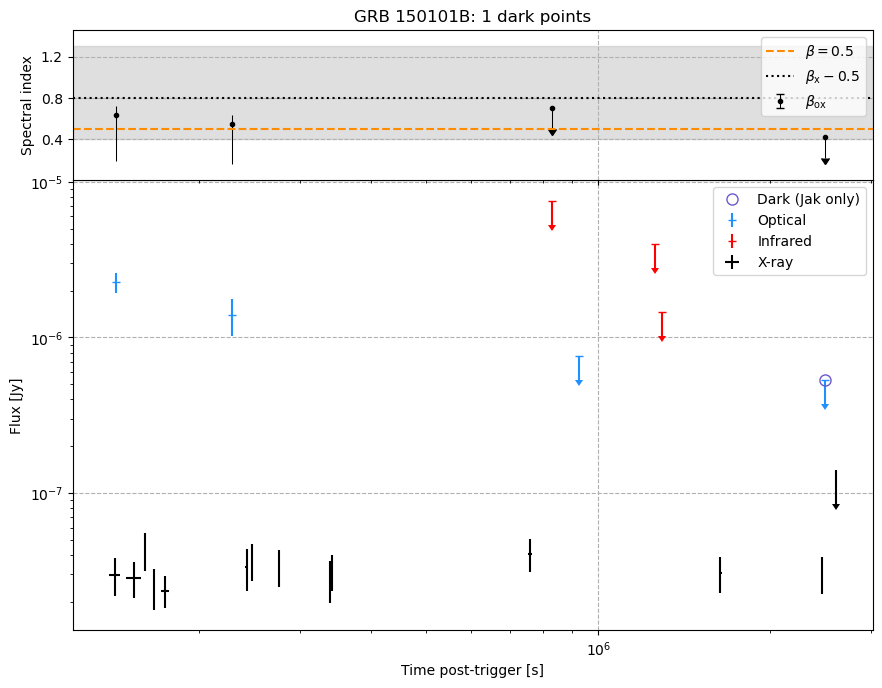

GRB        t_o       dt%  \
2337  150101B   143280.0  0.005732   
2342  150101B   228960.0  0.055246   
2345  150101B   831600.0  0.093281   
2346  150101B  2498400.0  0.013928   

                                             B_ox_w_err               B_x  \
2337  0.6339747633202867 (+0.08915637736992384, -0.4...  1.3 (+0.5, -0.4)   
2342  0.5473913248082393 (+0.09112501007166433, -0.3...  1.3 (+0.5, -0.4)   
2345    0.6994143541072634 (+0.09175470795474887, -inf)  1.3 (+0.5, -0.4)   
2346   0.41836988062206276 (+0.06387739068269137, -inf)  1.3 (+0.5, -0.4)   

        α Jak_dark vdH_dark  
2337  1.0    False    False  
2342  1.0    False    False  
2345  1.0    False    False  
2346  1.0     True    False

1 0 0


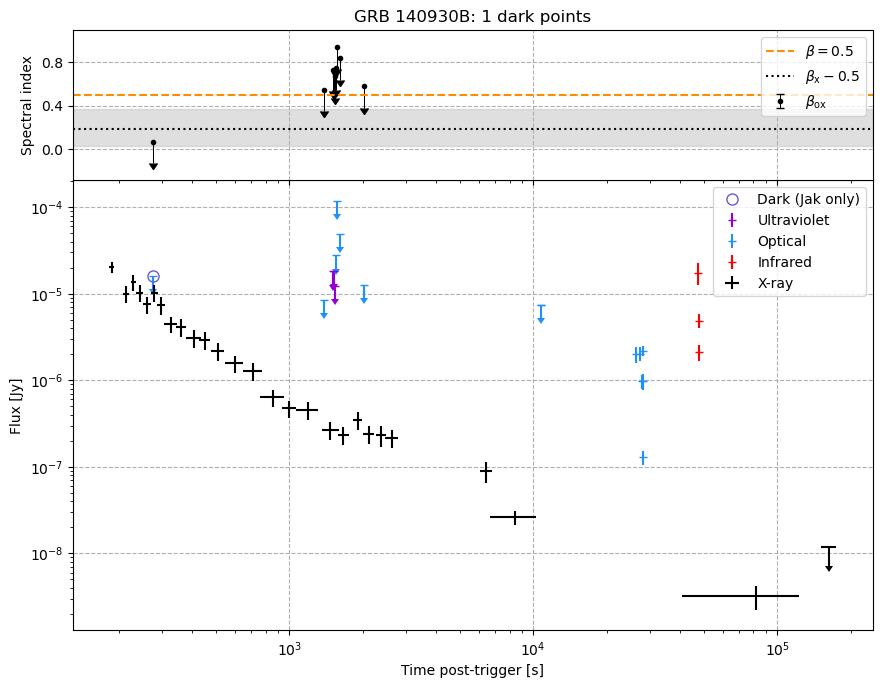

GRB     t_o       dt%  \
2357  140930B   276.0  0.014074   
2361  140930B  1390.0  0.058011   
2363  140930B  1505.5  0.020262   
2365  140930B  1530.5  0.037205   
2368  140930B  1544.0  0.046353   
2371  140930B  1554.5  0.053469   
2375  140930B  1568.0  0.059726   
2378  140930B  1610.0  0.034540   
2381  140930B  2022.0  0.046194   

                                            B_ox_w_err                  B_x  \
2357  0.0715626635639951 (+0.038461031940199515, -inf)  0.69 (+0.18, -0.16)   
2361   0.5481983614433009 (+0.09158713095362558, -inf)  0.69 (+0.18, -0.16)   
2363   0.7324498940525461 (+0.11400294699064774, -inf)  0.69 (+0.18, -0.16)   
2365   0.7133600815291702 (+0.11061259019062646, -inf)  0.69 (+0.18, -0.16)   
2368   0.6747013451038738 (+0.11202262629435358, -inf)  0.69 (+0.18, -0.16)   
2371   0.7485076014419401 (+0.11381619833576342, -inf)  0.69 (+0.18, -0.16)   
2375    0.940398850877426 (+0.13026179788056905, -inf)  0.69 (+0.18, -0.16)   
2378   0.8354381242473943 (+0.11683139642648652, -inf)  0.69 (+0.18, -0.16)   
2381    0.583720111315267 (+0.08588244609846378, -inf)  0.69 (+0.18, -0.16)   

         α Jak_dark vdH_dark  
2357  1.74     True    False  
2361  1.74    False    False  
2363  1.74    False    False  
2365  1.74    False    False  
2368  1.74    False    False  
2371  1.74    False    False  
2375  1.74    False    False  
2378  1.74    False    False  
2381  1.74    False    False

1 0 0


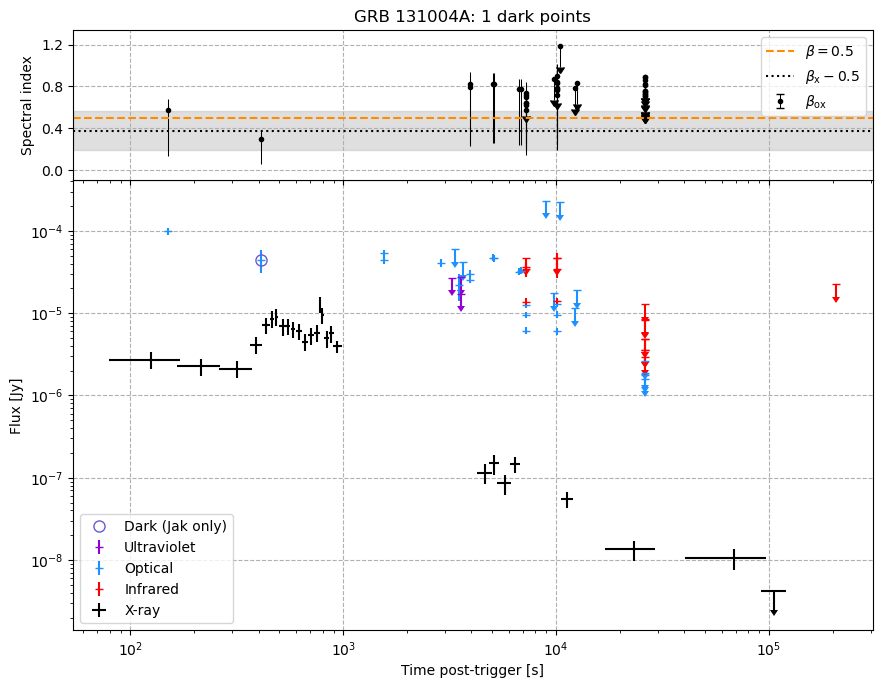

GRB      t_o       dt%  \
2437  131004A    150.0  0.199185   
2439  131004A    412.5  0.051755   
2442  131004A   3960.0  0.147661   
2443  131004A   3960.0  0.147661   
2445  131004A   5040.0  0.013325   
2448  131004A   5106.0  0.000405   
2451  131004A   6678.0  0.041696   
2453  131004A   6840.0  0.066966   
2454  131004A   7200.0  0.123122   
2455  131004A   7200.0  0.123122   
2456  131004A   7200.0  0.123122   
2457  131004A   7200.0  0.123122   
2458  131004A   7200.0  0.123122   
2459  131004A   7200.0  0.123122   
2460  131004A   7200.0  0.123122   
2461  131004A   9720.0  0.138666   
2462  131004A  10080.0  0.106765   
2463  131004A  10080.0  0.106765   
2464  131004A  10080.0  0.106765   
2465  131004A  10080.0  0.106765   
2466  131004A  10080.0  0.106765   
2467  131004A  10080.0  0.106765   
2468  131004A  10080.0  0.106765   
2469  131004A  10440.0  0.074864   
2470  131004A  12240.0  0.084643   
2471  131004A  12600.0  0.116544   
2472  131004A  26208.0  0.134530   
2473  131004A  26208.0  0.134530   
2474  131004A  26208.0  0.134530   
2475  131004A  26208.0  0.134530   
2476  131004A  26208.0  0.134530   
2477  131004A  26208.0  0.134530   
2478  131004A  26280.0  0.137647   
2479  131004A  26280.0  0.137647   
2480  131004A  26280.0  0.137647   
2481  131004A  26280.0  0.137647   
2482  131004A  26280.0  0.137647   
2483  131004A  26280.0  0.137647   

                                             B_ox_w_err                  B_x  \
2437  0.5701365911293371 (+0.11406334761440731, -0.4...  0.87 (+0.19, -0.18)   
2439  0.2949948485695837 (+0.07605737220324377, -0.2...  0.87 (+0.19, -0.18)   
2442  0.818994263043481 (+0.12261997073581882, -0.57...  0.87 (+0.19, -0.18)   
2443  0.7934819335542955 (+0.12022341493557644, -0.5...  0.87 (+0.19, -0.18)   
2445  0.8237025009811003 (+0.10575414404273543, -0.5...  0.87 (+0.19, -0.18)   
2448  0.8235804165812407 (+0.10591618289470928, -0.5...  0.87 (+0.19, -0.18)   
2451  0.7719516163975538 (+0.0993390138694306, -0.53...  0.87 (+0.19, -0.18)   
2453  0.7723064082520155 (+0.10135117998383049, -0.5...  0.87 (+0.19, -0.18)   
2454  0.5786442459953199 (+0.09633431303737088, -0.4...  0.87 (+0.19, -0.18)   
2455  0.6180802015528337 (+0.09687324366469663, -0.4...  0.87 (+0.19, -0.18)   
2456  0.6393739341257555 (+0.09656749524569139, -0.4...  0.87 (+0.19, -0.18)   
2457  0.6366754555575301 (+0.09471102343261567, -0.4...  0.87 (+0.19, -0.18)   
2458  0.7399796709917466 (+0.10313598268681809, -0.4...  0.87 (+0.19, -0.18)   
2459  0.7032153132918811 (+0.09709886432752067, -0.4...  0.87 (+0.19, -0.18)   
2460    0.7200410717469378 (+0.09314300146763566, -inf)  0.87 (+0.19, -0.18)   
2461      0.8677972431663711 (+0.125553742818277, -inf)  0.87 (+0.19, -0.18)   
2462  0.7207391325921415 (+0.10754831142618532, -0.5...  0.87 (+0.19, -0.18)   
2463  0.7619230866559398 (+0.10830463404247268, -0.5...  0.87 (+0.19, -0.18)   
2464  0.7841812637544954 (+0.10794186281829478, -0.5...  0.87 (+0.19, -0.18)   
2465  0.7737914573085923 (+0.10464719214231306, -0.5...  0.87 (+0.19, -0.18)   
2466  0.9029975352918039 (+0.1146997805851153, -0.58...  0.87 (+0.19, -0.18)   
2467  0.8367016326428295 (+0.1070315482918341, -0.52...  0.87 (+0.19, -0.18)   
2468     0.8416085610066762 (+0.1004330339388944, -inf)  0.87 (+0.19, -0.18)   
2469    1.1831497454046538 (+0.14602966370836293, -inf)  0.87 (+0.19, -0.18)   
2470    0.7858856878111916 (+0.10644932938311347, -inf)  0.87 (+0.19, -0.18)   
2471    0.8339687250793366 (+0.11302998421824509, -inf)  0.87 (+0.19, -0.18)   
2472    0.7239667887278759 (+0.11088603775010324, -inf)  0.87 (+0.19, -0.18)   
2473     0.756736641505164 (+0.11152158802827916, -inf)  0.87 (+0.19, -0.18)   
2474    0.8260876465018508 (+0.11622290164553083, -inf)  0.87 (+0.19, -0.18)   
2475    0.8881387711510972 (+0.12025552054883985, -inf)  0.87 (+0.19, -0.18)   
2476    0.8602349973237662 (+0.11508493771866592, -inf)  0.87 (+0.19, -0.18)   
2477    0.8888508128466672 (+0.11459012427263

6 0 0


C:\Users\cgobat\Miniconda3\envs\dev\lib\site-packages\matplotlib\axes\_axes.py:3601: RuntimeWarning: invalid value encountered in scalar multiply
  low, high = dep + np.row_stack([-(1 - lolims), 1 - uplims]) * err
C:\Users\cgobat\Miniconda3\envs\dev\lib\site-packages\matplotlib\axes\_axes.py:3601: RuntimeWarning: invalid value encountered in multiply
  low, high = dep + np.row_stack([-(1 - lolims), 1 - uplims]) * err


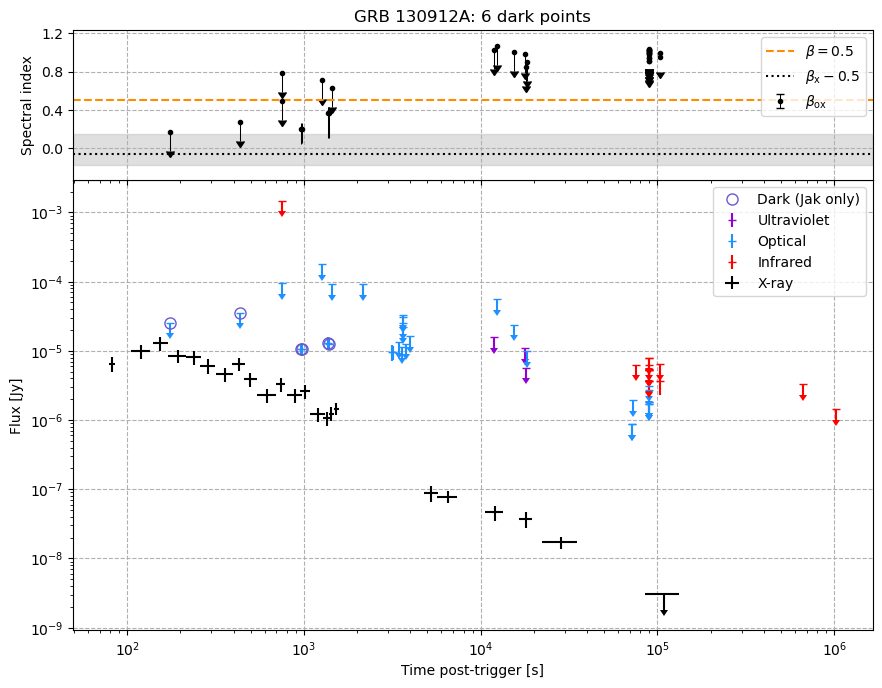

GRB       t_o       dt%  \
2485  130912A     174.0  0.097581   
2486  130912A     436.0  0.014383   
2488  130912A     756.0  0.021285   
2490  130912A     756.0  0.021285   
2493  130912A     960.0  0.055932   
2495  130912A     972.0  0.044131   
2497  130912A    1260.0  0.048603   
2502  130912A    1368.0  0.018486   
2506  130912A    1380.0  0.027420   
2511  130912A    1440.0  0.006277   
2513  130912A   11843.0  0.016180   
2514  130912A   12312.0  0.022781   
2515  130912A   15518.0  0.138390   
2516  130912A   17835.5  0.009715   
2517  130912A   18099.0  0.004916   
2518  130912A   18273.5  0.014604   
2519  130912A   89280.0  0.180952   
2520  130912A   89280.0  0.180952   
2521  130912A   89280.0  0.180952   
2522  130912A   89280.0  0.180952   
2523  130912A   89280.0  0.180952   
2524  130912A   89280.0  0.180952   
2525  130912A   89442.0  0.179466   
2526  130912A   89442.0  0.179466   
2527  130912A   89442.0  0.179466   
2528  130912A   89442.0  0.179466   
2529  130912A   89442.0  0.179466   
2530  130912A   89442.0  0.179466   
2531  130912A   89856.0  0.175668   
2532  130912A   89856.0  0.175668   
2533  130912A   89856.0  0.175668   
2534  130912A  103680.0  0.048848   
2535  130912A  103680.0  0.048848   

                                             B_ox_w_err                  B_x  \
2485   0.17469806075059513 (+0.04296237884195829, -inf)  0.44 (+0.21, -0.11)   
2486   0.27710995138531946 (+0.05124674465275889, -inf)  0.44 (+0.21, -0.11)   
2488     0.498403604536854 (+0.07107055889575084, -inf)  0.44 (+0.21, -0.11)   
2490    0.7910022730423077 (+0.09062556916625857, -inf)  0.44 (+0.21, -0.11)   
2493  0.20673641485801725 (+0.061087462688075155, -0...  0.44 (+0.21, -0.11)   
2495  0.20607087206569014 (+0.05833002401703142, -0....  0.44 (+0.21, -0.11)   
2497     0.7125898447058443 (+0.0949311375006642, -inf)  0.44 (+0.21, -0.11)   
2502  0.36902922012024353 (+0.0646362100262244, -0.2...  0.44 (+0.21, -0.11)   
2506  0.3660680269309475 (+0.06461608223225399, -0.2...  0.44 (+0.21, -0.11)   
2511    0.6331371850569513 (+0.08372954775774044, -inf)  0.44 (+0.21, -0.11)   
2513    1.0262458751785455 (+0.15592848487092512, -inf)  0.44 (+0.21, -0.11)   
2514    1.0726813334922514 (+0.13952511163954928, -inf)  0.44 (+0.21, -0.11)   
2515    1.0080624898441168 (+0.15905519977008806, -inf)  0.44 (+0.21, -0.11)   
2516    0.9868826724602745 (+0.14892229377503743, -inf)  0.44 (+0.21, -0.11)   
2517    0.8500057740964203 (+0.12627298568899908, -inf)  0.44 (+0.21, -0.11)   
2518    0.8998651238423977 (+0.12730931322520947, -inf)  0.44 (+0.21, -0.11)   
2519                            0.943795038246798 ± inf  0.44 (+0.21, -0.11)   
2520                           0.9071824200824065 ± inf  0.44 (+0.21, -0.11)   
2521                           0.9997913382877329 ± inf  0.44 (+0.21, -0.11)   
2522                            1.033748349035115 ± inf  0.44 (+0.21, -0.11)   
2523                           1.0006212504628436 ± inf  0.44 (+0.21, -0.11)   
2524                           1.0174941064907135 ± inf  0.44 (+0.21, -0.11)   
2525                           0.9478678456711476 ± inf  0.44 (+0.21, -0.11)   
2526                            0.910581913979418 ± inf  0.44 (+0.21, -0.11)   
2527                           0.9973131927875805 ± inf  0.44 (+0.21, -0.11)   
2528                           1.0279997349045287 ± inf  0.44 (+0.21, -0.11)   
2529                             1.00003721354338 ± inf  0.44 (+0.21, -0.11)   
2530                           1.0203789973484438 ± inf  0.44 (+0.21, -0.11)   
2531                           1.0283035393026794 ± inf  0.44 (+0.21, -0.11)   
2532                            0.975438200435569 ± inf  0.44 (+0.21, -0.11)   
2533                            1.024730150773578 ± inf  0.44 (+0.21, -0.11)   
2534      0.949950105198353 (+inf, -0.6103666594625996)  0.44 (+0.21, -0.11)   
2535                           0.9922238075116937 ± inf  0.44 (+0.21, -0.11)   

          α Jak_dark vdH_dark 

3 0 1


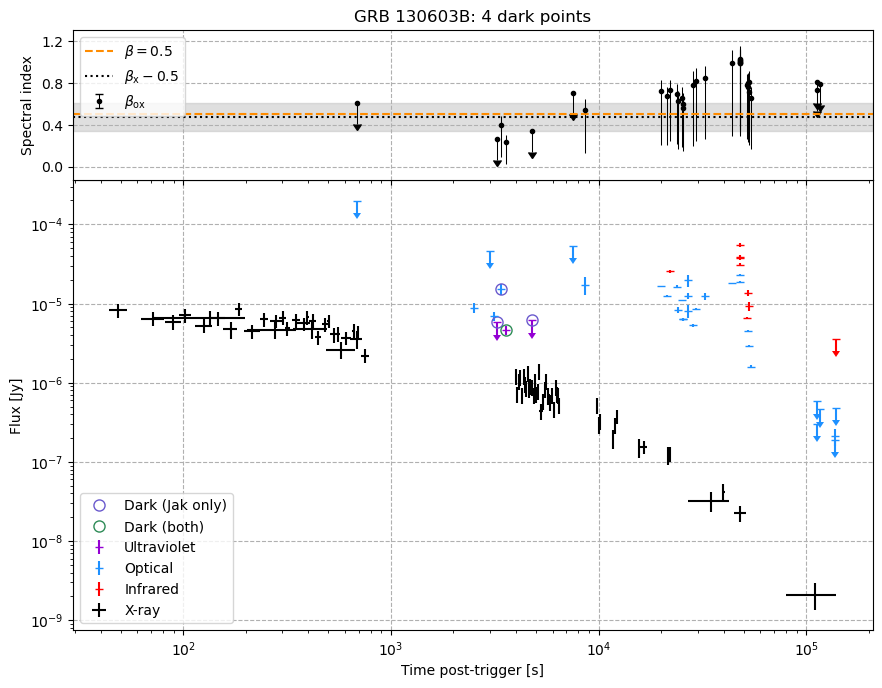

GRB       t_o       dt%  \
2541  130603B     684.0  0.002010   
2544  130603B    3228.0  0.192008   
2545  130603B    3371.0  0.156214   
2549  130603B    3567.5  0.107029   
2567  130603B    4778.5  0.003995   
2581  130603B    7560.0  0.166473   
2582  130603B    8640.0  0.122872   
2585  130603B   19966.0  0.071671   
2587  130603B   21240.0  0.012436   
2590  130603B   21960.0  0.000325   
2592  130603B   23760.0  0.081616   
2594  130603B   24120.0  0.098004   
2596  130603B   25200.0  0.147168   
2598  130603B   25560.0  0.163556   
2600  130603B   25560.0  0.163556   
2601  130603B   28440.0  0.182735   
2602  130603B   29520.0  0.151699   
2603  130603B   32400.0  0.068938   
2606  130603B   43920.0  0.086440   
2607  130603B   48222.0  0.003044   
2608  130603B   48222.0  0.003044   
2609  130603B   48222.0  0.003044   
2610  130603B   48222.0  0.003044   
2611  130603B   48222.0  0.003044   
2612  130603B   48222.0  0.003044   
2613  130603B   51840.0  0.078301   
2614  130603B   52200.0  0.085789   
2615  130603B   52560.0  0.093277   
2616  130603B   52920.0  0.100765   
2617  130603B   53280.0  0.108254   
2618  130603B   54000.0  0.123230   
2619  130603B  112320.0  0.022837   
2620  130603B  112320.0  0.022837   
2621  130603B  115920.0  0.055620   

                                             B_ox_w_err                  B_x  \
2541    0.6078781263385069 (+0.08355372447295904, -inf)  0.97 (+0.14, -0.13)   
2544   0.26394949664177414 (+0.09270423714248009, -inf)  0.97 (+0.14, -0.13)   
2545  0.3960732673214488 (+0.09202276246160318, -0.3...  0.97 (+0.14, -0.13)   
2549  0.23472142341616253 (+0.07196853096636335, -0....  0.97 (+0.14, -0.13)   
2567    0.3388014195293753 (+0.06297704697217059, -inf)  0.97 (+0.14, -0.13)   
2581    0.6998160746654591 (+0.11489984391839136, -inf)  0.97 (+0.14, -0.13)   
2582  0.5438911622301633 (+0.10182022839295, -0.4111...  0.97 (+0.14, -0.13)   
2585  0.7240281151065281 (+0.10125926241914775, -0.5...  0.97 (+0.14, -0.13)   
2587  0.6749244162748006 (+0.09023153270581252, -0.4...  0.97 (+0.14, -0.13)   
2590  0.733617343661548 (+0.08992005192332252, -0.48...  0.97 (+0.14, -0.13)   
2592  0.6962934580612733 (+0.09519952753985106, -0.4...  0.97 (+0.14, -0.13)   
2594  0.6307979253794036 (+0.09579595077918603, -0.4...  0.97 (+0.14, -0.13)   
2596  0.6563200783582868 (+0.10504443316761983, -0.4...  0.97 (+0.14, -0.13)   
2598  0.5597621866874678 (+0.09917280626187328, -0.3...  0.97 (+0.14, -0.13)   
2600  0.5988969569354411 (+0.10659137357029777, -0.4...  0.97 (+0.14, -0.13)   
2601  0.7848700359066813 (+0.13057452516789403, -0.5...  0.97 (+0.14, -0.13)   
2602  0.8170568987176035 (+0.12290305777781196, -0.5...  0.97 (+0.14, -0.13)   
2603  0.8495881373526624 (+0.11232269034674307, -0.5...  0.97 (+0.14, -0.13)   
2606  0.9882600946421588 (+0.1305096009476505, -0.69...  0.97 (+0.14, -0.13)   
2607  0.9929427727910082 (+0.12630435934017228, -0.7...  0.97 (+0.14, -0.13)   
2608  0.9967923134119577 (+0.12306521265262474, -0.6...  0.97 (+0.14, -0.13)   
2609  1.015606535995575 (+0.12261105318316584, -0.68...  0.97 (+0.14, -0.13)   
2610  1.027401035754334 (+0.1214338295386464, -0.676...  0.97 (+0.14, -0.13)   
2611  0.9953294612075222 (+0.11481899355904215, -0.6...  0.97 (+0.14, -0.13)   
2612  1.0114406539775094 (+0.11262294905834268, -0.6...  0.97 (+0.14, -0.13)   
2613  0.78517069178922 (+0.10104090058829607, -0.521...  0.97 (+0.14, -0.13)   
2614  0.7981488637810475 (+0.09484883820105608, -0.4...  0.97 (+0.14, -0.13)   
2615  0.75729687839666 (+0.10305064034430474, -0.519...  0.97 (+0.14, -0.13)   
2616  0.8066982658750247 (+0.10501251124397502, -0.5...  0.97 (+0.14, -0.13)   
2617  0.7163490752273707 (+0.10392007083467034, -0.5...  0.97 (+0.14, -0.13)   
2618  0.655956846421642 (+0.10396813995947965, -0.48...  0.97 (+0.14, -0.13)   
2619    0.7341276574976692 (+0.10296883918066316, -inf)  0.97 (+0.14, -0.13)   
2620    0.8064711787908835 (+0.10743470387894533, -inf)  0.97 (+0.14, -0.1

no Infrared for GRB 121226A
0 0 1


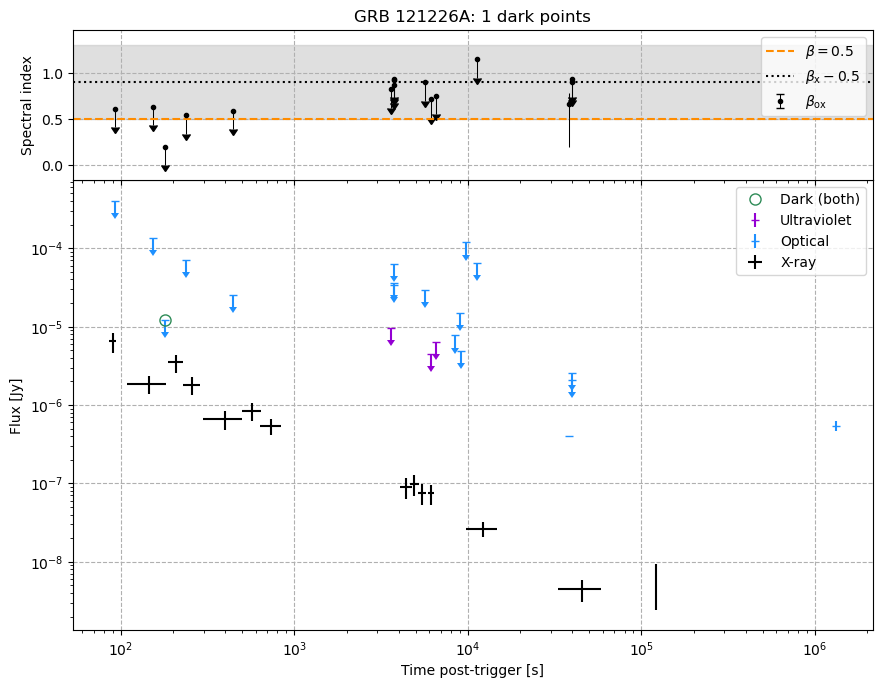

GRB        t_o       dt%  \
2624  121226A     92.800  0.030875   
2625  121226A    153.000  0.046626   
2626  121226A    179.000  0.134643   
2628  121226A    236.500  0.080764   
2629  121226A    441.500  0.104418   
2630  121226A   3621.000  0.175880   
2631  121226A   3743.712  0.147952   
2632  121226A   3743.712  0.147952   
2633  121226A   3743.712  0.147952   
2635  121226A   5681.000  0.038000   
2638  121226A   6146.000  0.004162   
2640  121226A   6543.000  0.069026   
2641  121226A  11301.120  0.077224   
2642  121226A  38520.000  0.153678   
2643  121226A  39906.000  0.123226   
2644  121226A  39960.000  0.122040   

                                             B_ox_w_err        B_x     α  \
2624    0.6088156090616437 (+0.08634601238084468, -inf)  1.4 ± 0.4  1.04   
2625    0.6303637742096536 (+0.08768682196571949, -inf)  1.4 ± 0.4  1.04   
2626   0.19939931994173682 (+0.07480697875377806, -inf)  1.4 ± 0.4  1.04   
2628    0.5374465578628711 (+0.08352019371841622, -inf)  1.4 ± 0.4  1.04   
2629     0.5902808936152806 (+0.1000999711816809, -inf)  1.4 ± 0.4  1.04   
2630      0.819561402244027 (+0.1494082939073408, -inf)  1.4 ± 0.4  1.04   
2631    0.9206772890969991 (+0.14040353908743852, -inf)  1.4 ± 0.4  1.04   
2632     0.8689430854563214 (+0.1300066480569974, -inf)  1.4 ± 0.4  1.04   
2633    0.9331795411056737 (+0.13347299830470952, -inf)  1.4 ± 0.4  1.04   
2635    0.8995901556082243 (+0.12195093387344962, -inf)  1.4 ± 0.4  1.04   
2638    0.7141985260686586 (+0.11486873541557231, -inf)  1.4 ± 0.4  1.04   
2640    0.7499126691477578 (+0.11973299743054248, -inf)  1.4 ± 0.4  1.04   
2641     1.1494055243936507 (+0.1475280687028564, -inf)  1.4 ± 0.4  1.04   
2642  0.6666602519593108 (+0.11410189504339434, -0.4...  1.4 ± 0.4  1.04   
2643     0.9354663179429547 (+0.1339511477807303, -inf)  1.4 ± 0.4  1.04   
2644     0.9035027849596424 (+0.1301357925455047, -inf)  1.4 ± 0.4  1.04   

     Jak_dark vdH_dark  
2624    False    False  
2625    False    False  
2626     True     True  
2628    False    False  
2629    False    False  
2630    False    False  
2631    False    False  
2632    False    False  
2633    False    False  
2635    False    False  
2638    False    False  
2640    False    False  
2641    False    False  
2642    False    False  
2643    False    False  
2644    False    False

2 0 1


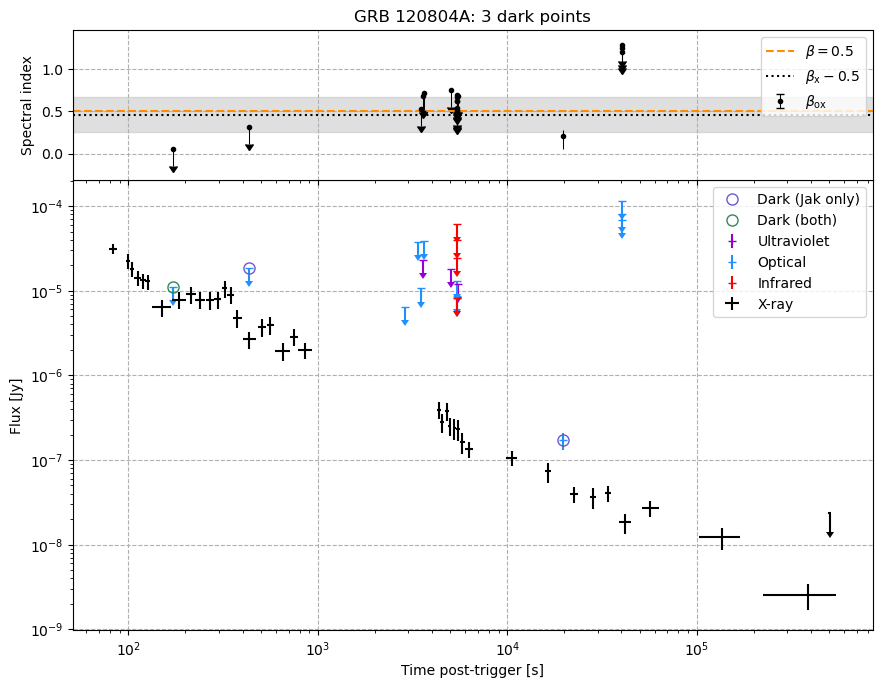

GRB       t_o       dt%  \
2646  120804A    172.00  0.074672   
2649  120804A    435.00  0.000324   
2651  120804A   3501.00  0.193322   
2652  120804A   3588.00  0.173276   
2653  120804A   3636.00  0.162216   
2658  120804A   5054.50  0.016340   
2667  120804A   5400.00  0.020125   
2674  120804A   5400.00  0.020125   
2681  120804A   5400.00  0.020125   
2688  120804A   5400.00  0.020125   
2695  120804A   5400.00  0.020125   
2702  120804A   5400.00  0.020125   
2709  120804A   5400.00  0.020125   
2715  120804A   5464.00  0.008512   
2718  120804A  19800.00  0.123502   
2720  120804A  40249.44  0.043178   
2722  120804A  40249.44  0.043178   
2724  120804A  40249.44  0.043178   

                                             B_ox_w_err                 B_x  \
2646  0.05628116489174747 (+0.049977210728545204, -inf)  0.96 (+0.21, -0.2)   
2649   0.31298462658694176 (+0.05647329959621704, -inf)  0.96 (+0.21, -0.2)   
2651     0.532231975641372 (+0.11610754227675377, -inf)  0.96 (+0.21, -0.2)   
2652     0.6874287498907186 (+0.1283596778443477, -inf)  0.96 (+0.21, -0.2)   
2653    0.7149064339965683 (+0.12208306764084416, -inf)  0.96 (+0.21, -0.2)   
2658    0.7542519044996243 (+0.11814123922088558, -inf)  0.96 (+0.21, -0.2)   
2667     0.6279922299632165 (+0.0915233617193176, -inf)  0.96 (+0.21, -0.2)   
2674     0.5365316167903782 (+0.0777822415319965, -inf)  0.96 (+0.21, -0.2)   
2681    0.5120406906452821 (+0.07291625911560846, -inf)  0.96 (+0.21, -0.2)   
2688     0.501814866425329 (+0.07031722615543273, -inf)  0.96 (+0.21, -0.2)   
2695     0.626452389793607 (+0.07921926873258009, -inf)  0.96 (+0.21, -0.2)   
2702    0.6670276253969813 (+0.08014899505568897, -inf)  0.96 (+0.21, -0.2)   
2709    0.6974654555429578 (+0.08022019242947577, -inf)  0.96 (+0.21, -0.2)   
2715    0.6876323434424885 (+0.10979195808699499, -inf)  0.96 (+0.21, -0.2)   
2718  0.20771521169885515 (+0.07555282701288185, -0....  0.96 (+0.21, -0.2)   
2720    1.2915571486591046 (+0.17087078001922076, -inf)  0.96 (+0.21, -0.2)   
2722     1.2083984399538599 (+0.1532991349541685, -inf)  0.96 (+0.21, -0.2)   
2724      1.25023728503006 (+0.15391740187753122, -inf)  0.96 (+0.21, -0.2)   

          α Jak_dark vdH_dark  
2646  1.095     True     True  
2649  1.095     True    False  
2651  1.095    False    False  
2652  1.095    False    False  
2653  1.095    False    False  
2658  1.095    False    False  
2667  1.095    False    False  
2674  1.095    False    False  
2681  1.095    False    False  
2688  1.095    False    False  
2695  1.095    False    False  
2702  1.095    False    False  
2709  1.095    False    False  
2715  1.095    False    False  
2718  1.095     True    False  
2720  1.095    False    False  
2722  1.095    False    False  
2724  1.095    False    False

1 0 0


C:\Users\cgobat\Miniconda3\envs\dev\lib\site-packages\matplotlib\axes\_axes.py:3601: RuntimeWarning: invalid value encountered in scalar multiply
  low, high = dep + np.row_stack([-(1 - lolims), 1 - uplims]) * err
C:\Users\cgobat\Miniconda3\envs\dev\lib\site-packages\matplotlib\axes\_axes.py:3601: RuntimeWarning: invalid value encountered in multiply
  low, high = dep + np.row_stack([-(1 - lolims), 1 - uplims]) * err


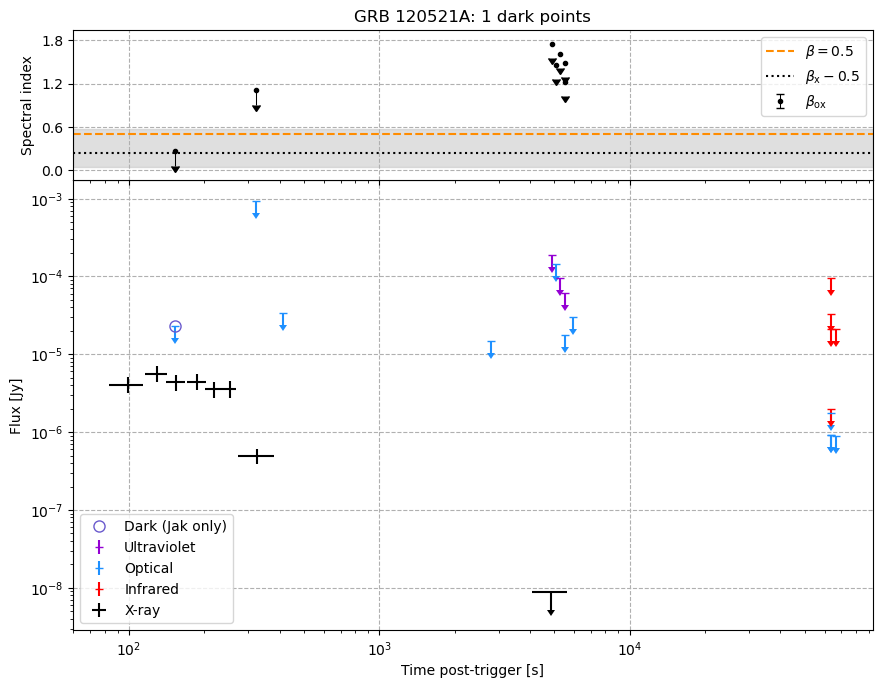

GRB     t_o       dt%  \
2727  120521A   152.0  0.012795   
2729  120521A   321.0  0.013864   
2730  120521A  4879.0  0.006462   
2731  120521A  5083.5  0.048647   
2732  120521A  5288.0  0.090832   
2733  120521A  5494.0  0.133327   
2734  120521A  5532.0  0.141166   

                                           B_ox_w_err                  B_x  \
2727  0.2651610920387164 (+0.05125032743714506, -inf)  0.74 (+0.33, -0.19)   
2729  1.1111432242080963 (+0.13879044173992963, -inf)  0.74 (+0.33, -0.19)   
2730                         1.7568717774256508 ± inf  0.74 (+0.33, -0.19)   
2731                         1.4646922793488397 ± inf  0.74 (+0.33, -0.19)   
2732                         1.6182471864659689 ± inf  0.74 (+0.33, -0.19)   
2733                          1.492644526512864 ± inf  0.74 (+0.33, -0.19)   
2734                          1.229591418162971 ± inf  0.74 (+0.33, -0.19)   

         α Jak_dark vdH_dark  
2727  1.81     True    False  
2729  1.81    False    False  
2730  1.81    False    False  
2731  1.81    False    False  
2732  1.81    False    False  
2733  1.81    False    False  
2734  1.81    False    False

no Infrared for GRB 120305A
0 0 2


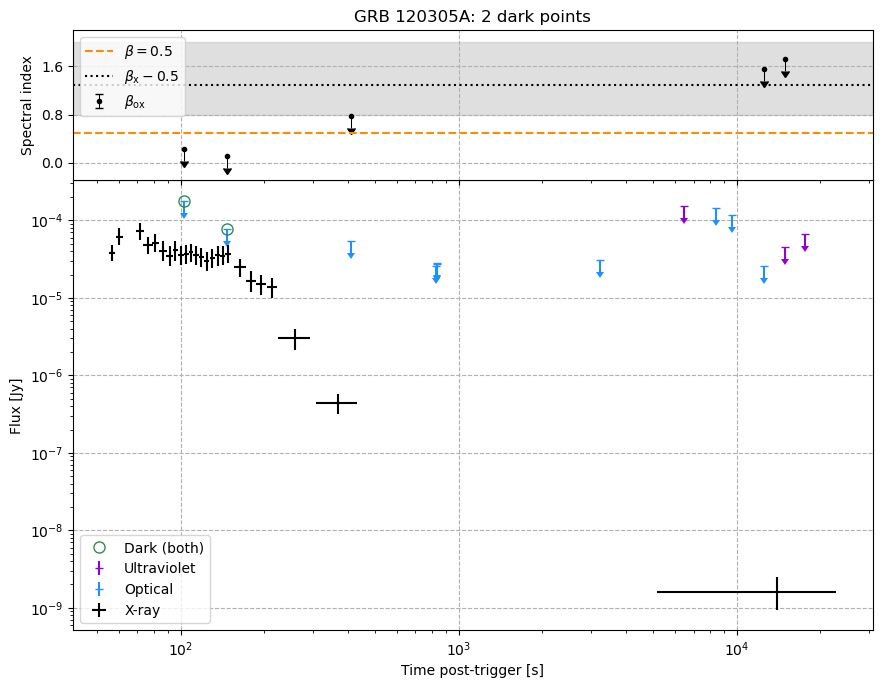

GRB      t_o       dt%  \
2739  120305A    102.6  0.021263   
2748  120305A    146.5  0.013328   
2751  120305A    409.0  0.106261   
2752  120305A  12591.0  0.101245   
2753  120305A  14927.5  0.065536   

                                            B_ox_w_err               B_x    α  \
2739  0.23434243239078842 (+0.04827035871211284, -inf)  1.8 (+0.7, -0.5)  1.0   
2748  0.11611174953625322 (+0.04256203635582089, -inf)  1.8 (+0.7, -0.5)  1.0   
2751   0.7777194093992553 (+0.12128596935904017, -inf)  1.8 (+0.7, -0.5)  1.0   
2752    1.5609192566850651 (+0.2227260987460595, -inf)  1.8 (+0.7, -0.5)  1.0   
2753     1.730362545660643 (+0.2528787778542496, -inf)  1.8 (+0.7, -0.5)  1.0   

     Jak_dark vdH_dark  
2739     True     True  
2748     True     True  
2751    False    False  
2752    False    False  
2753    False    False

2 0 0


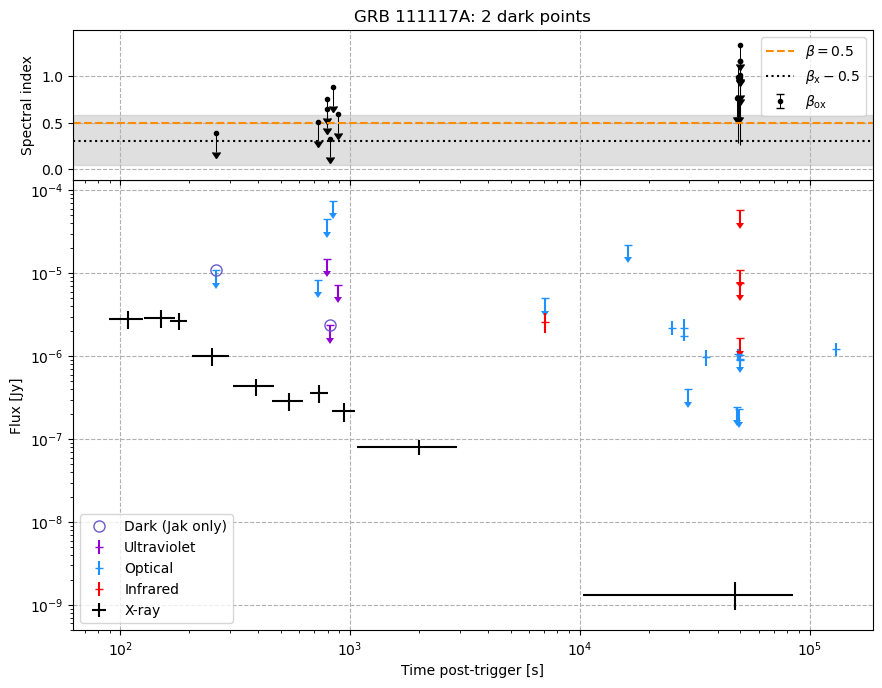

GRB         t_o       dt%  \
2799  111117A    262.0000  0.043833   
2800  111117A    726.0000  0.011143   
2801  111117A    791.5000  0.078072   
2803  111117A    792.5000  0.079434   
2805  111117A    818.0000  0.114167   
2808  111117A    842.0000  0.108830   
2809  111117A    891.5000  0.056439   
2810  111117A  48427.0272  0.019914   
2811  111117A  48600.0000  0.023557   
2812  111117A  49320.0000  0.038721   
2813  111117A  49680.0000  0.046303   
2814  111117A  49680.0000  0.046303   
2815  111117A  49680.0000  0.046303   
2816  111117A  49680.0000  0.046303   
2817  111117A  49680.0000  0.046303   
2818  111117A  49680.0000  0.046303   
2819  111117A  49680.0000  0.046303   

                                             B_ox_w_err                  B_x  \
2799   0.38706480251364117 (+0.06888011495291142, -inf)  0.81 (+0.28, -0.26)   
2800    0.5088932562888739 (+0.07849801582038748, -inf)  0.81 (+0.28, -0.26)   
2801    0.7550956013380711 (+0.11237097529061538, -inf)  0.81 (+0.28, -0.26)   
2803    0.6503343157041593 (+0.11085752057587496, -inf)  0.81 (+0.28, -0.26)   
2805   0.33182312259249325 (+0.08776164544688901, -inf)  0.81 (+0.28, -0.26)   
2808    0.8833383992334664 (+0.13017425857192935, -inf)  0.81 (+0.28, -0.26)   
2809        0.59461976811368 (+0.098715572429902, -inf)  0.81 (+0.28, -0.26)   
2810    0.7693421626874186 (+0.10704199877366835, -inf)  0.81 (+0.28, -0.26)   
2811  0.9891221546710485 (+0.13324229113741304, -0.7...  0.81 (+0.28, -0.26)   
2812    0.7592232310169111 (+0.10725550571405722, -inf)  0.81 (+0.28, -0.26)   
2813  1.0165547863228062 (+0.14445713912012306, -0.7...  0.81 (+0.28, -0.26)   
2814  0.9662313059713475 (+0.1328560834877379, -0.68...  0.81 (+0.28, -0.26)   
2815     0.9567035747520519 (+0.1260298072929602, -inf)  0.81 (+0.28, -0.26)   
2816      0.9982393755242693 (+0.127655962584992, -inf)  0.81 (+0.28, -0.26)   
2817    1.1642555488940023 (+0.13936334929825384, -inf)  0.81 (+0.28, -0.26)   
2818       1.16758267185855 (+0.1346760187024561, -inf)  0.81 (+0.28, -0.26)   
2819    1.3336105740426225 (+0.14618541485691078, -inf)  0.81 (+0.28, -0.26)   

         α Jak_dark vdH_dark  
2799  1.27     True    False  
2800  1.27    False    False  
2801  1.27    False    False  
2803  1.27    False    False  
2805  1.27     True    False  
2808  1.27    False    False  
2809  1.27    False    False  
2810  1.27    False    False  
2811  1.27    False    False  
2812  1.27    False    False  
2813  1.27    False    False  
2814  1.27    False    False  
2815  1.27    False    False  
2816  1.27    False    False  
2817  1.27    False    False  
2818  1.27    False    False  
2819  1.27    False    False

0 0 1


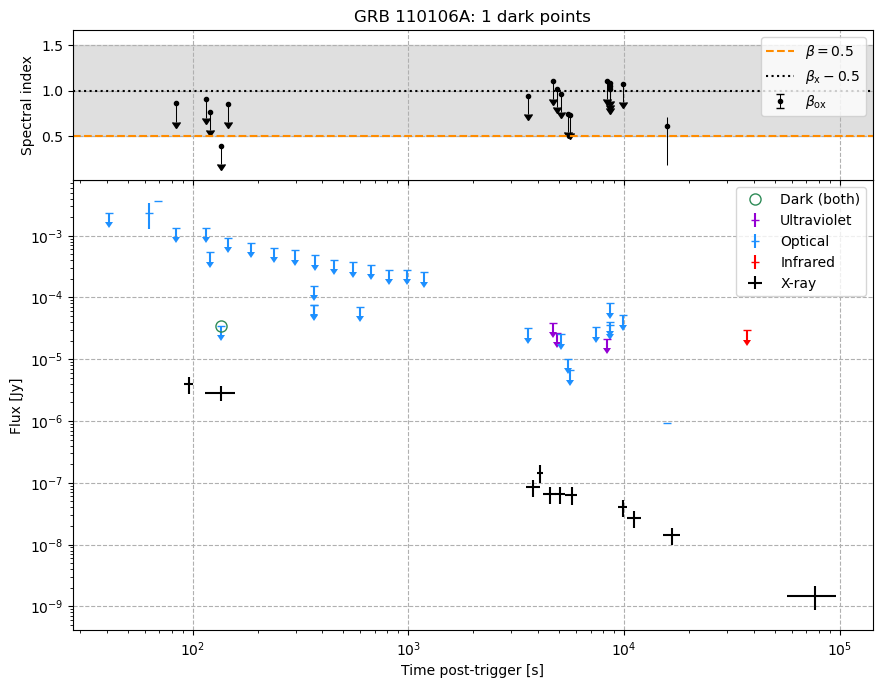

GRB        t_o       dt%  \
2861  110106A     84.000  0.122100   
2862  110106A    115.000  0.150313   
2863  110106A    120.000  0.113370   
2864  110106A    136.000  0.004847   
2865  110106A    146.000  0.078733   
2866  110106A   3605.000  0.050843   
2869  110106A   4710.500  0.038750   
2873  110106A   4915.500  0.029071   
2876  110106A   5120.500  0.011421   
2879  110106A   5527.872  0.033575   
2881  110106A   5652.000  0.011874   
2882  110106A   8317.500  0.158478   
2883  110106A   8584.704  0.131444   
2884  110106A   8584.704  0.131444   
2885  110106A   8584.704  0.131444   
2886  110106A   9866.500  0.001758   
2888  110106A  15876.000  0.048811   

                                             B_ox_w_err        B_x     α  \
2861    0.8593080495883408 (+0.12634664443018587, -inf)  1.5 ± 0.5  1.11   
2862    0.9035345136400693 (+0.13520827245097633, -inf)  1.5 ± 0.5  1.11   
2863    0.7696124028752046 (+0.11452894340993054, -inf)  1.5 ± 0.5  1.11   
2864    0.3955148107219521 (+0.06799658258436435, -inf)  1.5 ± 0.5  1.11   
2865    0.8493401222200034 (+0.11684943222248267, -inf)  1.5 ± 0.5  1.11   
2866    0.9391780818777056 (+0.13489929713373555, -inf)  1.5 ± 0.5  1.11   
2869    1.1105084963677918 (+0.16967385517973407, -inf)  1.5 ± 0.5  1.11   
2873    1.0142646162651325 (+0.15146128137271167, -inf)  1.5 ± 0.5  1.11   
2876    0.9614914061376749 (+0.13775315433323715, -inf)  1.5 ± 0.5  1.11   
2879    0.7456140577600381 (+0.10277377801243866, -inf)  1.5 ± 0.5  1.11   
2881    0.7369708077609889 (+0.10875178530093245, -inf)  1.5 ± 0.5  1.11   
2882    1.1064968854260988 (+0.18455971661089898, -inf)  1.5 ± 0.5  1.11   
2883      1.04626862051361 (+0.15374585570132585, -inf)  1.5 ± 0.5  1.11   
2884     1.013589174375667 (+0.14425501864699544, -inf)  1.5 ± 0.5  1.11   
2885    1.0863205719340059 (+0.14835635242498094, -inf)  1.5 ± 0.5  1.11   
2886     1.0767428033505129 (+0.1423776610053139, -inf)  1.5 ± 0.5  1.11   
2888  0.6147052041805736 (+0.08951424103372473, -0.4...  1.5 ± 0.5  1.11   

     Jak_dark vdH_dark  
2861    False    False  
2862    False    False  
2863    False    False  
2864     True     True  
2865    False    False  
2866    False    False  
2869    False    False  
2873    False    False  
2876    False    False  
2879    False    False  
2881    False    False  
2882    False    False  
2883    False    False  
2884    False    False  
2885    False    False  
2886    False    False  
2888    False    False

1 0 0


C:\Users\cgobat\Miniconda3\envs\dev\lib\site-packages\matplotlib\axes\_axes.py:3601: RuntimeWarning: invalid value encountered in scalar multiply
  low, high = dep + np.row_stack([-(1 - lolims), 1 - uplims]) * err
C:\Users\cgobat\Miniconda3\envs\dev\lib\site-packages\matplotlib\axes\_axes.py:3601: RuntimeWarning: invalid value encountered in multiply
  low, high = dep + np.row_stack([-(1 - lolims), 1 - uplims]) * err


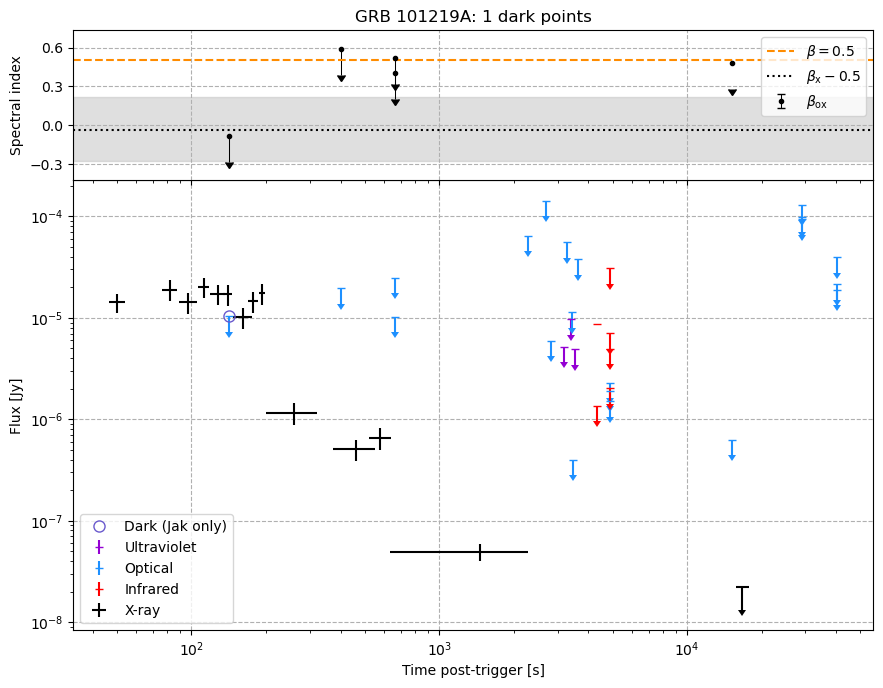

GRB      t_o       dt%  \
2890  101219A    142.0  0.013309   
2893  101219A    403.5  0.125461   
2894  101219A    666.0  0.149386   
2895  101219A    666.0  0.149386   
2896  101219A  15120.0  0.094377   

                                             B_ox_w_err                  B_x  \
2890  -0.08032539371266008 (+0.040495150670132395, -...  0.46 (+0.26, -0.24)   
2893     0.591046242916151 (+0.12275979249258792, -inf)  0.46 (+0.26, -0.24)   
2894   0.40475941311911723 (+0.11768598580283707, -inf)  0.46 (+0.26, -0.24)   
2895    0.5184465105342154 (+0.12281553305501818, -inf)  0.46 (+0.26, -0.24)   
2896                           0.4797443688796422 ± inf  0.46 (+0.26, -0.24)   

         α Jak_dark vdH_dark  
2890  1.67     True    False  
2893  1.67    False    False  
2894  1.67    False    False  
2895  1.67    False    False  
2896  1.67    False    False

1 0 0


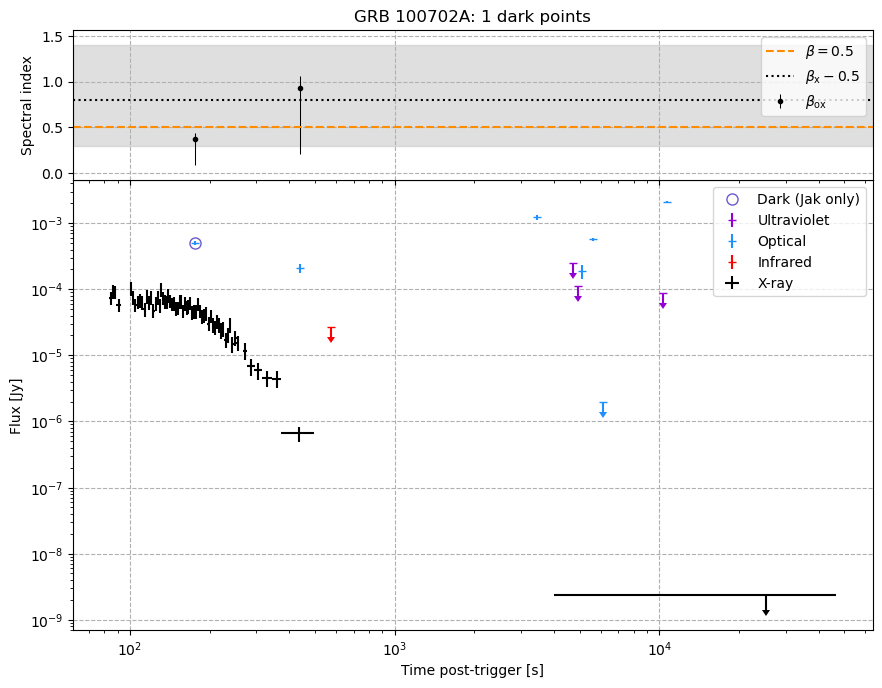

GRB    t_o       dt%  \
2967  100702A  176.0  0.004050   
2980  100702A  439.0  0.011283   

                                             B_ox_w_err               B_x  \
2967  0.3762568652979101 (+0.062115099329621296, -0....  1.3 (+0.6, -0.5)   
2980  0.9281497760085539 (+0.13338508778982908, -0.7...  1.3 (+0.6, -0.5)   

        α Jak_dark vdH_dark  
2967  2.9     True    False  
2980  2.9    False    False

0 1 1


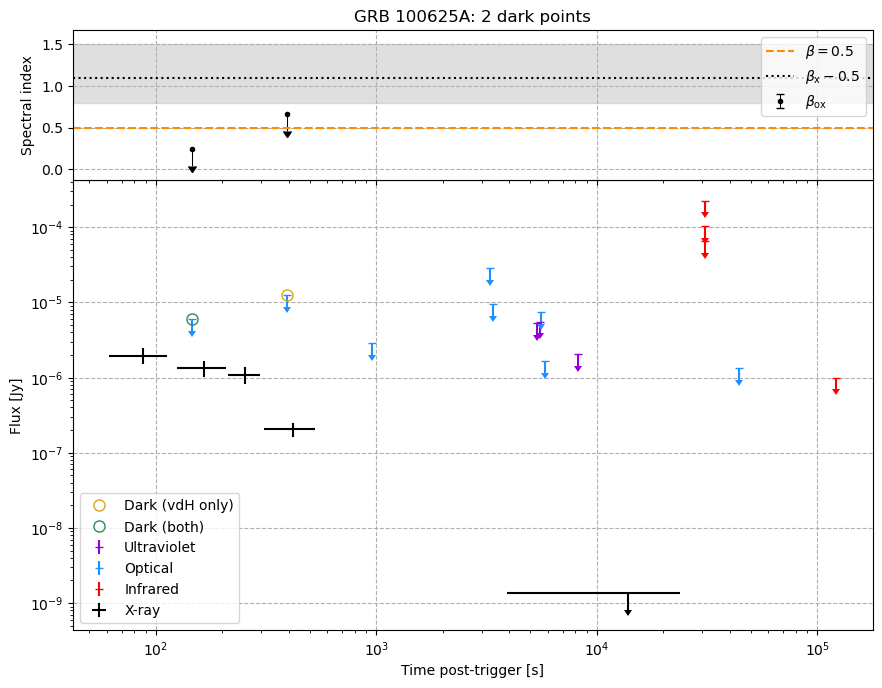

GRB    t_o       dt%  \
2981  100625A  146.5  0.118304   
2982  100625A  394.0  0.059538   

                                            B_ox_w_err               B_x  \
2981  0.23921578602800378 (+0.08643968662355281, -inf)  1.6 (+0.4, -0.3)   
2982    0.661307473055828 (+0.10092550933649871, -inf)  1.6 (+0.4, -0.3)   

         α Jak_dark vdH_dark  
2981  1.45     True     True  
2982  1.45    False     True

no Infrared for GRB 100117A
0 0 1


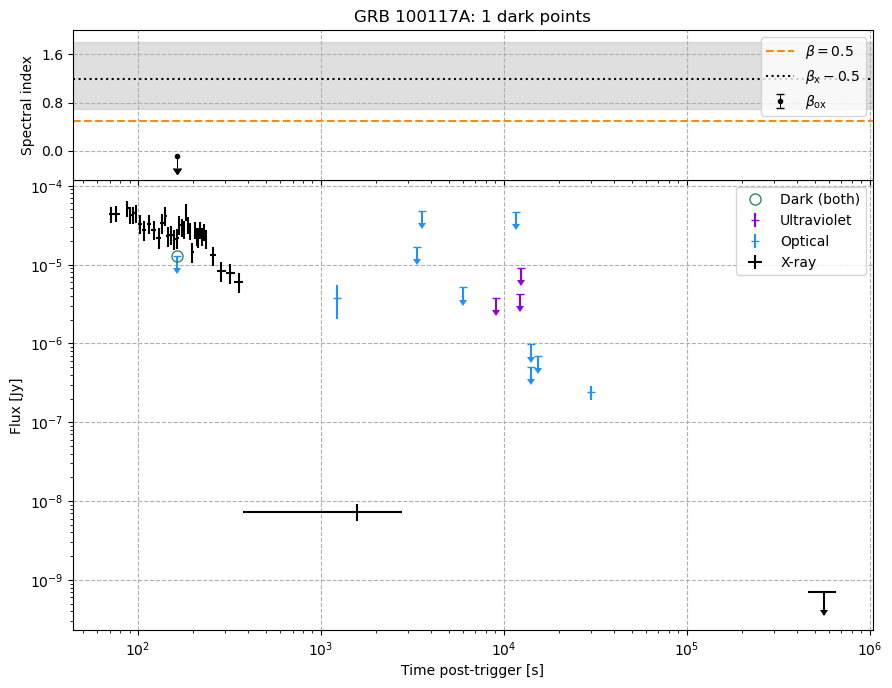

GRB    t_o       dt%  \
2991  100117A  163.5  0.003735   

                                             B_ox_w_err               B_x  \
2991  -0.08384044747938296 (+0.04582344545091656, -inf)  1.7 (+0.6, -0.5)   

        α Jak_dark vdH_dark  
2991  1.0     True     True

0 0 1


C:\Users\cgobat\Miniconda3\envs\dev\lib\site-packages\matplotlib\axes\_axes.py:3601: RuntimeWarning: invalid value encountered in scalar multiply
  low, high = dep + np.row_stack([-(1 - lolims), 1 - uplims]) * err
C:\Users\cgobat\Miniconda3\envs\dev\lib\site-packages\matplotlib\axes\_axes.py:3601: RuntimeWarning: invalid value encountered in multiply
  low, high = dep + np.row_stack([-(1 - lolims), 1 - uplims]) * err


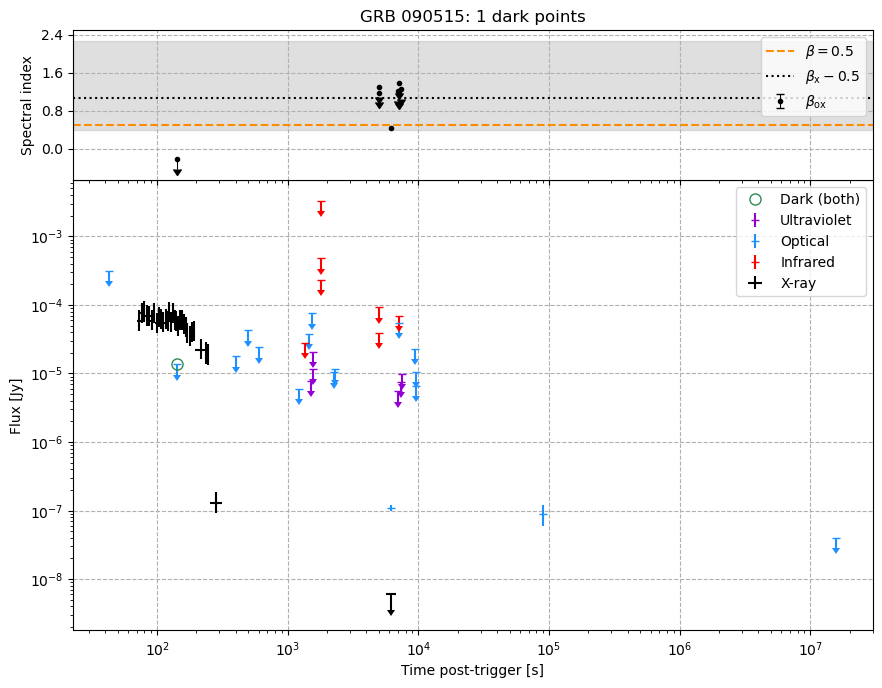

GRB     t_o       dt%  \
3013  090515   141.5  0.007089   
3020  090515  5040.0  0.187907   
3021  090515  5040.0  0.187907   
3022  090515  6120.0  0.013888   
3023  090515  6924.5  0.115741   
3024  090515  7129.0  0.148692   
3025  090515  7140.0  0.150464   
3026  090515  7333.5  0.181643   

                                             B_ox_w_err                  B_x  \
3013  -0.2287223009743839 (+0.054861877896981576, -inf)  1.57 (+1.19, -0.68)   
3020                            1.293431540632887 ± inf  1.57 (+1.19, -0.68)   
3021                            1.178400032404398 ± inf  1.57 (+1.19, -0.68)   
3022     0.4300818397269228 (+inf, -0.3098806896917142)  1.57 (+1.19, -0.68)   
3023                           1.2051310399812327 ± inf  1.57 (+1.19, -0.68)   
3024                           1.3767661920129626 ± inf  1.57 (+1.19, -0.68)   
3025                           1.1699398662176843 ± inf  1.57 (+1.19, -0.68)   
3026                           1.2445968746052147 ± inf  1.57 (+1.19, -0.68)   

         α Jak_dark vdH_dark  
3013  4.49     True     True  
3020  4.49    False    False  
3021  4.49    False    False  
3022  4.49    False    False  
3023  4.49    False    False  
3024  4.49    False    False  
3025  4.49    False    False  
3026  4.49    False    False

7 0 0


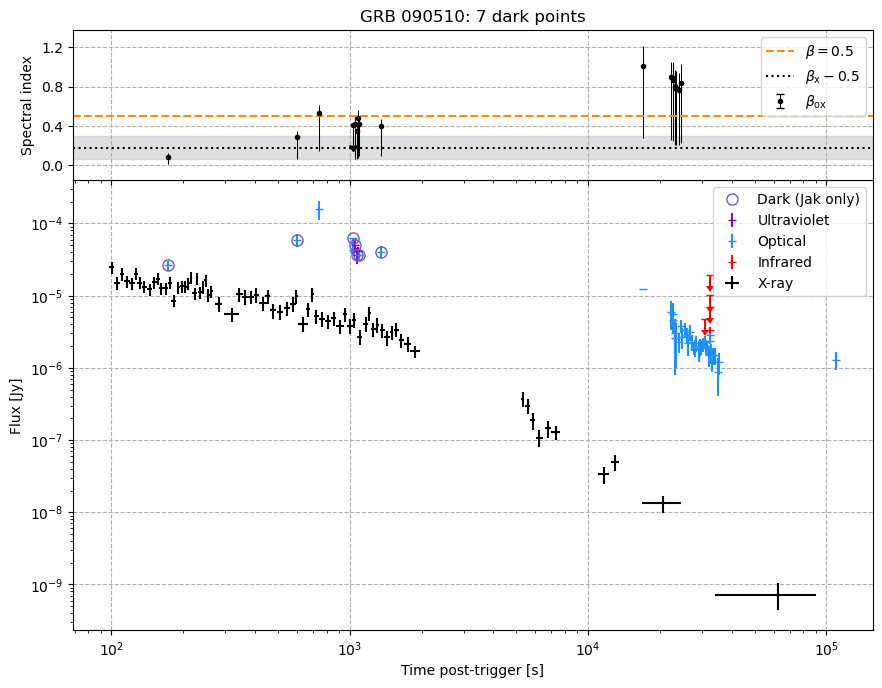

GRB      t_o       dt%  \
3032  090510    172.0  0.018360   
3041  090510    598.0  0.002051   
3050  090510    745.0  0.028477   
3057  090510   1033.0  0.011171   
3065  090510   1048.0  0.003188   
3074  090510   1069.5  0.023768   
3084  090510   1083.0  0.013953   
3093  090510   1094.5  0.003483   
3102  090510   1346.5  0.017940   
3107  090510  16920.0  0.182582   
3108  090510  22320.0  0.078296   
3109  090510  22680.0  0.095688   
3110  090510  22680.0  0.095688   
3111  090510  23040.0  0.113080   
3112  090510  23040.0  0.113080   
3113  090510  23400.0  0.130472   
3114  090510  24120.0  0.165255   
3115  090510  24480.0  0.182647   

                                             B_ox_w_err          B_x     α  \
3032  0.08784455192610077 (+0.04083739134265433, -0....  0.68 ± 0.12  0.66   
3041  0.2830830381506375 (+0.061043597051168914, -0....  0.68 ± 0.12  0.66   
3050  0.5286355783855248 (+0.08745686716508215, -0.3...  0.68 ± 0.12  0.66   
3057    0.4055768160779434 (+0.06336317724028344, -inf)  0.68 ± 0.12  0.66   
3065  0.4174284916801267 (+0.08014109114776327, -0.3...  0.68 ± 0.12  0.66   
3074  0.34726398313115825 (+0.07506029538187704, -0....  0.68 ± 0.12  0.66   
3084  0.47825224660054355 (+0.08570599257051385, -0....  0.68 ± 0.12  0.66   
3093  0.4205399973673835 (+0.07172437802329212, -0.3...  0.68 ± 0.12  0.66   
3102  0.3961574973703175 (+0.06958701930388769, -0.3...  0.68 ± 0.12  0.66   
3107  1.0097524933513828 (+0.20239001077715285, -0.7...  0.68 ± 0.12  2.14   
3108  0.9011947377451318 (+0.14996387322010746, -0.6...  0.68 ± 0.12  2.14   
3109  0.8908206311073994 (+0.15625128960035578, -0.6...  0.68 ± 0.12  2.14   
3110  0.8644152860935175 (+0.15015267634391702, -0.6...  0.68 ± 0.12  2.14   
3111  0.7801056827274128 (+0.17606986321294585, -0.5...  0.68 ± 0.12  2.14   
3112  0.8012517419542088 (+0.1699850622434121, -0.58...  0.68 ± 0.12  2.14   
3113  0.7801056827274128 (+0.17855276549395088, -0.5...  0.68 ± 0.12  2.14   
3114  0.7619886968428493 (+0.1802477891343109, -0.55...  0.68 ± 0.12  2.14   
3115  0.8361829902566151 (+0.19281818342770124, -0.6...  0.68 ± 0.12  2.14   

     Jak_dark vdH_dark  
3032     True    False  
3041     True    False  
3050    False    False  
3057     True    False  
3065     True    False  
3074     True    False  
3084    False    False  
3093     True    False  
3102     True    False  
3107    False    False  
3108    False    False  
3109    False    False  
3110    False    False  
3111    False    False  
3112    False    False  
3113    False    False  
3114    False    False  
3115    False    False

4 0 1


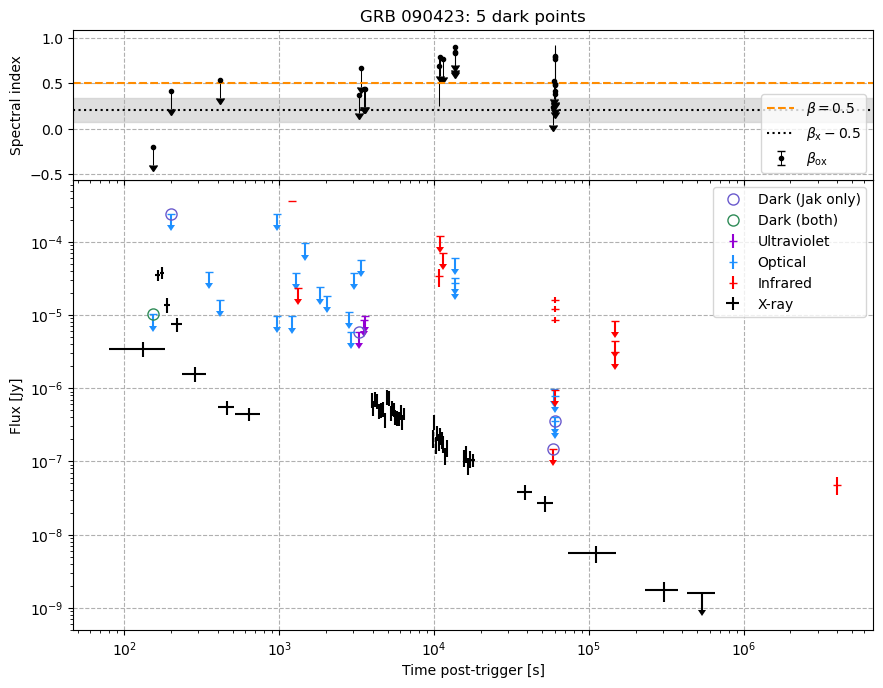

GRB        t_o       dt%  \
3233  090423    152.000  0.073001   
3237  090423    200.000  0.059277   
3239  090423    415.000  0.090313   
3240  090423   3276.000  0.171292   
3242  090423   3390.500  0.142327   
3245  090423   3505.500  0.113237   
3249  090423   3585.500  0.092999   
3258  090423  10693.728  0.006462   
3269  090423  10872.576  0.007603   
3281  090423  11351.232  0.007832   
3287  090423  13716.864  0.124212   
3294  090423  13716.864  0.124212   
3301  090423  13716.864  0.124212   
3305  090423  58500.000  0.118792   
3306  090423  59417.280  0.136334   
3307  090423  60120.000  0.149773   
3308  090423  60120.000  0.149773   
3309  090423  60120.000  0.149773   
3310  090423  60120.000  0.149773   
3311  090423  60120.000  0.149773   
3312  090423  60120.000  0.149773   
3313  090423  60120.000  0.149773   

                                             B_ox_w_err          B_x     α  \
3233  -0.19625502204644998 (+0.03786611839727725, -inf)  0.71 ± 0.13  0.00   
3237     0.4220631211100543 (+0.0610898281985447, -inf)  0.71 ± 0.13  0.00   
3239    0.5435660948662138 (+0.08139323197387692, -inf)  0.71 ± 0.13  0.00   
3240    0.3778416196377353 (+0.06813196395948531, -inf)  0.71 ± 0.13  0.00   
3242    0.6658786646168151 (+0.08989219777961938, -inf)  0.71 ± 0.13  0.00   
3245    0.4394081846359419 (+0.07459329130180321, -inf)  0.71 ± 0.13  0.00   
3249    0.4446744741666907 (+0.07297264310172949, -inf)  0.71 ± 0.13  0.00   
3258  0.6957393755851607 (+0.09282476413483007, -0.4...  0.71 ± 0.13  1.41   
3269    0.7854933071113882 (+0.08763641731540132, -inf)  0.71 ± 0.13  1.41   
3281    0.7728866554589707 (+0.08936460668675664, -inf)  0.71 ± 0.13  1.41   
3287     0.847739734882957 (+0.13587887920961053, -inf)  0.71 ± 0.13  1.41   
3294     0.830417564370326 (+0.12968172612757223, -inf)  0.71 ± 0.13  1.41   
3301    0.8975812153941012 (+0.13344324587886056, -inf)  0.71 ± 0.13  1.41   
3305    0.23958836645575843 (+0.0816700617834124, -inf)  0.71 ± 0.13  1.41   
3306    0.5271418944797194 (+0.10743597116444928, -inf)  0.71 ± 0.13  1.41   
3307    0.4187436832196045 (+0.10790819171185169, -inf)  0.71 ± 0.13  1.41   
3308    0.3816049476006451 (+0.10400469637947632, -inf)  0.71 ± 0.13  1.41   
3309    0.4857696275950172 (+0.10894871519902481, -inf)  0.71 ± 0.13  1.41   
3310     0.4991531886133853 (+0.1088290718132078, -inf)  0.71 ± 0.13  1.41   
3311  0.7729482930587027 (+0.1261568028602808, -0.50...  0.71 ± 0.13  1.41   
3312  0.7908384216645626 (+0.12492531993960605, -0.4...  0.71 ± 0.13  1.41   
3313  0.7974320408905083 (+0.12309694707090166, -0.4...  0.71 ± 0.13  1.41   

     Jak_dark vdH_dark  
3233     True     True  
3237     True    False  
3239    False    False  
3240     True    False  
3242    False    False  
3245    False    False  
3249    False    False  
3258    False    False  
3269    False    False  
3281    False    False  
3287    False    False  
3294    False    False  
3301    False    False  
3305     True    False  
3306    False    False  
3307    False    False  
3308     True    False  
3309    False    False  
3310    False    False  
3311    False    False  
3312    False    False  
3313    False    False

8 0 0


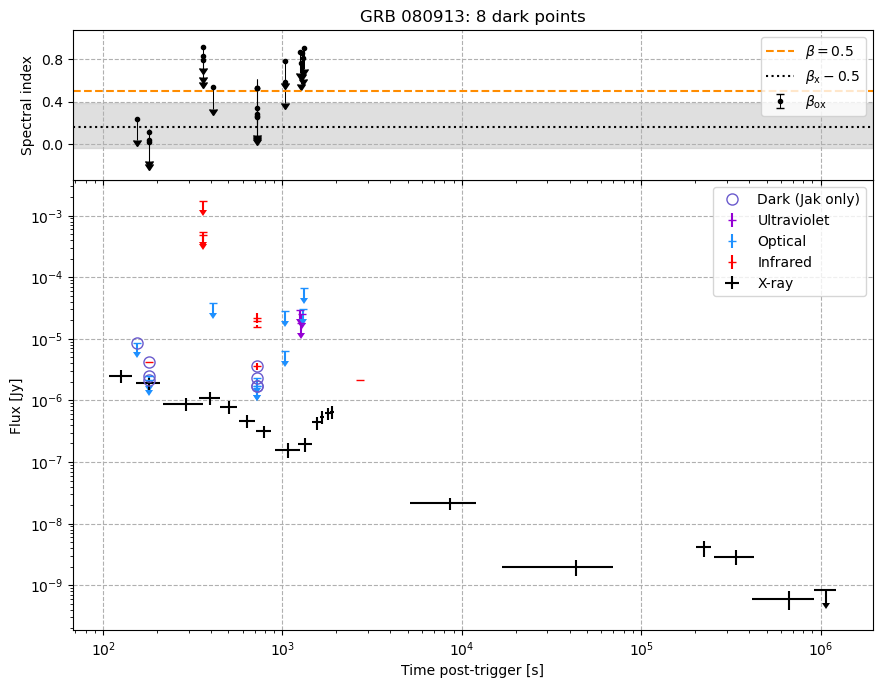

GRB     t_o       dt%  \
3347  080913   155.0  0.142334   
3348  080913   180.0  0.004001   
3349  080913   180.0  0.004001   
3350  080913   180.0  0.004001   
3351  080913   360.0  0.090916   
3352  080913   360.0  0.090916   
3353  080913   360.0  0.090916   
3354  080913   411.0  0.037871   
3357  080913   720.0  0.087132   
3359  080913   720.0  0.087132   
3361  080913   720.0  0.087132   
3363  080913   720.0  0.087132   
3365  080913   720.0  0.087132   
3367  080913   720.0  0.087132   
3369  080913   720.0  0.087132   
3370  080913  1034.5  0.042055   
3371  080913  1034.5  0.042055   
3373  080913  1249.0  0.068168   
3376  080913  1274.0  0.049517   
3379  080913  1277.0  0.047279   
3381  080913  1299.0  0.030865   
3383  080913  1324.0  0.012214   

                                             B_ox_w_err                 B_x  \
3347    0.2399314397193824 (+0.08439495698970664, -inf)  0.66 (+0.23, -0.2)   
3348  0.01605618847209473 (+0.034030454093975926, -inf)  0.66 (+0.23, -0.2)   
3349   0.03748108498254906 (+0.03320026502328484, -inf)  0.66 (+0.23, -0.2)   
3350  0.11163150427182805 (+0.03467104322158288, -0....  0.66 (+0.23, -0.2)   
3351    0.8340860037015736 (+0.10785842933373392, -inf)  0.66 (+0.23, -0.2)   
3352    0.7896194722319819 (+0.10051970738181493, -inf)  0.66 (+0.23, -0.2)   
3353    0.9205862265650239 (+0.10909538872767571, -inf)  0.66 (+0.23, -0.2)   
3354      0.53490837967778 (+0.07793681219762023, -inf)  0.66 (+0.23, -0.2)   
3357   0.26489000672688745 (+0.06617518208200583, -inf)  0.66 (+0.23, -0.2)   
3359    0.2529994851385232 (+0.06378663228882395, -inf)  0.66 (+0.23, -0.2)   
3361     0.284634977772599 (+0.06459595553754052, -inf)  0.66 (+0.23, -0.2)   
3363  0.3402391403389642 (+0.0701010792938108, -0.23...  0.66 (+0.23, -0.2)   
3365  0.5262222241705741 (+0.07976032687869382, -0.3...  0.66 (+0.23, -0.2)   
3367  0.5340339423580948 (+0.0787020286608472, -0.33...  0.66 (+0.23, -0.2)   
3369  0.5304888899837922 (+0.07960682218046862, -0.3...  0.66 (+0.23, -0.2)   
3370    0.5839763950759678 (+0.09002343165309114, -inf)  0.66 (+0.23, -0.2)   
3371    0.7813906865248299 (+0.10748809163580542, -inf)  0.66 (+0.23, -0.2)   
3373    0.8733635330354589 (+0.13838766940616562, -inf)  0.66 (+0.23, -0.2)   
3376    0.7629561167954357 (+0.11842174355956153, -inf)  0.66 (+0.23, -0.2)   
3379    0.8594025754558471 (+0.13604177854436672, -inf)  0.66 (+0.23, -0.2)   
3381    0.8116196567764709 (+0.11771554479040972, -inf)  0.66 (+0.23, -0.2)   
3383    0.9089272082940604 (+0.12471175608300691, -inf)  0.66 (+0.23, -0.2)   

        α Jak_dark vdH_dark  
3347  1.2     True    False  
3348  1.2     True    False  
3349  1.2     True    False  
3350  1.2     True    False  
3351  1.2    False    False  
3352  1.2    False    False  
3353  1.2    False    False  
3354  1.2    False    False  
3357  1.2     True    False  
3359  1.2     True    False  
3361  1.2     True    False  
3363  1.2     True    False  
3365  1.2    False    False  
3367  1.2    False    False  
3369  1.2    False    False  
3370  1.2    False    False  
3371  1.2    False    False  
3373  1.2    False    False  
3376  1.2    False    False  
3379  1.2    False    False  
3381  1.2    False    False  
3383  1.2    False    False

0 0 2


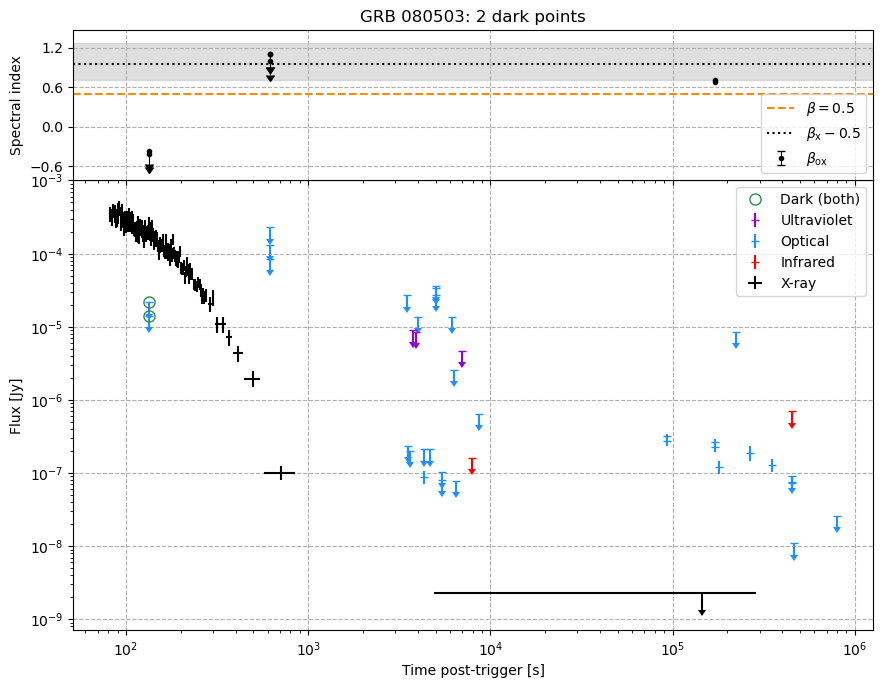

GRB       t_o       dt%  \
3412  080503     133.2  0.001207   
3468  080503     134.5  0.002226   
3497  080503     620.0  0.123748   
3498  080503     620.0  0.123748   
3499  080503     620.0  0.123748   
3500  080503  170640.0  0.176841   
3501  080503  170640.0  0.176841   

                                            B_ox_w_err                  B_x  \
3412  -0.41446458075626785 (+0.0604287156633898, -inf)  1.45 (+0.32, -0.24)   
3468  -0.3717373566638188 (+0.05574912379071332, -inf)  1.45 (+0.32, -0.24)   
3497   1.1050866413669602 (+0.43039424861514924, -inf)  1.45 (+0.32, -0.24)   
3498   0.9898254392685115 (+0.42398845549253483, -inf)  1.45 (+0.32, -0.24)   
3499     1.103017708565408 (+0.4268936581266706, -inf)  1.45 (+0.32, -0.24)   
3500    0.7063283846912259 (+inf, -0.7540846248150592)  1.45 (+0.32, -0.24)   
3501    0.6817994831780811 (+inf, -0.7425139963765917)  1.45 (+0.32, -0.24)   

         α Jak_dark vdH_dark  
3412  1.64     True     True  
3468  1.64     True     True  
3497  8.00    False    False  
3498  8.00    False    False  
3499  8.00    False    False  
3500  8.00    False    False  
3501  8.00    False    False

no Infrared for GRB 080123
0 0 2


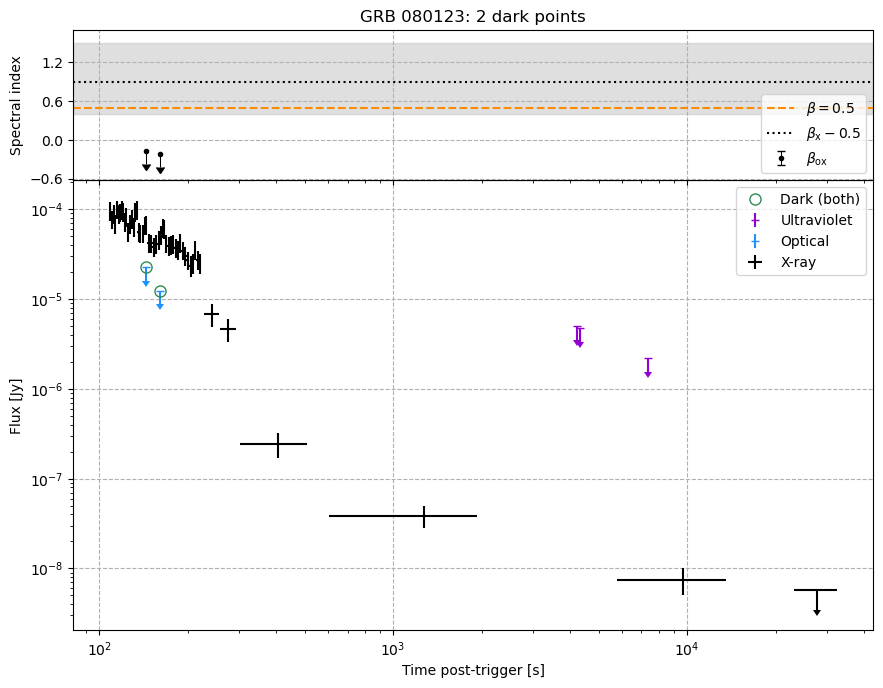

GRB    t_o       dt%  \
3515  080123  144.0  0.005923   
3538  080123  161.5  0.003585   

                                             B_ox_w_err               B_x  \
3515  -0.16940545058698822 (+0.04211980335327065, -inf)  1.4 (+0.6, -0.5)   
3538  -0.22627806369666828 (+0.04645418153007017, -inf)  1.4 (+0.6, -0.5)   

        α Jak_dark vdH_dark  
3515  2.2     True     True  
3538  2.2     True     True

no Ultraviolet for GRB 070714B
1 0 0


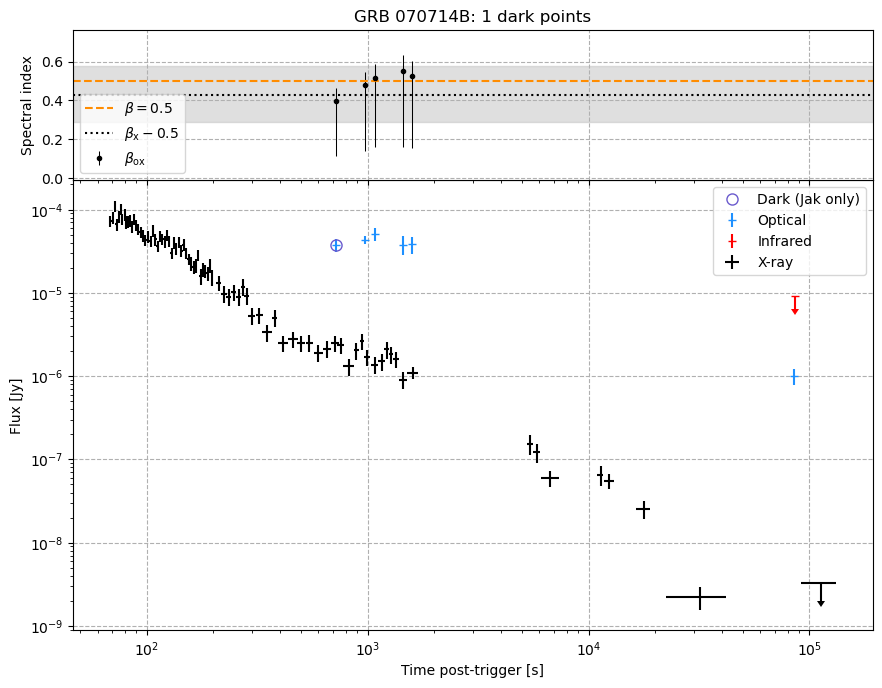

GRB     t_o       dt%  \
3575  070714B   720.0  0.012677   
3582  070714B   972.0  0.026857   
3587  070714B  1080.0  0.002530   
3594  070714B  1440.0  0.007071   
3598  070714B  1584.0  0.010861   

                                             B_ox_w_err                  B_x  \
3575  0.3991626238539481 (+0.06473473485990588, -0.2...  0.93 (+0.15, -0.14)   
3582  0.47821776821143014 (+0.06977052780202826, -0....  0.93 (+0.15, -0.14)   
3587  0.5160295816074629 (+0.07340671391827903, -0.3...  0.93 (+0.15, -0.14)   
3594  0.5527350413762803 (+0.08467823188812844, -0.3...  0.93 (+0.15, -0.14)   
3598  0.5246467021403641 (+0.07713257228976919, -0.3...  0.93 (+0.15, -0.14)   

         α Jak_dark vdH_dark  
3575  0.68     True    False  
3582  0.68    False    False  
3587  0.68    False    False  
3594  0.68    False    False  
3598  0.68    False    False

0 0 2


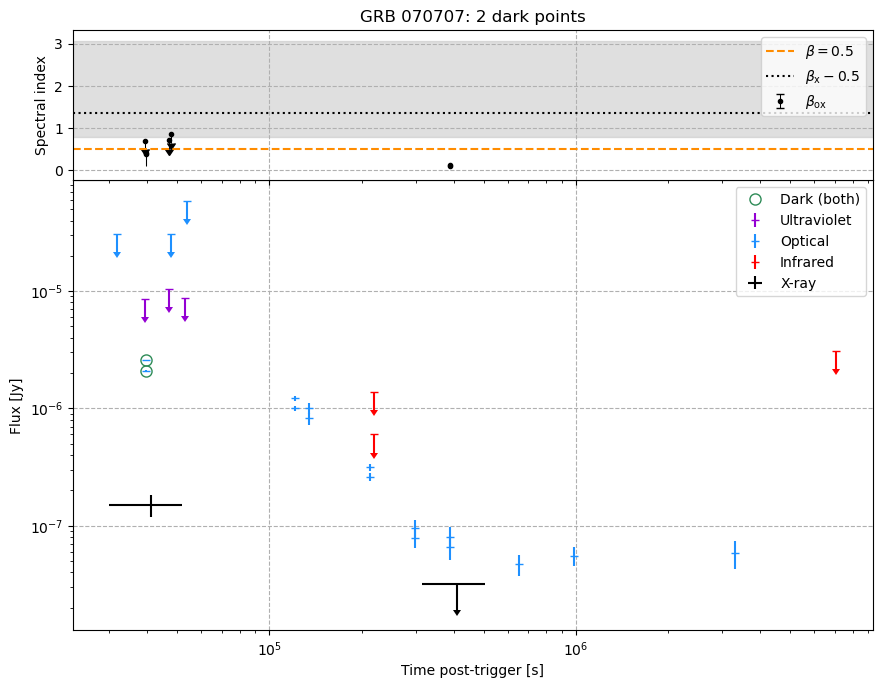

GRB         t_o       dt%  \
3599  070707   39328.000  0.040780   
3600  070707   39521.088  0.036071   
3601  070707   39600.000  0.034146   
3602  070707   47149.000  0.149976   
3603  070707   47905.000  0.168415   
3604  070707  388800.000  0.051707   
3605  070707  388907.136  0.051446   

                                             B_ox_w_err                  B_x  \
3599    0.7036409684769428 (+0.10918105703057798, -inf)  1.86 (+1.71, -0.57)   
3600  0.41689736741625993 (+0.0615635719850237, -0.2...  1.86 (+1.71, -0.57)   
3601  0.3870179453790122 (+0.05831681402895094, -0.2...  1.86 (+1.71, -0.57)   
3602    0.7162274538115445 (+0.12231699836875151, -inf)  1.86 (+1.71, -0.57)   
3603    0.8594059156485568 (+0.13746233272517053, -inf)  1.86 (+1.71, -0.57)   
3604   0.10616274934031909 (+inf, -0.08434067845047725)  1.86 (+1.71, -0.57)   
3605   0.13511853490535963 (+inf, -0.10167503741313387)  1.86 (+1.71, -0.57)   

        α Jak_dark vdH_dark  
3599  1.0    False    False  
3600  1.0     True     True  
3601  1.0     True     True  
3602  1.0    False    False  
3603  1.0    False    False  
3604  1.0    False    False  
3605  1.0    False    False

4 0 0


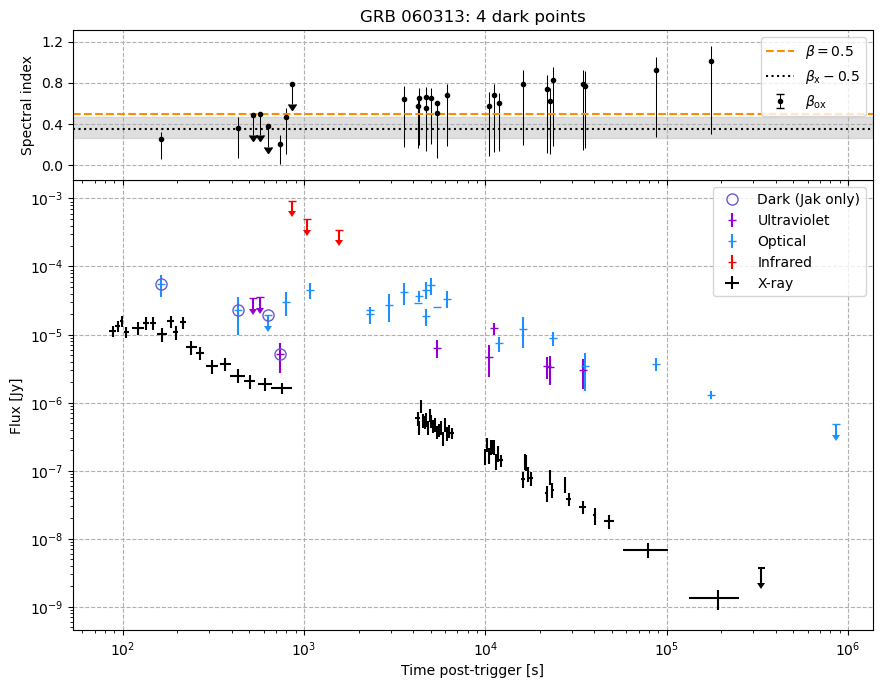

GRB       t_o       dt%  \
3630  060313     162.0  0.022188   
3634  060313     432.0  0.004432   
3636  060313     521.5  0.039860   
3639  060313     575.5  0.059823   
3640  060313     629.5  0.028395   
3642  060313     739.0  0.023547   
3643  060313     792.0  0.046483   
3644  060313     864.0  0.141617   
3645  060313    3570.0  0.156451   
3648  060313    4260.0  0.006588   
3660  060313    4320.0  0.002519   
3674  060313    4680.0  0.009227   
3689  060313    4680.0  0.009227   
3708  060313    5040.0  0.001225   
3725  060313    5400.0  0.002408   
3741  060313    5400.0  0.002408   
3756  060313    6120.0  0.005706   
3761  060313   10440.0  0.007365   
3773  060313   11160.0  0.002267   
3784  060313   11880.0  0.012105   
3786  060313   16200.0  0.003235   
3791  060313   21960.0  0.005735   
3795  060313   22680.0  0.000491   
3800  060313   23760.0  0.013823   
3804  060313   34560.0  0.004177   
3806  060313   35280.0  0.025098   
3808  060313   87120.0  0.098278   
3809  060313  174600.0  0.092153   

                                             B_ox_w_err  \
3630  0.25537158441562124 (+0.06979786317533948, -0....   
3634  0.3570767530886726 (+0.11049834993494675, -0.2...   
3636   0.48769492019673866 (+0.08230726076659017, -inf)   
3639    0.4931519663391611 (+0.08274795138981317, -inf)   
3640   0.37546685197672236 (+0.06330506308398082, -inf)   
3642  0.20120618337611967 (+0.09275371685417784, -0....   
3643  0.46341318236392615 (+0.09231653407481417, -0....   
3644    0.7924140850988121 (+0.10259382391279188, -inf)   
3645  0.6446507463465974 (+0.1206741797479412, -0.47...   
3648  0.5698665473911164 (+0.07679954767542656, -0.4...   
3660  0.6542278633692479 (+0.09044808446874764, -0.4...   
3674  0.6606015828774862 (+0.09634175060213641, -0.4...   
3689  0.5566236123299706 (+0.09112192469376035, -0.4...   
3708  0.6527827096004698 (+0.09224095420898909, -0.4...   
3725                    0.6041416629190014 (+nan, -nan)   
3741  0.5073076300428265 (+0.10038001451000375, -0.4...   
3756  0.6855677010146835 (+0.10132158983479143, -0.4...   
3761  0.5778200125615622 (+0.12752336981640147, -0.4...   
3773  0.6805572047926256 (+0.10928537929332284, -0.5...   
3784  0.5993256765074654 (+0.09899893548785473, -0.4...   
3786  0.7913537453321619 (+0.13255216643432124, -0.5...   
3791  0.743464669584619 (+0.13173942064149197, -0.62...   
3795  0.6263590963506426 (+0.1251026920070149, -0.51...   
3800  0.827272234050091 (+0.12340950888602387, -0.64...   
3804  0.7849654690490396 (+0.14023890099729938, -0.6...   
3806  0.7685654661777407 (+0.14143104196575867, -0.6...   
3808  0.9256875830068744 (+0.1292146557191775, -0.65...   
3809  1.0151510820356378 (+0.13914314180029091, -0.7...   

                        B_x    α Jak_dark vdH_dark  
3630  0.846 (+0.12, -0.087)  1.0     True    False  
3634  0.846 (+0.12, -0.087)  1.0     True    False  
3636  0.846 (+0.12, -0.087)  1.0    False    False  
3639  0.846 (+0.12, -0.087)  1.0    False    False  
3640  0.846 (+0.12, -0.087)  1.0     True    False  
3642  0.846 (+0.12, -0.087)  1.0     True    False  
3643  0.846 (+0.12, -0.087)  1.0    False    False  
3644  0.846 (+0.12, -0.087)  1.0    False    False  
3645  0.846 (+0.12, -0.087)  1.0    False    False  
3648  0.846 (+0.12, -0.087)  1.0    False    False  
3660  0.846 (+0.12, -0.087)  1.0    False    False  
3674  0.846 (+0.12, -0.087)  1.0    False    False  
3689  0.846 (+0.12, -0.087)  1.0    False    False  
3708  0.846 (+0.12, -0.087)  1.0    False    False  
3725  0.846 (+0.12, -0.087)  1.0    False    False  
3741  0.846 (+0.12, -0.087)  1.0    False    False  
3756  0.846 (+0.12, -0.087)  1.0    False    False  
3761  0.846 (+0.12, -0.087)  1.0    False    False  
3773  0.846 (+0.12, -0.087)  1.0    False    False  
3784  0.846 (+0.12, -0.087)  1.0    False    False  
3786  0.846 (+0.12, -0.087)  1.0    False    False  
3791  0.846 (+0.12, -0.087)  1.0    False    False  
3795  0.846 (+0.12, -0.087)  1.0 

1 0 6


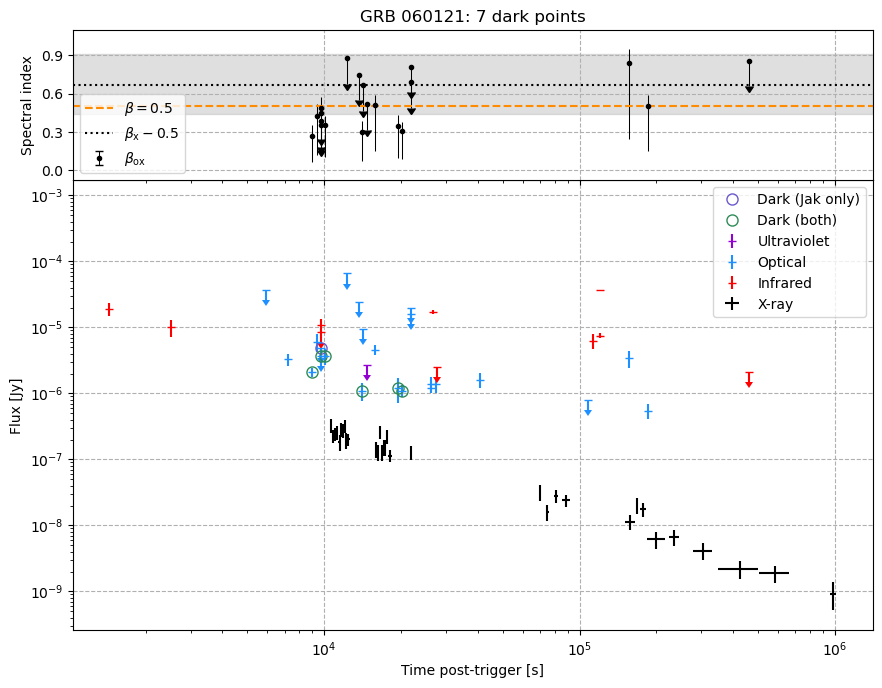

GRB       t_o       dt%  \
3810  060121    9000.0  0.157425   
3813  060121    9360.0  0.123723   
3819  060121    9720.0  0.090020   
3827  060121    9720.0  0.090020   
3835  060121    9720.0  0.090020   
3843  060121    9720.0  0.090020   
3851  060121   10080.0  0.056317   
3869  060121   12278.0  0.007990   
3876  060121   13680.5  0.099647   
3886  060121   14040.0  0.123561   
3895  060121   14240.0  0.111076   
3903  060121   14713.0  0.081550   
3911  060121   15840.0  0.011197   
3925  060121   19440.0  0.075842   
3932  060121   20160.0  0.075713   
3933  060121   21836.0  0.001128   
3934  060121   21960.0  0.006813   
3935  060121  156906.0  0.006968   
3940  060121  185400.0  0.045644   
3942  060121  460080.0  0.085020   

                                             B_ox_w_err                  B_x  \
3810  0.27149783096802343 (+0.08247250900487009, -0....  1.17 (+0.24, -0.23)   
3813  0.42808911485764395 (+0.09260667298003425, -0....  1.17 (+0.24, -0.23)   
3819   0.35803760216680375 (+0.06742669774850686, -inf)  1.17 (+0.24, -0.23)   
3827    0.3855022700594813 (+0.06812484175493841, -inf)  1.17 (+0.24, -0.23)   
3835    0.4453261255820076 (+0.07094370749352824, -inf)  1.17 (+0.24, -0.23)   
3843  0.48908632739746694 (+0.08235368722522932, -0....  1.17 (+0.24, -0.23)   
3851  0.3535077042933797 (+0.07124627609340599, -0.2...  1.17 (+0.24, -0.23)   
3869     0.8775203988518827 (+0.1168967139283292, -inf)  1.17 (+0.24, -0.23)   
3876    0.7496440828562636 (+0.11004637735640163, -inf)  1.17 (+0.24, -0.23)   
3886  0.2985555209527817 (+0.08611528914976126, -0.2...  1.17 (+0.24, -0.23)   
3895    0.6658659935964851 (+0.10775803998418679, -inf)  1.17 (+0.24, -0.23)   
3903    0.5158024669737835 (+0.09547740641367722, -inf)  1.17 (+0.24, -0.23)   
3911  0.5086105935735652 (+0.07835341437672705, -0.3...  1.17 (+0.24, -0.23)   
3925  0.34641101242275574 (+0.08515068021389786, -0....  1.17 (+0.24, -0.23)   
3932  0.3110520372331474 (+0.06748754502340887, -0.2...  1.17 (+0.24, -0.23)   
3933    0.8103670094780884 (+0.11533895223378804, -inf)  1.17 (+0.24, -0.23)   
3934    0.6879091107314499 (+0.08855806459837616, -inf)  1.17 (+0.24, -0.23)   
3935  0.838628101194818 (+0.11559405004116226, -0.59...  1.17 (+0.24, -0.23)   
3940  0.5062691302413981 (+0.08195604484876517, -0.3...  1.17 (+0.24, -0.23)   
3942    0.8578247024692394 (+0.10243200128260374, -inf)  1.17 (+0.24, -0.23)   

        α Jak_dark vdH_dark  
3810  1.0     True     True  
3813  1.0    False    False  
3819  1.0     True     True  
3827  1.0     True    False  
3835  1.0    False    False  
3843  1.0    False    False  
3851  1.0     True     True  
3869  1.0    False    False  
3876  1.0    False    False  
3886  1.0     True     True  
3895  1.0    False    False  
3903  1.0    False    False  
3911  1.0    False    False  
3925  1.0     True     True  
3932  1.0     True     True  
3933  1.0    False    False  
3934  1.0    False    False  
3935  1.0    False    False  
3940  1.0    False    False  
3942  1.0    False    False

In [25]:
for grb in close_times.loc[(close_times["Jak_dark"]|close_times["vdH_dark"]),"GRB"].unique():
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_axes((0,0,1,.75))
    
    subset = all_optical.loc[(all_optical["GRB"]==grb)].copy()
    dark_points = close_times.loc[(close_times["GRB"]==grb) & (close_times["vdH_dark"]|close_times["Jak_dark"])]

    subset.loc[:,"band"] = ["Ultraviolet" if wavelength<3000 else "Infrared" if wavelength>8000 else None if pd.isna(wavelength) else "Optical" for wavelength in subset["λ_eff"]]
    bands = {"Ultraviolet":["darkviolet","$\lambda<3000$ Å"],
             "Optical":    ["dodgerblue","$3000<\lambda<8000$ Å"],
             "Infrared":   ["red", "$\lambda<8000$ Å"]}
    for band,info in bands.items():
        subsubset = subset[subset["band"]==band]
        if not len(subsubset):
            print(f"no {band} for GRB {grb}")
            continue
        neg_err = [0.3*flux.value if np.isinf(flux.minus) else flux.minus for flux in subsubset["Flux (Jy)"]]
        pos_err = [0.3*flux.value if np.isinf(flux.plus) else flux.plus for flux in subsubset["Flux (Jy)"]]
        ax.errorbar(subsubset["Time (s)"],[flux.value for flux in subsubset["Flux (Jy)"]],
                    marker="_",linestyle="",color=info[0],label=f"{band}",yerr=np.array((neg_err,pos_err)),
                    uplims=[np.isinf(point.minus) for point in subsubset["Flux (Jy)"]],
                    lolims=[np.isinf(point.plus) for point in subsubset["Flux (Jy)"]],capthick=0)
    
    subset = xrt_data.loc[xrt_data["GRB"]==grb].copy()
    neg_err = [0.4*flux.value if np.isinf(flux.minus) else flux.minus for flux in subset["SpecFlux"]]
    pos_err = [0.4*flux.value if np.isinf(flux.plus) else flux.plus for flux in subset["SpecFlux"]]
    ax.errorbar(subset.Time,[flux.value for flux in subset.SpecFlux],
                xerr=np.array(subset.Tneg,subset.Tpos).T,yerr=np.array((neg_err,pos_err)),
                uplims=[np.isinf(point.minus) for point in subset["SpecFlux"]],
                lolims=[np.isinf(point.plus) for point in subset["SpecFlux"]],
                linestyle="",capthick=0,color="k",label="X-ray")
    
    jak = dark_points[dark_points["Jak_dark"] & ~dark_points["vdH_dark"]]
    vdh = dark_points[dark_points["vdH_dark"] & ~dark_points["Jak_dark"]]
    both = dark_points[dark_points["Jak_dark"] & dark_points["vdH_dark"]]
    print(len(jak),len(vdh),len(both))
    
    if len(jak)>0:
        ax.plot(jak["t_o"],[flux.value for flux in jak["F_o"]],
            marker="o",markersize=8,mfc="none",mec="slateblue",
            linestyle="",label="Dark (Jak only)")
    if len(vdh)>0:
        ax.plot(vdh["t_o"],[flux.value for flux in vdh["F_o"]],
            marker="o",markersize=8,mfc="none",mec="goldenrod",
            linestyle="",label="Dark (vdH only)")
    if len(both)>0:
        ax.plot(both["t_o"],[flux.value for flux in both["F_o"]],
            marker="o",markersize=8,mfc="none",mec="seagreen",
            linestyle="",label="Dark (both)")
#     ax.axvline(11*60*60,linestyle="--",color="k",label="11 hr")
    ax.set(xscale="log",yscale="log",xlabel="Time post-trigger [s]",ylabel="Flux [Jy]")
    tmin,tmax = ax.get_xlim()
    ax.legend(loc="best", fancybox=True)
    ax.grid(linestyle="--")

    ax2 = fig.add_axes((0,.75,1,.25))
    matches = results[results["GRB"]==grb].copy()
    for t,sub in matches.groupby("t_o"):
        matches.drop(sub[sub["dt%"]!=sub["dt%"].min()].index,axis=0,inplace=True)
        
    ax2.errorbar(matches["t_o"],UncertaintyArray(matches[B_ox_name]).values,
                 yerr=[[e if np.isfinite(e) else 0.2 for e in UncertaintyArray(matches[B_ox_name]).minus],
                       UncertaintyArray(matches[B_ox_name]).plus],uplims=np.isinf(UncertaintyArray(matches[B_ox_name]).minus),
                 linestyle="",marker=".",color="k",elinewidth=0.75,label=r"$\beta_\mathrm{ox}$")
    ax2.axhline(0.5,color="darkorange",linestyle="--", label=r"$\beta=0.5$")

    B_x = a_u(*sGRBs.loc[sGRBs["GRB"]==grb,["Beta_X","Beta_X_pos","Beta_X_neg"]].values[0])
    ax2.axhline(B_x.value-0.5,color="k",linestyle=":",label=r"$\beta_\mathrm{x}-0.5$")
    ax2.fill_between([tmin,tmax],B_x.minimum-0.5,B_x.maximum-0.5,alpha=0.5,color="silver")
    ax2.legend(loc="best", fancybox=True)
    default_lolim,default_uplim = ax2.get_ylim()

    ax2.set(xscale="log",xlim=(tmin,tmax),ylim=(default_lolim-.1,default_uplim+.1),#xlabel="Time [s]",
            ylabel="Spectral index",xticklabels=[],title=f"GRB {grb}: {len(dark_points)} dark points")
    ax2.yaxis.set_major_locator(ticker.MaxNLocator(4))
    ax2.grid(linestyle="--")
    
    fig.savefig(f"./products/dark lightcurves/{grb}.png",dpi=300,transparent=False,facecolor="white",bbox_inches="tight")
    plt.show()
    display(close_times.loc[close_times["GRB"]==grb,["GRB","t_o","dt%",B_ox_name,"B_x","α","Jak_dark","vdH_dark"]])

In [ ]:
def interp_xray_flux(grb,time):
    lightcurve = xrt_data[xrt_data["GRB"]==grb]
    time_series = [lightcurve.loc[i,"Time"] for i in lightcurve.index if np.isfinite(lightcurve.loc[i,"SpecFlux"].minus)]
    flux_series = [Fx.value for Fx in lightcurve["SpecFlux"] if np.isfinite(Fx.minus)]
    interp_func = interpolate.interp1d(time_series,flux_series)
    return interp_func(time)

# def interp_opt_flux(grb,time):

def interp_B_ox(optical_index):
    grb = all_optical.loc[optical_index,"GRB"]
    t_o = all_optical.loc[optical_index,"Time (s)"]
    F_o = all_optical.loc[optical_index,"Flux (Jy)"]
    print("B_x",results.loc[results["GRB"]==grb,"B_x"])
    print(grb,t_o,F_o)
    F_x = interp_xray_flux(grb,t_o)
    nu_o = 299792458/float(all_optical.loc[optical_index,"λ_eff"]/1e10)
    return -np.log10(F_x/F_o)/np.log10(nu_x/nu_o)

def bpl(xvals,alphas,breaks):
    assert len(alphas)==len(breaks)+1, "There must be one more index than there are breaks"
    assert min(xvals)<min(breaks) and max(xvals)>max(breaks), "Breaks must be within domain"
    breakpoints = [np.min(xvals)] + breaks + [np.max(xvals)] # create a list of all the bounding x-values
    chunks = [np.array([x for x in xvals if x >= breakpoints[i] and x <= breakpoints[i+1]]) for i in range(len(breakpoints)-1)]
    
    all_y = []
    
    for idx,xchunk in enumerate(chunks):
        yvals = xchunk**alphas[idx]
        all_y.append(yvals) # add this piece to the output
    
    for i in range(1,len(all_y)):
        all_y[i] *= np.abs(all_y[i-1][-1]/all_y[i][0]) # scale the beginning of each piece to the end of the last so it is continuous
    
    return np.array([y for ychunk in all_y for y in ychunk]) # return flattened list

In [ ]:
for grb in all_optical[(all_optical["Magnitude"]>=23) & (all_optical["Time (s)"]>=1000) & (all_optical["GRB"].isin(xrt_data["GRB"]))]["GRB"].unique():
    fig, ax = plt.subplots()

    subset = all_optical.loc[(all_optical["GRB"]==grb)].copy()
    dark_points = close_times[close_times["GRB"]==grb]
    of_interest = subset[(subset["Magnitude"]>=23) & (subset["Time (s)"]>=1000) & ~(subset["Time (s)"].isin(results.loc[results["GRB"]==grb,"t_o"]))]
    display(of_interest)
    display(results[(results["GRB"]==grb) & results["t_o"].isin(of_interest["Time (s)"])])

    subset.loc[:,"band"] = ["UV" if wavelength<3000 else "IR" if wavelength>8000 else None if pd.isna(wavelength) else "Optical" for wavelength in subset["λ_eff"]]
    bands = {"UV":["darkviolet","$\lambda<3000$ Å"],"Optical":["dodgerblue","$\lambda<3000$ Å"],"IR":"red"}
    for band,info in bands.items():
        subsubset = subset[subset["band"]==band]
        neg_err = [0.3*flux.value if np.isinf(flux.minus) else flux.minus for flux in subsubset["Flux (Jy)"]]
        pos_err = [0.3*flux.value if np.isinf(flux.plus) else flux.plus for flux in subsubset["Flux (Jy)"]]
        ax.errorbar(subsubset["Time (s)"],[flux.value for flux in subsubset["Flux (Jy)"]],
                    marker="_",linestyle="",color=info[0],label=f"{band}",yerr=np.array((neg_err,pos_err)),
                    uplims=[np.isinf(point.minus) for point in subsubset["Flux (Jy)"]],
                    lolims=[np.isinf(point.plus) for point in subsubset["Flux (Jy)"]],capthick=0)

    subset = xrt_data.loc[xrt_data["GRB"]==grb]
    neg_err = [0.4*flux.value if np.isinf(flux.minus) else flux.minus for flux in subset["SpecFlux"]]
    pos_err = [0.4*flux.value if np.isinf(flux.plus) else flux.plus for flux in subset["SpecFlux"]]
    ax.errorbar(subset.Time,[flux.value for flux in subset.SpecFlux],
                xerr=np.array(subset.Tneg,subset.Tpos).T,yerr=np.array((neg_err,pos_err)),
                uplims=[np.isinf(point.minus) for point in subset["SpecFlux"]],
                lolims=[np.isinf(point.plus) for point in subset["SpecFlux"]],
                linestyle="",capthick=0,color="k",label="X-ray")
    
    jak = dark_points[dark_points["Jak_dark"] & ~dark_points["vdH_dark"]]
    vdh = dark_points[dark_points["vdH_dark"] & ~dark_points["Jak_dark"]]
    both = dark_points[dark_points["Jak_dark"] & dark_points["vdH_dark"]]
    
    if len(jak)>0:
        ax.plot(jak["t_o"],[flux.value for flux in jak["F_o"]],
                marker="o",markersize=8,mfc="none",mec="slateblue",
                linestyle="",label="Dark (Jak only)")
    if len(vdh)>0:
        ax.plot(vdh["t_o"],[flux.value for flux in vdh["F_o"]],
                marker="o",markersize=8,mfc="none",mec="goldenrod",
                linestyle="",label="Dark (vdH only)")
    if len(both)>0:
        ax.plot(both["t_o"],[flux.value for flux in both["F_o"]],
                marker="o",markersize=8,mfc="none",mec="seagreen",
                linestyle="",label="Dark (both)")
        
    ax.plot(of_interest["Time (s)"],[flux.value for flux in of_interest["Flux (Jy)"]],"s",mec="green",mfc="none",ms=12)
    
    ax.set(xscale="log",yscale="log",xlabel="Time [s]",ylabel=f"Flux [Jy]",title=f"GRB {grb} lightcurve")
    ax.legend(loc="upper left",bbox_to_anchor=(1.02,1))
    ax.grid(linestyle="--")
    
    plt.title("GRB "+grb+": "+str(close_times["GRB"].tolist().count(grb))+" dark point(s)")
    plt.show()

## Population statistics

### Spectral index distributions

In [5]:
notvalid = lambda x : any((np.isinf(x), pd.isna(x)))
b_ox = [b.value for b in darkest_times[B_ox_name]]
oxplus = [0.2 if notvalid(v.plus) else v.plus for v in darkest_times[B_ox_name]]
oxminus = [0.2 if notvalid(v.minus) else v.minus for v in darkest_times[B_ox_name]]
oxuplims = [notvalid(v.minus) for v in darkest_times[B_ox_name]]
oxlolims = [notvalid(v.plus) for v in darkest_times[B_ox_name]]
b_x = [b.value for b in darkest_times["B_x"]]
xplus = [0.2 if notvalid(v.plus) else v.plus for v in darkest_times["B_x"]]
xminus = [0.2 if notvalid(v.minus) else v.minus for v in darkest_times["B_x"]]
t_obs = darkest_times["t_o"].values

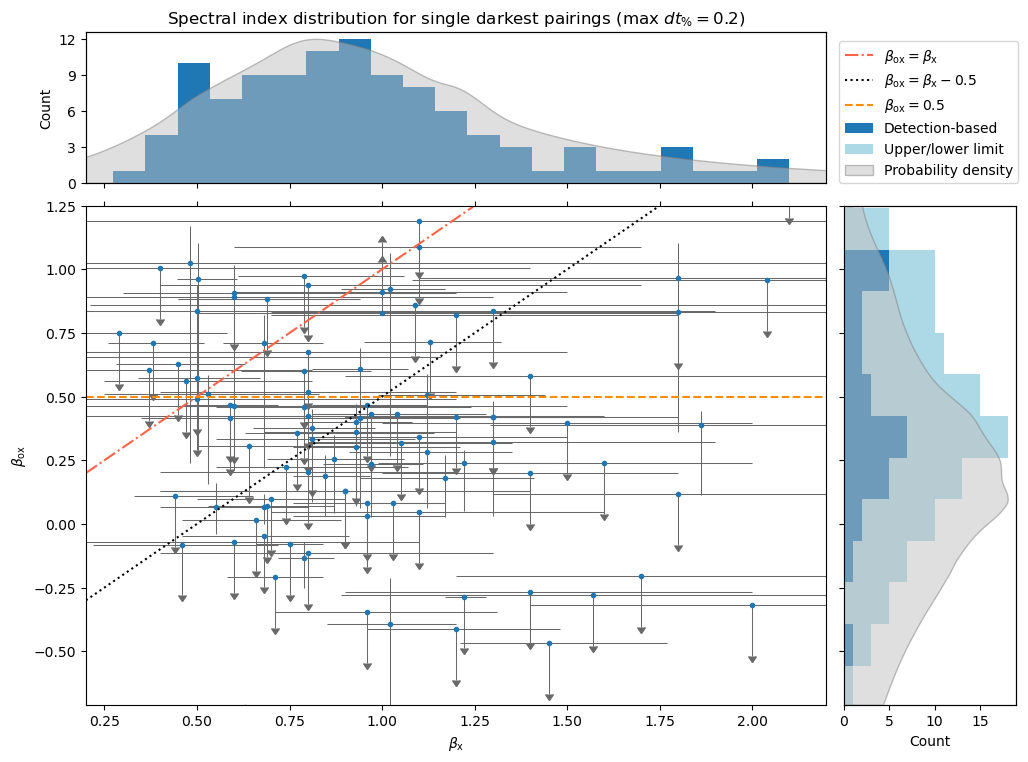

In [6]:
fig = plt.figure(figsize=(12,11))
grid = plt.GridSpec(5, 5, hspace=0.15, wspace=0.1)

ax_main = fig.add_subplot(grid[1:-1, 0:-1])
ax_right = fig.add_subplot(grid[1:-1, -1], yticklabels=[])#, xticklabels=[])
ax_top = fig.add_subplot(grid[0, 0:-1], xticklabels=[])#, yticklabels=[])

x = np.linspace(0.2 ,2.2 ,500)
y = np.linspace(-.71,1.25,500)
X,Y = np.meshgrid(x,y)

ax_main.errorbar([b_x[i] for i in range(len(b_x)) if not (oxuplims[i] and oxlolims[i])],
                 [b_ox[i] for i in range(len(b_ox)) if not (oxuplims[i] and oxlolims[i])],
                 xerr=[[xminus[i] for i in range(len(xminus)) if not (oxuplims[i] and oxlolims[i])],
                       [xplus[i] for i in range(len(xplus)) if not (oxuplims[i] and oxlolims[i])]],
                 yerr=[[oxminus[i] for i in range(len(oxminus)) if not (oxuplims[i] and oxlolims[i])],
                       [oxplus[i] for i in range(len(oxplus)) if not (oxuplims[i] and oxlolims[i])]],
                 uplims=[oxuplims[i] for i in range(len(oxuplims)) if not (oxuplims[i] and oxlolims[i])],
                 lolims=[oxlolims[i] for i in range(len(oxlolims)) if not (oxuplims[i] and oxlolims[i])],
                 zorder=0, linestyle="",marker=".", ecolor="dimgrey", elinewidth=0.75, capthick=1)
ax_main.plot(x,x,linestyle="-.",color="tomato",label=r"$\beta_\mathrm{ox}=\beta_\mathrm{x}$")
ax_main.plot(x,x-.5,"k:",label=r"$\beta_\mathrm{ox}=\beta_\mathrm{x}-0.5$")
ax_main.plot(x,[.5]*len(x),linestyle="--",color="darkorange",label=r"$\beta_\mathrm{ox}=0.5$")
ax_main.set(xlim=(x.min(),x.max()),ylim=(y.min(),y.max()),
            xlabel=r"$\beta_\mathrm{x}$",ylabel=r"$\beta_\mathrm{ox}$")
ax_main.xaxis.set_ticks_position("both")

ax_kde_x = ax_top.twinx()
valid_bx = UncertaintyArray([entry for entry in darkest_times["B_x"] if pd.notna(entry.value)])
ax_kde_x.fill_between(x,valid_bx.pdf(x),facecolor="silver",edgecolor="grey",alpha=.5)
ax_kde_x.set_ylim(0,)
ax_kde_x.set(yticks=[])
ax_top.hist(b_x,23,orientation='vertical', color="C0")
ax_top.set(xlim=ax_main.get_xlim(), ylabel="Count", yticks=range(0,14,3))

ax_kde_y = ax_right.twiny()
valid_box = UncertaintyArray()
for i,row in darkest_times.iterrows():
    if np.isfinite(row[B_ox_name].minus):
        neg = row[B_ox_name].minus
    else:
        neg = 0.5
    if np.isfinite(row[B_ox_name].plus):
        pos = row[B_ox_name].plus
    else:
        pos = 0.5
    if np.isfinite(row[B_ox_name].value):
        valid_box.append(a_u(row[B_ox_name].value,pos,neg))
ax_kde_y.fill_betweenx(y,valid_box.pdf(y),alpha=.5,
                       facecolor="silver",edgecolor="grey",label="Probability density")
ax_kde_y.set_xlim(0,)
ax_kde_y.set(xticks=[])
ax_right.hist([[b.value for b in darkest_times[B_ox_name] if all(np.isfinite(b.items()))],
               [b.value for b in darkest_times[B_ox_name] if not all(np.isfinite(b.items()))]],
              21, orientation='horizontal', stacked=True, color=["C0","lightblue"],
              label=["Detection-based","Upper/lower limit"])
ax_right.set(ylim=(ax_main.get_ylim()), xlabel="Count")
ax_right.set_xlim(0,)

# Z_x = np.sum([bx.pdf(X) for bx in valid_bx],axis=0)
# Z_x /= np.sum(Z_x)
# Z_ox = np.sum([box.pdf(Y) for box in valid_box],axis=0)
# Z_ox /= np.sum(Z_ox)
# ax_main.contourf(X,Y,np.sqrt(Z_x**2+Z_ox**2),30,cmap="Greys",vmax=4e-5,vmin=0)

fig.legend(loc="lower left",bbox_to_anchor=(0.747,0.736))
# fig.colorbar(scatter,ax=ax_right,label=r"$\log_{10}(t_\mathrm{o}\ \mathrm{[s]})$")

ax_top.set_title(r"Spectral index distribution for single darkest pairings (max $dt_\%="+f"{max_dt:.1f}$)")

plt.savefig("./products/beta_distributions.png",dpi=300,bbox_inches="tight")

plt.show()

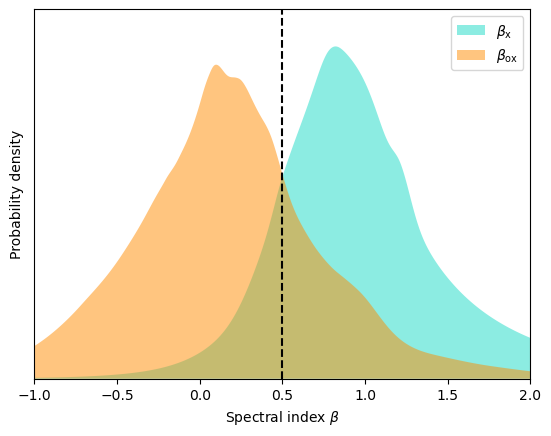

In [33]:
x = np.linspace(-1,2,500)
# for box in valid_bx:
#     plt.plot(x,box.pdf(x),"k-",linewidth=0.4)
#     if any(box.pdf(x)>6):
#         print(box)
# plt.yticks([])
# plt.ylim(0,15)
# plt.twinx()

plt.fill_between(x,valid_bx.pdf(x),fc="turquoise",alpha=.6,label=r"$\beta_\mathrm{x}$")
plt.fill_between(x,valid_box.pdf(x),fc="darkorange",alpha=.5,label=r"$\beta_\mathrm{ox}$")
plt.axvline(0.5,linestyle="--",color="k")
plt.legend()
plt.ylim(0,111)
plt.xlabel(r"Spectral index $\beta$")
plt.xlim(x.min(),x.max())
plt.yticks([])
plt.ylabel("Probability density")

plt.savefig("./products/beta_comparison.png",dpi=300,bbox_inches="tight")
plt.show()

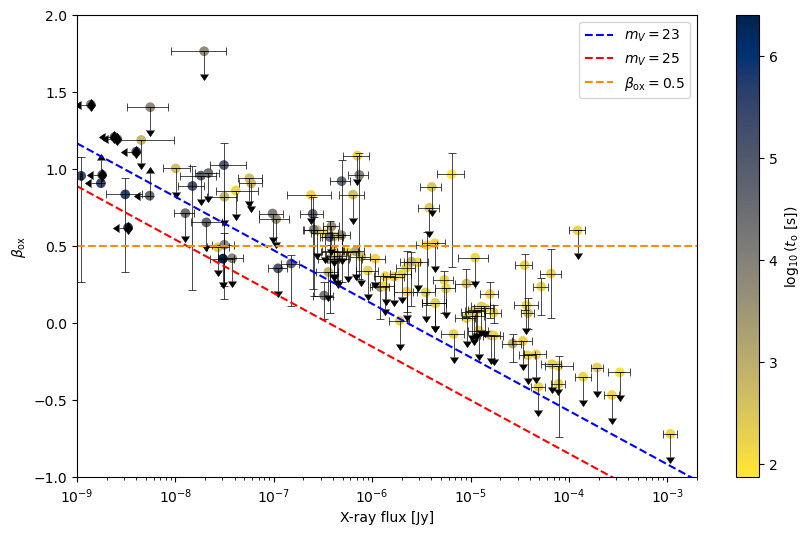

In [34]:
fig = plt.figure(figsize=(10,6))
b_ox = [b.value for b in darkest_times[B_ox_name]]
oxplus = [0.15 if notvalid(v.plus) else v.plus for v in darkest_times[B_ox_name]]
oxminus = [0.15 if notvalid(v.minus) else v.minus for v in darkest_times[B_ox_name]]
oxuplims = [notvalid(v.minus) for v in darkest_times[B_ox_name]]
Fx = [f.value for f in darkest_times["F_x"]]
Fxplus = [v.value*0.2 if notvalid(v.plus) else v.plus for v in darkest_times["F_x"]]
Fxminus = [v.value*0.2 if notvalid(v.minus) else v.minus for v in darkest_times["F_x"]]
Fxuplims = [notvalid(v.minus) for v in darkest_times["F_x"]]
plt.scatter(Fx,b_ox,c=np.log10(darkest_times["t_o"]),cmap="cividis_r")
plt.errorbar(Fx,b_ox,xerr=[Fxminus,Fxplus],yerr=[oxminus,oxplus],uplims=oxuplims,lolims=oxlolims,
             xuplims=Fxuplims,elinewidth=0.5,capsize=3,capthick=0.5,color="k",linestyle="",marker="")
plt.colorbar(label=r"$\log_{10}(t_\mathrm{o}\ \mathrm{[s]})$")
fx = np.linspace(1e-9,2e-3,10)
box_m23 = -np.log10(fx/(3631*10**(-23/2.5)))/np.log10(4.18794e17/5.539986e14)
box_m25 = -np.log10(fx/(3631*10**(-25/2.5)))/np.log10(4.18794e17/5.539986e14)
plt.plot(fx,box_m23,"b--",label="$m_V=23$")
plt.plot(fx,box_m25,"r--",label="$m_V=25$")
plt.axhline(0.5,linestyle="--",color="darkorange",label=r"$\beta_\mathrm{ox}=0.5$")
plt.xlim(fx.min(),fx.max())
plt.ylim(-1,2)
plt.legend()
plt.xscale("log")
plt.ylabel(r"$\beta_\mathrm{ox}$")
plt.xlabel("X-ray flux [Jy]")
plt.savefig("./products/Fx-Box.png",dpi=300,bbox_inches="tight")
plt.show()

In [ ]:
dark11hrFx = UncertaintyArray()
notdark11hrFx = UncertaintyArray()
for grb in results["GRB"].unique():
    print(grb,end=" ")
    try:
        Fx11hr = interp_xray_flux(grb,11*60*60)
        print('success')
    except ValueError:
        try:
            lc = xrt_data[(xrt_data["GRB"]==grb) & np.isfinite(xrt_data["Fluxneg"])].copy().reset_index()
            last_time = a_u(*np.abs(lc.loc[np.argmin(np.abs(lc["Time"]-11*60*60)),["Time","Tpos","Tneg"]]))
            last_flux = a_u(*lc.loc[np.argmin(np.abs(lc["Time"]-11*60*60)),["Flux","Fluxpos","Fluxneg"]])
            alpha = get_temporalIndex(grb,last_time)
            dt = 11*60*60 - last_time
            A = last_flux/(last_time**-alpha)
            Fx11hr = A*(11*60*60)**-alpha
            print(last_flux,"->",Fx11hr)
        except:
            print("failed")
            continue
    if grb in dark["GRB"].tolist():
        dark11hrFx.append(Fx11hr)
    else:
        notdark11hrFx.append(Fx11hr)

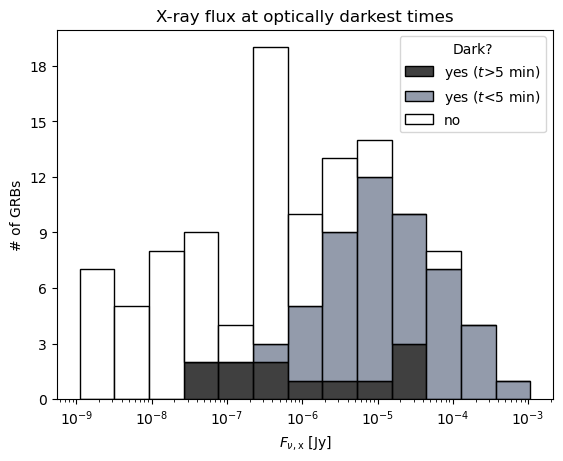

In [22]:
darkest_times["Fx"] = UncertaintyArray(darkest_times["F_x"]).values
darkest_times["dark"] = (darkest_times["vdH_dark"]|darkest_times["Jak_dark"])
for i,entry in darkest_times.iterrows():
    if entry["dark"]:
        if entry["t_o"]>300:
            darkest_times.loc[i,"dark"] = 2
        else:
            darkest_times.loc[i,"dark"] = 1
    else:
        darkest_times.loc[i,"dark"] = 0
sns.histplot(data=darkest_times,x="Fx",hue="dark",palette="bone_r",
             bins=13,log_scale=True,multiple="stack",edgecolor="k")
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(3))
plt.xlabel(r"$F_{\nu,\mathrm{x}}$ [Jy]")
plt.ylabel("# of GRBs")
plt.title("X-ray flux at optically darkest times")
plt.legend(labels=["yes ($t$>5 min)","yes ($t$<5 min)","no"],title="Dark?")
plt.savefig("./products/Fx_hist.png",dpi=300,bbox_inches="tight")
plt.show()

### Extinction/absorption analysis

In [10]:
from src.xrt import grb_list
sGRBs["N_H (intrinsic)"] = np.nan
sGRBs["N_H (intrinsic)"] = [a_u(nh) if pd.notna(nh) else np.nan for nh in sGRBs["N_H (intrinsic)"]]
for i in sGRBs.index:
    grb = sGRBs.loc[i,"GRB"]
    print(grb,end=": ")
    if pd.notna(sGRBs.loc[i,"N_H (intrinsic)"]):
        print("already present")
        continue
    try:
        sGRBs.loc[i,"N_H (intrinsic)"],mode = get_columnDensity(grb,sGRBs)
        print(f"retrieved ({mode} mode)")
    except AssertionError:
        print("info doesn't exist")
    except ValueError:
        print("couldn't be parsed")
    except TypeError:
        print("trigger not found")

211227A: retrieved (PC mode)
211221A: retrieved (PC mode)
211207A: retrieved (PC mode)
211106A: retrieved (PC mode)
211023B: retrieved (PC mode)
210919A: retrieved (PC mode)
210726A: retrieved (PC mode)
210725B: retrieved (PC mode)
210708A: retrieved (PC mode)
210704A: retrieved (PC mode)
210618A: retrieved (PC mode)
210413B: info doesn't exist
210410A: retrieved (PC mode)
210323A: retrieved (PC mode)
210217A: retrieved (PC mode)
210119A: info doesn't exist
201221D: retrieved (PC mode)
201015A: retrieved (PC mode)
201006A: retrieved (PC mode)
200917A: retrieved (PC mode)
200907B: retrieved (PC mode)
200826A: retrieved (PC mode)
200729A: retrieved (PC mode)
200716C: retrieved (PC mode)
200623A: info doesn't exist
200522A: retrieved (PC mode)
200517A: retrieved (PC mode)
200512A: retrieved (PC mode)
200411A: retrieved (PC mode)
200409A: retrieved (PC mode)
200219A: retrieved (PC mode)
191031D: retrieved (PC mode)
190719C: retrieved (PC mode)
190627A: retrieved (PC mode)
190610A: info doe

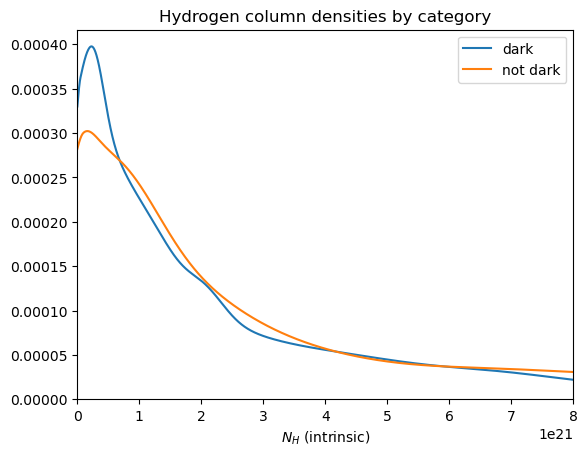

In [11]:
dark_nh = sGRBs.loc[sGRBs["GRB"].isin(dark_matches["GRB"]) & sGRBs["N_H (intrinsic)"].notna(), "N_H (intrinsic)"]
# dark_nh = [v for v in dark_nh if v.value>0]
notdark_nh = sGRBs.loc[~sGRBs["GRB"].isin(dark_matches["GRB"]) & sGRBs["N_H (intrinsic)"].notna(), "N_H (intrinsic)"]
# notdark_nh = [v for v in notdark_nh if v.value>0]
max_x = 8e21
x = np.linspace(0,max_x,10000)
p_NH_dark = np.sum([nh.pdf(x) for nh in dark_nh],axis=0)
plt.plot(x,p_NH_dark/np.sum(p_NH_dark),label="dark")
p_NH_notdark = np.sum([nh.pdf(x) for nh in notdark_nh],axis=0)
plt.plot(x,p_NH_notdark/np.sum(p_NH_notdark),label="not dark")
plt.xlabel("$N_H$ (intrinsic)")
plt.xlim(0,max_x)
plt.ylim(0)
plt.legend()
plt.title("Hydrogen column densities by category")
# plt.savefig("./products/NH_dists.png",dpi=300,bbox_inches="tight",facecolor="white",transparent=False)
plt.show()

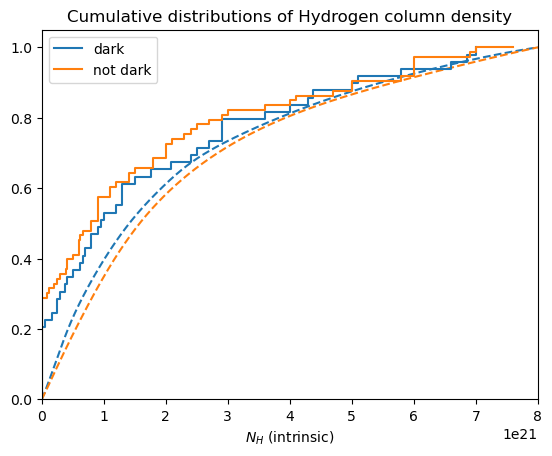

In [12]:
plt.plot(x,np.cumsum(p_NH_dark)/np.sum(p_NH_dark),color="tab:blue",linestyle="--")
plt.plot(x,np.cumsum(p_NH_notdark)/np.sum(p_NH_notdark),color="tab:orange",linestyle="--")
x1 = np.sort([v.value for v  in dark_nh if v.value<max_x])
plt.step(x1, np.linspace(0, 1, len(x1)), where="pre", label="dark")
x2 = np.sort([v.value for v  in notdark_nh if v.value<max_x])
plt.step(x2, np.linspace(0, 1, len(x2)), where="pre", label="not dark")
plt.xlabel("$N_H$ (intrinsic)")
plt.xlim(0,max_x)
plt.ylim(0)
plt.legend()
plt.title("Cumulative distributions of Hydrogen column density")
plt.show()

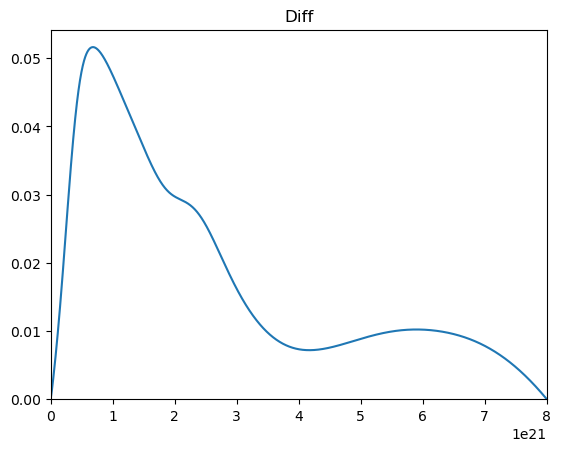

In [13]:
plt.plot(x,np.cumsum(p_NH_dark)/np.sum(p_NH_dark)-np.cumsum(p_NH_notdark)/np.sum(p_NH_notdark))
plt.title("Diff")
plt.xlim(0,max_x)
plt.ylim(0,)
plt.show()

In [14]:
stats.ks_2samp(sGRBs.loc[~sGRBs["GRB"].isin(dark_matches["GRB"]) & sGRBs["N_H (intrinsic)"].notna(), "N_H (intrinsic)"],
               sGRBs.loc[sGRBs["GRB"].isin(dark_matches["GRB"]) & sGRBs["N_H (intrinsic)"].notna(), "N_H (intrinsic)"])

KstestResult(statistic=0.09937888198757763, pvalue=0.8401364721213)

In [ ]:
comparison_table = pd.DataFrame(columns=["GRB","nu_o","F_o","nu_x","F_x","B_x","B_ox","N_H","Dark"])

for i,row in darkest_times.iterrows():
    grb = row["GRB"]
    b_ox = row[B_ox_name]
    b_x = row["B_x"]
    t_o = row["t_o"]
    flag = row["vdH_dark"] or row["Jak_dark"]
    try:
        n_h = sGRBs.loc[sGRBs["GRB"]==grb,"N_H (intrinsic)"].values[0]
    except IndexError:
        continue
#     n_h = (a_u(n_h)+1)/1e21 - 1e-21
    if np.isfinite(b_ox.minus):
        neg = b_ox.minus
    else:
        neg = 1
    if np.isfinite(b_ox.plus):
        pos = b_ox.plus
    else:
        pos = 1
    if np.isfinite(b_ox.value) and np.isfinite(b_x.value):
        comparison_table = pd.concat([comparison_table, pd.DataFrame([{"GRB":grb,"t_o":t_o,"nu_o":row["nu_o"],"F_o":row["F_o"],
                                                                       "nu_x":row["nu_x"],"F_x":row["F_x"],"B_x":b_x,
                                                                       "B_ox":a_u(b_ox.value,pos,neg),
                                                                       "N_H":n_h,"Dark":flag}])], ignore_index=True)

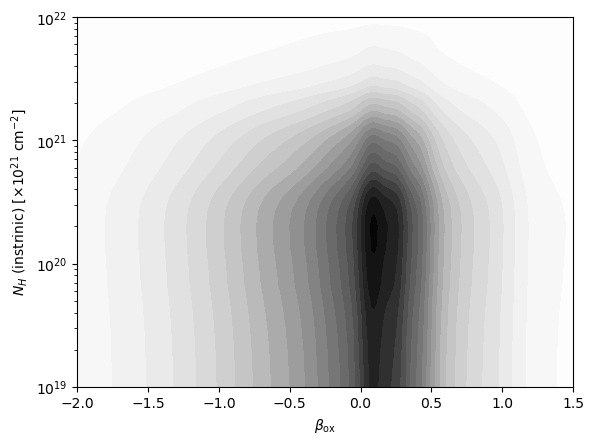

In [17]:
x,y = np.linspace(-2,1.5,250),np.linspace(0,10e21,150)
X,Y = np.meshgrid(x,y)
Z1 = np.sum([box.pdf(X) for box in comparison_table["B_ox"]],axis=0)
Z2 = np.sum([NH.pdf(Y) for NH in comparison_table["N_H"]],axis=0)
plt.contourf(X,Y,Z1*Z2,25,cmap="Greys")
plt.yscale("log")
plt.ylim(0.01e21,10e21)
plt.xlabel(r"$\beta_\mathrm{ox}$")
plt.ylabel(r"$N_H$ (instrinic) [$\times10^{21}$ cm$^{-2}$]")
# plt.colorbar(label="Probability density")
plt.savefig("./products/B_ox-N_H.png",dpi=300,bbox_inches="tight",facecolor="white")

error term: $\sigma_{\beta_x} \cdot \frac{-2.5}{\ln(10)}(\ln(\nu_o) - \ln(\nu_x))$

error term: $\sigma_{F_x} \cdot -\frac{2.5}{\ln(10)F_x}$

$$ \sigma_{m_\text{AB}} =  \sqrt{\left(\sigma_{\beta_x} \cdot \frac{-2.5}{\ln(10)}(\ln(\nu_o) - \ln(\nu_x))\right)^2 + \left(\sigma_{F_x} \cdot -\frac{2.5}{\ln(10)F_x}\right)^2} $$

In [18]:
E_x = log_mean(0.3,10)
nu_x = E_x*241797944177033445
# nu_x = a_u(nu_x,10-nu_x,nu_x-0.3)
ABmag = lambda flux : -2.5*np.log10(flux/3631) # flux in Jy -> AB magnitude

for i,row in comparison_table.iterrows():
    A_Bx = row["F_x"]/(nu_x**-row["B_x"])
    A_Bx05 = row["F_x"]/(nu_x**-(row["B_x"]-0.5))
    optflux_BoxBx = A_Bx*nu_o**-row["B_x"]
    optflux_BoxBx05 = A_Bx05*nu_o**-(row["B_x"]-0.5)
    
    obs_mag = ABmag(row["F_o"])
    
    m_plus = np.sqrt((row["B_x"].minus*-2.5/np.log(10) * (np.log(row["nu_o"])-np.log(row["nu_x"].value)))**2 + \
                     (row["F_x"].plus*-2.5/np.log(10)/row["F_x"].value)**2)
    m_minus = np.sqrt((row["B_x"].plus*-2.5/np.log(10) * (np.log(row["nu_o"])-np.log(row["nu_x"].value)))**2 + \
                      (row["F_x"].minus*-2.5/np.log(10)/row["F_x"].value)**2)
    
    unext_mag = a_u(ABmag(optflux_BoxBx),m_plus,m_minus)
    Av = obs_mag - unext_mag
    if np.isinf(Av.minus):
        Av.minus = 10
    comparison_table.loc[i,"Av (B_ox=B_x)"] = Av
    
    unext_mag = a_u(ABmag(optflux_BoxBx05),m_plus,m_minus)
    Av = obs_mag - unext_mag
    if np.isinf(Av.minus):
        Av.minus = 10
    comparison_table.loc[i,"Av (B_ox=B_x-0.5)"] = Av
    
    print(obs_mag,unext_mag,obs_mag-unext_mag,sep=" | ")

19.95395419855796 (+0.0, -inf) | 6.062096841311777 (+4.409696364338757, -5.1400268078517035) | 13.891857357246181 (+5.1400268078517035, -inf)
21.330252307550786 (+0.0, -inf) | 20.533718422620147 (+2.0001625391873272, -2.1354039560365004) | 0.7965338849306391 (+2.1354039560365004, -inf)
20.001333246396705 (+0.0, -inf) | 20.659466403356493 (+1.5203445500312893, -1.5816710436171058) | -0.6581331569597886 (+1.5816710436171058, -inf)
23.64141753622078 (+0.0, -inf) | 31.19345162964709 (+2.9110496146347193, -7.2540756207436505) | -7.552034093426311 (+7.2540756207436505, -inf)
20.144378009658872 ± 0.10999999999999997 | 17.293620205189047 (+1.4575396446155708, -1.5920348787963094) | 2.8507578044698256 (+1.5958305221119127, -1.461684581442277)
21.638220806745878 (+0.0, -inf) | 25.150086193163045 (+7.620177764359282, -22.56625074765676) | -3.511865386417167 (+22.56625074765676, -inf)
24.356148314792897 (+0.0, -inf) | 22.071352853233243 (+2.2315865077033634, -2.377364690086526) | 2.284795461559653

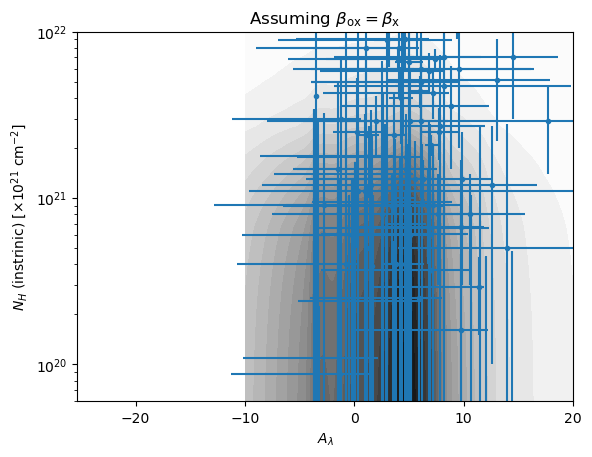

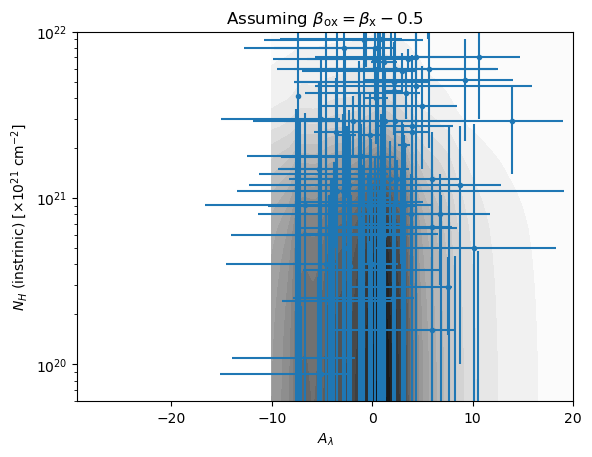

In [19]:
x,y = np.linspace(-10,20,250),np.linspace(0,10e22,150)
X,Y = np.meshgrid(x,y)
NH = UncertaintyArray(comparison_table["N_H"])
Av = UncertaintyArray(comparison_table["Av (B_ox=B_x)"])
Z1 = Av.pdf(X)
Z2 = NH.pdf(Y)
plt.contourf(X,Y,Z1*Z2,25,cmap="binary")
plt.errorbar(Av.values,NH.values,xerr=(Av.minus,Av.plus),yerr=[NH.minus,NH.plus],marker=".",linestyle="")
plt.yscale("log")
plt.ylim(0.06e21,10e21)
plt.xlabel(r"$A_\lambda$")
plt.ylabel(r"$N_H$ (instrinic) [$\times10^{21}$ cm$^{-2}$]")
plt.title(r"Assuming $\beta_\mathrm{ox}=\beta_\mathrm{x}$")
plt.show()

Av = UncertaintyArray(comparison_table["Av (B_ox=B_x-0.5)"])
Z1 = Av.pdf(X)
Z2 = NH.pdf(Y)
plt.contourf(X,Y,Z1*Z2,25,cmap="binary")
plt.errorbar(Av.values,NH.values,xerr=(Av.minus,Av.plus),yerr=[NH.minus,NH.plus],marker=".",linestyle="")
plt.yscale("log")
plt.ylim(0.06e21,10e21)
plt.xlabel(r"$A_\lambda$")
plt.ylabel(r"$N_H$ (instrinic) [$\times10^{21}$ cm$^{-2}$]")
plt.title(r"Assuming $\beta_\mathrm{ox}=\beta_\mathrm{x}-0.5$")
plt.show()

In [ ]:
Z = np.sum([row["Av (B_ox=B_x)"].pdf(x) for i,row in comparison_table.iterrows() if (all(np.isfinite(row["Av (B_ox=B_x)"].items())) and row["t_o"]>1000)],axis=0)
plt.plot(x,Z)
plt.xlim(x.min(),x.max())

### Observation depth over time

150301A


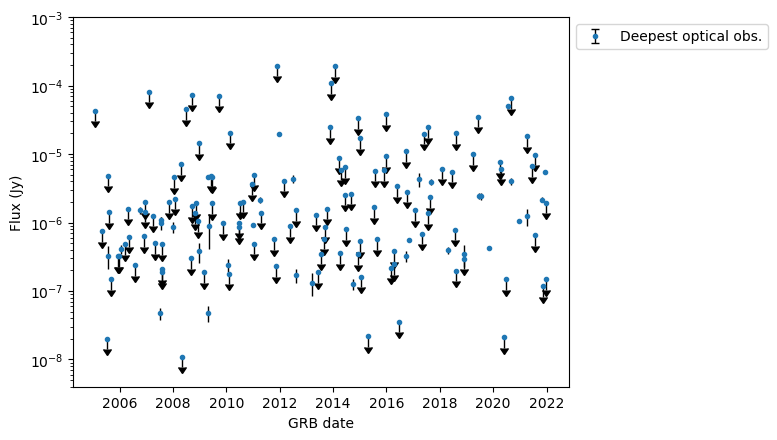

In [21]:
fig = plt.figure()
datestamps = []
deepests = []
for grb,opt in all_optical.dropna(subset=["Flux (Jy)"]).groupby("GRB"):
    yy = grb[:2]
    mm = grb[2:4]
    dd = grb[4:6]
    deepest_obs = min(opt["Flux (Jy)"])
    if deepest_obs>1e-1:
        print(grb)
    if pd.notna(deepest_obs):
        datestamps.append(mm+"/"+dd+"/20"+yy)
        deepests.append(deepest_obs)
datestamps = pd.to_datetime(datestamps)
vals = [v.value for v in deepests]
pos = [0.3*v.value if np.isinf(v.plus) else v.plus for v in deepests]
neg = [0.3*v.value if np.isinf(v.minus) else v.minus for v in deepests]
plt.errorbar(datestamps,[d.value for d in deepests],yerr=(neg,pos),linestyle="",marker=".",
             ecolor="k",elinewidth=1,label="Deepest optical obs.",
             uplims=[np.isinf(point.minus) for point in deepests],
                lolims=[np.isinf(point.plus) for point in deepests],capsize=0)
#plt.plot(df.Date,df.Value,":",label=r"Log regression (R$^2=%.2f$)"%(r*r))
plt.yscale("log")
plt.ylim(4e-9,1e-3)
plt.ylabel("Flux (Jy)")
plt.xlabel("GRB date")
plt.legend(loc="upper left",bbox_to_anchor=(1,1))
plt.show()
fig.savefig("./products/deepest_flux_over_time.png",bbox_inches="tight",dpi=300)

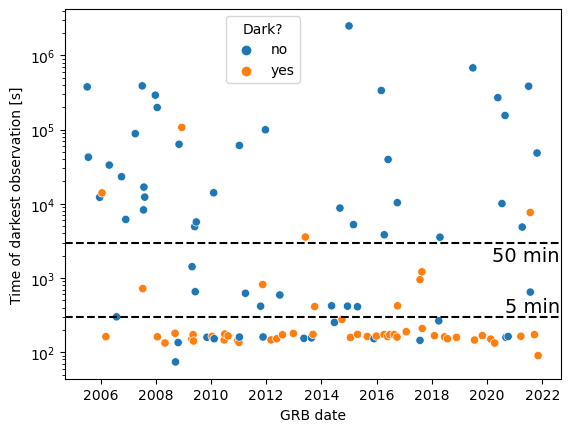

In [48]:
fig,ax = plt.subplots()
datestamps = []
darkest_t = []
cs = []

for grb,data in results.groupby("GRB"):
    yy = grb[:2]
    mm = grb[2:4]
    dd = grb[4:6]
#     data = data[data["t_o"]>500]
    try:
        datestamps.append(mm+"/"+dd+"/20"+yy)
        point = data.loc[data[B_ox_name]==data[B_ox_name].min(),:]
        darkest_t.append(float(point["t_o"]))
        if all(point["Jak_dark"]) or all(point["vdH_dark"]):
            cs.append("yes")
        else:
            cs.append("no")
    except:
        continue

datestamps = pd.to_datetime(datestamps)
sns.scatterplot(x="Date",y="Time",hue="Dark?",palette="tab10",
                data=pd.DataFrame(zip(datestamps,darkest_t,cs),
                                  columns=["Date","Time","Dark?"]))
plt.axhline(300,linestyle="--",color="k")
plt.text(18500,350,"5 min",size=14)
plt.axhline(3000,linestyle="--",color="k")
plt.text(18325,1700,"50 min",size=14)
plt.xlabel("GRB date")
plt.ylabel("Time of darkest observation [s]")
# plt.rcParams['legend.title_fontsize'] = 14
plt.legend(title="Dark?",loc="upper center",bbox_to_anchor=(.4,1))
plt.yscale("log")
# plt.ylim(4e2,4e6)
plt.savefig("./products/darkest_time_over_time.png",dpi=300,bbox_inches="tight")
plt.show()

### Time distributions of dark vs. not dark observation pairs

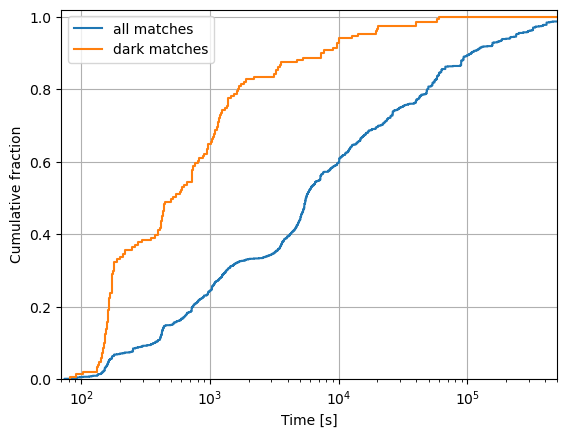

In [49]:
plt.step(close_times["t_o"].sort_values(ascending=True),np.linspace(0,1,len(close_times)),label="all matches")
plt.step(close_times.loc[close_times["vdH_dark"]|close_times["Jak_dark"],"t_o"].sort_values(ascending=True),np.linspace(0,1,sum(close_times["vdH_dark"]|close_times["Jak_dark"])),label="dark matches")
plt.legend()
plt.xscale("log")
plt.xlim(70,5e5)
plt.ylim(0,1.02)
plt.ylabel("Cumulative fraction")
plt.xlabel("Time [s]")
plt.grid()

KstestResult(statistic=0.581453634085213, pvalue=6.418692891331224e-42)

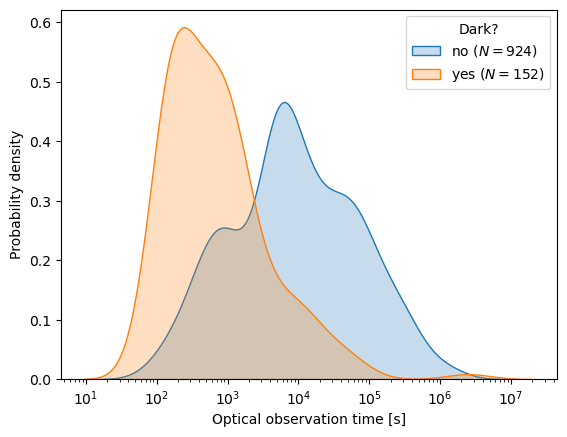

In [50]:
sns.kdeplot(data=close_times[~(close_times["vdH_dark"]|close_times["Jak_dark"])],x="t_o",
            fill=True,log_scale=True,bw_adjust=1.2,
            label="no ($N=%d$)"%sum(~(close_times["vdH_dark"]|close_times["Jak_dark"])))
sns.kdeplot(data=close_times[close_times["vdH_dark"]|close_times["Jak_dark"]],x="t_o",
            fill=True,log_scale=True,bw_adjust=1.2,
            label="yes ($N=%d$)"%sum(close_times["vdH_dark"]|close_times["Jak_dark"]))
plt.legend(title="Dark?")
plt.xlabel("Optical observation time [s]")
plt.ylabel("Probability density")
plt.savefig("./products/t_o_dist_split.png",dpi=300,bbox_inches="tight")
stats.ks_2samp(close_times.loc[(close_times["vdH_dark"]|close_times["Jak_dark"]), "t_o"],
               close_times.loc[~(close_times["vdH_dark"]|close_times["Jak_dark"]), "t_o"],)

### $T_{90}$ sample

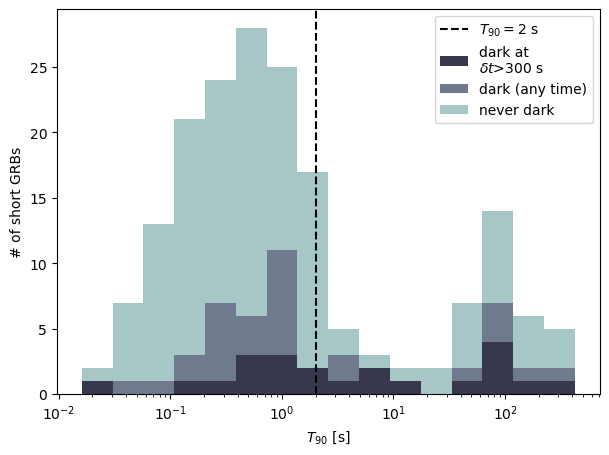

In [16]:
ee_cut = 2
early_cut = 300
for i,row in sGRBs.iterrows():
    grb = row["GRB"].strip()
    if grb in dark_matches["GRB"].values:
        if len(dark_matches[(dark_matches["GRB"]==grb) & (dark_matches["t_o"]>=early_cut)]):
            sGRBs.loc[i,"flag"] = "short+dark+late"
        else:
            sGRBs.loc[i,"flag"] = "short+dark"
    else:
        sGRBs.loc[i,"flag"] = "short"
fig, ax = plt.subplots(figsize=(7,5))
ax.axvline(ee_cut,linestyle="--",color="k")
sns.histplot(data=sGRBs.sort_values(by="flag"),x="T90",hue="flag",log_scale=True,ax=ax,multiple="stack",bins=16,palette="bone_r",alpha=1.,
             element="step",fill=True,edgecolor="none")
# plt.xticks(ticks=range(-2,4), labels=["$10^{%d}$"%int(i) for i in range(-2,4)])
plt.xlabel("$T_{90}$ [s]")
plt.ylabel("# of short GRBs")
plt.legend(labels=["$T_{90}=2$ s",f"dark at\n$\delta t$>{early_cut} s","dark (any time)","never dark"])
plt.savefig("./products/T90hist.png",dpi=300,bbox_inches="tight",facecolor="white",transparent=False)

In [20]:
ee_cut = 20
split_20s = [len(sGRBs.loc[sGRBs["GRB"].isin(dark_matches.loc[dark_matches["t_o"]>=early_cut,"GRB"]) & (sGRBs["T90"]>ee_cut)]),
             len(sGRBs.loc[sGRBs["GRB"].isin(dark_matches["GRB"]) & (sGRBs["T90"]>ee_cut)]),
             len(sGRBs.loc[sGRBs["T90"]>ee_cut]),
             len(sGRBs.loc[sGRBs["GRB"].isin(dark_matches.loc[dark_matches["t_o"]>=early_cut,"GRB"]) & (sGRBs["T90"]<=ee_cut)]),
             len(sGRBs.loc[sGRBs["GRB"].isin(dark_matches["GRB"]) & (sGRBs["T90"]<=ee_cut)]),
             len(sGRBs.loc[sGRBs["T90"]<=ee_cut])]
ee_cut = 2
split_2s = [len(sGRBs.loc[sGRBs["GRB"].isin(dark_matches.loc[dark_matches["t_o"]>=early_cut,"GRB"]) & (sGRBs["T90"]>ee_cut)]),
            len(sGRBs.loc[sGRBs["GRB"].isin(dark_matches["GRB"]) & (sGRBs["T90"]>ee_cut)]),
            len(sGRBs.loc[sGRBs["T90"]>ee_cut]),
            len(sGRBs.loc[sGRBs["GRB"].isin(dark_matches.loc[dark_matches["t_o"]>=early_cut,"GRB"]) & (sGRBs["T90"]<=ee_cut)]),
            len(sGRBs.loc[sGRBs["GRB"].isin(dark_matches["GRB"]) & (sGRBs["T90"]<=ee_cut)]),
            len(sGRBs.loc[sGRBs["T90"]<=ee_cut])]

ee_table = pd.DataFrame(np.array(split_20s+split_2s).reshape(3,4,order="F"),
                        columns=["$T_{90}>20$s",r"$T_{90}\leq20$s","$T_{90}>2$s",r"$T_{90}\leq2$s"],
                        index=["short/dark/late","short/dark","short"])

for col in ee_table.columns:
    col_total = ee_table.loc["short", col]
    for row in ("short/dark/late", "short/dark"):
        val = ee_table.loc[row, col]
        frac = a_u(val, np.sqrt(val), np.sqrt(val))/(a_u(col_total, np.sqrt(col_total), np.sqrt(col_total)))
        constructed_str = str(val) + f" (${frac.value:.0%} \pm {frac.plus:.0%}$".replace("%","") + r" \%)"
        ee_table.loc[row, col] = constructed_str
print(ee_table.T.style.to_latex().replace("llll", "cccc"))

\begin{tabular}{cccc}
 & short/dark/late & short/dark & short \\
$T_{90}>20$s & 7 ($22 \pm 9$ \%) & 13 ($41 \pm 13$ \%) & 32 \\
$T_{90}\leq20$s & 15 ($10 \pm 3$ \%) & 38 ($26 \pm 5$ \%) & 149 \\
$T_{90}>2$s & 11 ($22 \pm 7$ \%) & 19 ($38 \pm 10$ \%) & 50 \\
$T_{90}\leq2$s & 11 ($8 \pm 3$ \%) & 32 ($24 \pm 5$ \%) & 131 \\
\end{tabular}



### Numbers

6.529411764705882 ± 0.4546948480511855 short bursts per year
3.176470588235294 ± 0.39514790713365894 dark short bursts per year


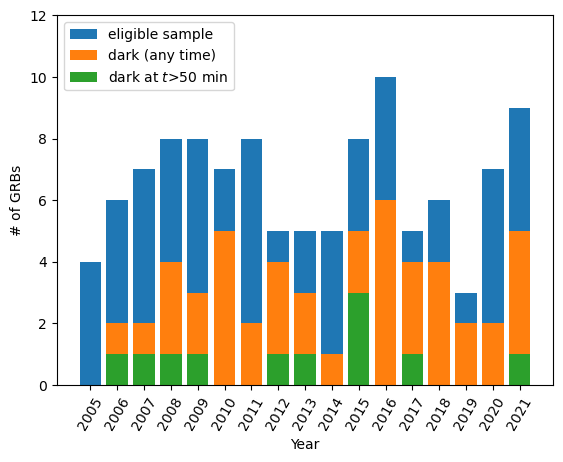

In [21]:
from src.utilities import addYear
addYear(sGRBs)
addYear(close_times)
addYear(all_optical)
addYear(results)
addYear(dark_matches)

dark_year_counts = {}
darklate_counts = {}
all_year_counts = {}

for year in range(2005,2022):
    sample = dark_matches[dark_matches["Year"]==year]
    dark_year_counts[str(year)] = len(sample["GRB"].unique())
        
for year in range(2005,2022):
    sample = results[results["Year"]==year]
    all_year_counts[str(year)] = len(sample["GRB"].unique())

for year in range(2005,2022):
    sample = dark_matches[(dark_matches["Year"]==year) & (dark_matches["t_o"]>50*60)]
    darklate_counts[str(year)] = len(sample["GRB"].unique())

plt.bar(all_year_counts.keys(),all_year_counts.values(),label="eligible sample")
plt.bar(dark_year_counts.keys(),dark_year_counts.values(),label="dark (any time)")
plt.bar(darklate_counts.keys(),darklate_counts.values(),label="dark at $t$>50 min")
plt.xlabel("Year")
plt.ylabel("# of GRBs")
plt.legend()
plt.xticks(rotation=60)
plt.ylim(0,12)
print(np.mean(list(all_year_counts.values())),"±",stats.sem(list(all_year_counts.values())),"short bursts per year")
print(np.mean(list(dark_year_counts.values())),"±",stats.sem(list(dark_year_counts.values())),"dark short bursts per year")
plt.savefig("./products/numbers.png",dpi=300,bbox_inches="tight")
plt.show()

In [12]:
close_times["time class"] = ["early" if t<300 else "mid" if (t>=300 and t<3000) else "late" if t>=3000 \
                             else None for t in close_times["t_o"]]
ct = pd.crosstab(close_times["time class"],close_times["Jak_dark"]|close_times["vdH_dark"],
                 rownames=["time"],colnames=["dark"])
display(ct)
chisq,p,dof,E = stats.chi2_contingency(ct)
chisq,p,dof

dark   False  True 
time               
early     39     58
late     680     26
mid      205     68

(256.40037516772657, 2.105551912128671e-56, 2)

In [18]:
conf = np.zeros((5,5))
tables = (sGRBs,all_optical,xrt_data,results,dark_matches)
names = ["main","optical","xray","matched","dark"]
for grb in sGRBs["GRB"].tolist():
    for i in range(5):
        for j in range(5):
            if j>i:
                conf[i,j] = np.nan
            elif grb in tables[i].GRB.tolist() and grb in tables[j].GRB.tolist():
                conf[i,j] += 1
conf 

array([[193.,  nan,  nan,  nan,  nan],
       [165., 165.,  nan,  nan,  nan],
       [163., 145., 163.,  nan,  nan],
       [108., 108., 108., 108.,  nan],
       [ 54.,  54.,  54.,  54.,  54.]])

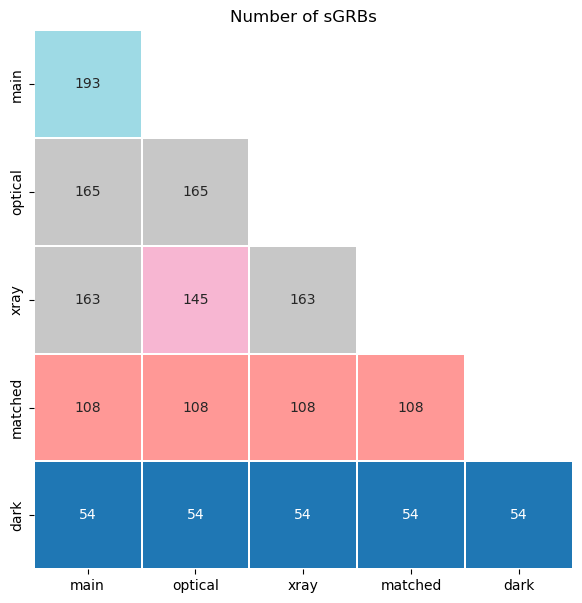

In [52]:
fig,ax = plt.subplots(figsize=(7,7))
sns.heatmap(data=conf,annot=True,fmt="g",
            cmap="tab20",cbar=False,
            xticklabels=names,
            yticklabels=names,
            square=True,linewidths=0.1,ax=ax)
for label in ax.yaxis.get_ticklabels():
    label.set_verticalalignment('center')
plt.title("Number of sGRBs")
plt.show()

### Violin plots

(10, 10000000.0)

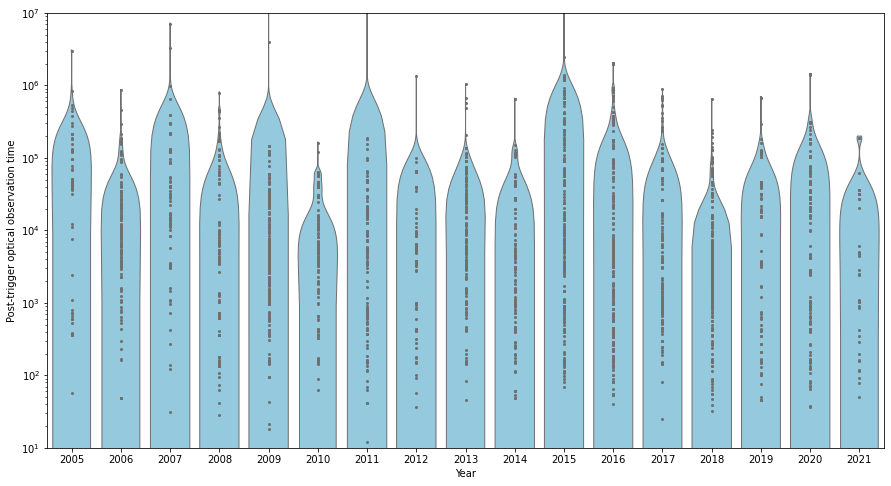

In [599]:
fig,ax = plt.subplots(figsize=(15,8))
sns.violinplot(x="Year",y="Time (s)",data=all_optical,linewidth=1,color="skyblue",
               scale="width",cut=.5,inner="point",ax=ax)
plt.ylabel("Post-trigger optical observation time")
plt.yscale("log")
plt.ylim(10,1e7)

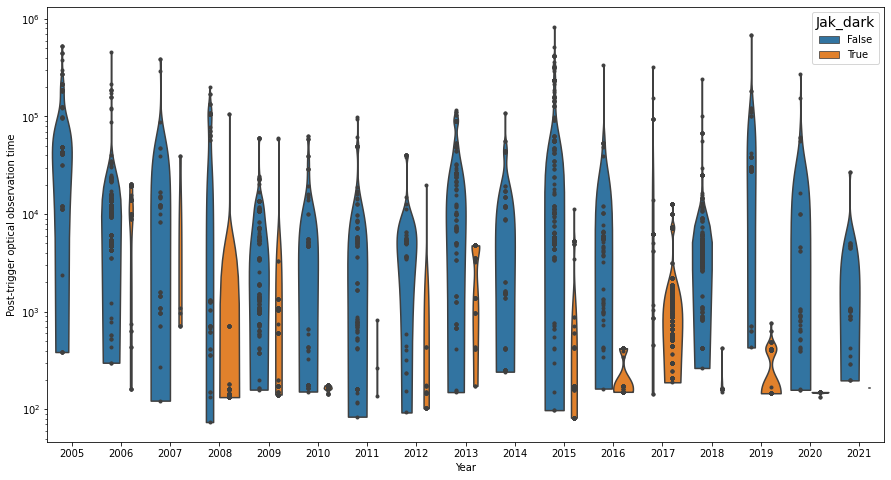

In [35]:
fig,ax = plt.subplots(figsize=(15,8))
sns.violinplot(x="Year",y="t_o",data=results[(results["t_o"]<1e6) & (results["Year"]>2004)],
               scale="count",inner="point",cut=0,hue="Jak_dark",split=False,ax=ax)
plt.ylabel("Post-trigger optical observation time")
plt.yscale("log")
#plt.ylim(1,1e5)

## Optical spectra

In [48]:
for grb,data in results.groupby("GRB"):
    done = []
    for t_o in data["t_o"].unique():
        tmatch = data[np.abs(data["t_o"]-t_o)/t_o < 0.1].copy()
        for to,obs in tmatch.groupby("t_o"):
            tmatch.drop(tmatch[tmatch["dt%"]!=tmatch["dt%"].min()].index,axis=0,inplace=True)
        if t_o not in done and len(tmatch["nu_o"].unique()) > 2:
                print(grb,t_o)
                display(tmatch)
                done += tmatch["t_o"].unique().tolist()

060121 9000.0


GRB     t_o       dt%          nu_o  \
3490  060121  9720.0  0.116364  4.863784e+14   
3491  060121  9720.0  0.116364  4.863784e+14   
3492  060121  9720.0  0.116364  4.863784e+14   
3493  060121  9720.0  0.116364  4.863784e+14   
3494  060121  9720.0  0.116364  4.863784e+14   
3500  060121  9720.0  0.116364  3.916501e+14   
3501  060121  9720.0  0.116364  3.916501e+14   
3502  060121  9720.0  0.116364  3.916501e+14   
3503  060121  9720.0  0.116364  3.916501e+14   
3504  060121  9720.0  0.116364  3.916501e+14   
3510  060121  9720.0  0.116364  2.935631e+14   
3511  060121  9720.0  0.116364  2.935631e+14   
3512  060121  9720.0  0.116364  2.935631e+14   
3513  060121  9720.0  0.116364  2.935631e+14   
3514  060121  9720.0  0.116364  2.935631e+14   
3520  060121  9720.0  0.116364  3.372244e+14   
3521  060121  9720.0  0.116364  3.372244e+14   
3522  060121  9720.0  0.116364  3.372244e+14   
3523  060121  9720.0  0.116364  3.372244e+14   
3524  060121  9720.0  0.116364  3.372244e+14   

                                      F_o  \
3490  3.7239072180869405e-06 (+0.0, -inf)   
3491  3.7239072180869405e-06 (+0.0, -inf)   
3492  3.7239072180869405e-06 (+0.0, -inf)   
3493  3.7239072180869405e-06 (+0.0, -inf)   
3494  3.7239072180869405e-06 (+0.0, -inf)   
3500   4.873884834658412e-06 (+0.0, -inf)   
3501   4.873884834658412e-06 (+0.0, -inf)   
3502   4.873884834658412e-06 (+0.0, -inf)   
3503   4.873884834658412e-06 (+0.0, -inf)   
3504   4.873884834658412e-06 (+0.0, -inf)   
3510   8.410891167436347e-06 (+0.0, -inf)   
3511   8.410891167436347e-06 (+0.0, -inf)   
3512   8.410891167436347e-06 (+0.0, -inf)   
3513   8.410891167436347e-06 (+0.0, -inf)   
3514   8.410891167436347e-06 (+0.0, -inf)   
3520                   1.08e-05 ± 2.5e-06   
3521                   1.08e-05 ± 2.5e-06   
3522                   1.08e-05 ± 2.5e-06   
3523                   1.08e-05 ± 2.5e-06   
3524                   1.08e-05 ± 2.5e-06   

                                                   nu_x  \
3490  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3491  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3492  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3493  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3494  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3500  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3501  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3502  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3503  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3504  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3510  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3511  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3512  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3513  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3514  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3520  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3521  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3522  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3523  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3524  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                  F_x  \
3490                                6.1e-07 ± 1.4e-07   
3491                                4.2e-07 ± 9.5e-08   
3492  4.5000000000000003e-07 ± 1.0000000000000001e-07   
3493                 4.6999999999999995e-07 ± 1.1e-07   
3494                 3.4000000000000003e-07 ± 8.7e-07   
3500                                6.1e-07 ± 1.4e-07   
3501                                4.2e-07 ± 9.5e-08   
3502  4.5000000000000003e-07 ± 1.0000000000000001e-07   
3503                 4.6999999999999995e-07 ± 1.1e-07   
3504                 3.4000000000000003e-07 ± 8.7e-07   
3510                                6.1e-07 ± 1.4e-07   
3511                                4.2e-07 ± 9.5e-08   
3512  4.5000000000000003e-07 ± 1.0000000000000001e-07   
3513            

080503 620.0


GRB    t_o       dt%          nu_o  \
3168  080503  620.0  0.123748  6.361576e+14   
3169  080503  620.0  0.123748  4.626870e+14   
3170  080503  620.0  0.123748  3.821188e+14   

                                      F_o  \
3168  0.00013164354645135812 (+0.0, -inf)   
3169   8.539105490522088e-05 (+0.0, -inf)   
3170  0.00022789739450369243 (+0.0, -inf)   

                                                   nu_x  \
3168  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3169  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3170  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                              F_x  \
3168  1.0110433739701649e-07 ± 2.297938039451e-08   
3169  1.0110433739701649e-07 ± 2.297938039451e-08   
3170  1.0110433739701649e-07 ± 2.297938039451e-08   

                                                 B_ox    α  \
3168  1.1050866413669602 (+0.14467013193440337, -inf)  8.0   
3169  0.9898254392685115 (+0.12432396480109532, -inf)  8.0   
3170   1.103017708565408 (+0.13389709922806223, -inf)  8.0   

                                           B_ox_w_err  \
3168  1.1050866413669602 (+0.43039424861514924, -inf)   
3169  0.9898254392685115 (+0.42398845549253483, -inf)   
3170    1.103017708565408 (+0.4268936581266706, -inf)   

                                    B_x Jak_dark vdH_dark  Year  
3168  1.4500000000000002 (+0.32, -0.24)    False    False  2008  
3169  1.4500000000000002 (+0.32, -0.24)    False    False  2008  
3170  1.4500000000000002 (+0.32, -0.24)    False    False  2008

080913 180.0


GRB    t_o       dt%          nu_o  \
3019  080913  180.0  0.004001  4.916258e+14   
3020  080913  180.0  0.004001  3.942179e+14   
3021  080913  180.0  0.004001  3.357390e+14   

                                     F_o  \
3019  2.121749687386341e-06 (+0.0, -inf)   
3020  2.472131557899378e-06 (+0.0, -inf)   
3021         4.219450020502084e-06 ± 0.0   

                                                   nu_x  \
3019  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3020  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3021  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                F_x  \
3019  1.903896944943868e-06 ± 4.415637365634573e-07   
3020  1.903896944943868e-06 ± 4.415637365634573e-07   
3021  1.903896944943868e-06 ± 4.415637365634573e-07   

                                                   B_ox    α  \
3019  0.01605618847209473 (+0.033966781132171324, -inf)  1.2   
3020   0.03748108498254906 (+0.03313499678972337, -inf)  1.2   
3021  0.11163150427182805 (+0.03460854883856727, -0....  1.2   

                                             B_ox_w_err  \
3019   0.01605618847209473 (+0.03403045409397591, -inf)   
3020   0.03748108498254906 (+0.03320026502328483, -inf)   
3021  0.11163150427182805 (+0.034671043221582876, -0...   

                                   B_x Jak_dark vdH_dark  Year  
3019  0.6599999999999999 (+0.23, -0.2)     True    False  2008  
3020  0.6599999999999999 (+0.23, -0.2)     True    False  2008  
3021  0.6599999999999999 (+0.23, -0.2)     True    False  2008

080913 360.0


GRB    t_o       dt%          nu_o  \
3022  080913  360.0  0.090916  2.455797e+14   
3023  080913  360.0  0.090916  1.838814e+14   
3024  080913  360.0  0.090916  1.369818e+14   

                                      F_o  \
3022   0.0005394043662051895 (+0.0, -inf)   
3023  0.00048688466512590166 (+0.0, -inf)   
3024   0.0017573716758739568 (+0.0, -inf)   

                                                   nu_x  \
3022  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3023  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3024  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                 F_x  \
3022  1.0871714979756532e-06 ± 2.577277212404609e-07   
3023  1.0871714979756532e-06 ± 2.577277212404609e-07   
3024  1.0871714979756532e-06 ± 2.577277212404609e-07   

                                                 B_ox    α  \
3022  0.8340860037015736 (+0.09786142192508118, -inf)  1.2   
3023  0.7896194722319819 (+0.08970857648510752, -inf)  1.2   
3024  0.9205862265650239 (+0.09922308685231154, -inf)  1.2   

                                           B_ox_w_err  \
3022  0.8340860037015736 (+0.10785842933373392, -inf)   
3023  0.7896194722319819 (+0.10051970738181493, -inf)   
3024  0.9205862265650239 (+0.10909538872767571, -inf)   

                                   B_x Jak_dark vdH_dark  Year  
3022  0.6599999999999999 (+0.23, -0.2)    False    False  2008  
3023  0.6599999999999999 (+0.23, -0.2)    False    False  2008  
3024  0.6599999999999999 (+0.23, -0.2)    False    False  2008

080913 720.0


GRB    t_o       dt%          nu_o  \
3028  080913  720.0  0.087132  6.655414e+14   
3030  080913  720.0  0.087132  4.916258e+14   
3032  080913  720.0  0.087132  3.942179e+14   
3034  080913  720.0  0.087132  3.357390e+14   
3036  080913  720.0  0.087132  2.447983e+14   
3038  080913  720.0  0.087132  1.835816e+14   
3040  080913  720.0  0.087132  1.391121e+14   

                                                  F_o  \
3028              1.7379058652234989e-06 (+0.0, -inf)   
3030              1.7379058652234989e-06 (+0.0, -inf)   
3032               2.291006117807585e-06 (+0.0, -inf)   
3034     3.5647267811055704e-06 ± 4.9248520480622e-07   
3036   1.5849889868640448e-05 ± 8.758972832910923e-07   
3038  1.9589630703524253e-05 ± 1.6238444988669629e-06   
3040  2.2081381896430282e-05 ± 4.2709179061440324e-06   

                                                   nu_x  \
3028  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3030  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3032  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3034  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3036  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3038  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3040  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                 F_x  \
3028  3.1524048793554437e-07 ± 7.501152180985261e-08   
3030  3.1524048793554437e-07 ± 7.501152180985261e-08   
3032  3.1524048793554437e-07 ± 7.501152180985261e-08   
3034  3.1524048793554437e-07 ± 7.501152180985261e-08   
3036  3.1524048793554437e-07 ± 7.501152180985261e-08   
3038  3.1524048793554437e-07 ± 7.501152180985261e-08   
3040  3.1524048793554437e-07 ± 7.501152180985261e-08   

                                                   B_ox    α  \
3028   0.26489000672688745 (+0.04983506698980007, -inf)  1.2   
3030    0.2529994851385232 (+0.04661666694478352, -inf)  1.2   
3032    0.284634977772599 (+0.047718095625235796, -inf)  1.2   
3034  0.3402391403389642 (+0.05494124585817459, -0.2...  1.2   
3036  0.5262222241705741 (+0.06682880308734643, -0.3...  1.2   
3038  0.5340339423580948 (+0.06556209647062891, -0.3...  1.2   
3040  0.5304888899837922 (+0.06664551984915405, -0.3...  1.2   

                                             B_ox_w_err  \
3028   0.26489000672688745 (+0.06617518208200589, -inf)   
3030      0.2529994851385232 (+0.063786632288824, -inf)   
3032     0.284634977772599 (+0.06459595553754059, -inf)   
3034  0.3402391403389642 (+0.07010107929381086, -0.2...   
3036  0.5262222241705741 (+0.07976032687869387, -0.3...   
3038  0.5340339423580948 (+0.07870202866084726, -0.3...   
3040  0.5304888899837922 (+0.07960682218046868, -0.3...   

                                   B_x Jak_dark vdH_dark  Year  
3028  0.6599999999999999 (+0.23, -0.2)     True    False  2008  
3030  0.6599999999999999 (+0.23, -0.2)     True    False  2008  
3032  0.6599999999999999 (+0.23, -0.2)     True    False  2008  
3034  0.6599999999999999 (+0.23, -0.2)     True    False  2008  
3036  0.6599999999999999 (+0.23, -0.2)    False    False  2008  
3038  0.6599999999999999 (+0.23, -0.2)    False    False  2008  
3040  0.6599999999999999 (+0.23, -0.2)    False    False  2008

090423 13716.864000000001


GRB        t_o       dt%          nu_o  \
2986  090423  13716.864  0.124212  6.361576e+14   
2993  090423  13716.864  0.124212  4.626870e+14   
3000  090423  13716.864  0.124212  3.821188e+14   

                                      F_o  \
2986  2.7524086323556257e-05 (+0.0, -inf)   
2993   3.204197770117918e-05 (+0.0, -inf)   
3000   6.010115310236266e-05 (+0.0, -inf)   

                                                   nu_x  \
2986  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2993  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3000  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                 F_x  \
2986  1.123057848924482e-07 ± 2.9678819485253674e-08   
2993  1.123057848924482e-07 ± 2.9678819485253674e-08   
3000  1.123057848924482e-07 ± 2.9678819485253674e-08   

                                                B_ox     α  \
2986  0.847739734882957 (+0.11542435421285616, -inf)  1.41   
2993   0.830417564370326 (+0.1080604544762866, -inf)  1.41   
3000  0.8975812153941012 (+0.1125469306595297, -inf)  1.41   

                                           B_ox_w_err          B_x Jak_dark  \
2986   0.847739734882957 (+0.13587887920961053, -inf)  0.71 ± 0.13    False   
2993   0.830417564370326 (+0.12968172612757223, -inf)  0.71 ± 0.13    False   
3000  0.8975812153941012 (+0.13344324587886056, -inf)  0.71 ± 0.13    False   

     vdH_dark  Year  
2986    False  2009  
2993    False  2009  
3000    False  2009

090426 376.704


GRB      t_o       dt%          nu_o  \
2817  090426  376.704  0.088658  6.361576e+14   
2819  090426  376.704  0.088658  4.626870e+14   
2821  090426  376.704  0.088658  3.821188e+14   

                                                F_o  \
2817  0.0002900574494604127 ± 2.137222269566145e-05   
2819   0.0004541036146342407 ± 3.34595908394085e-05   
2821    0.0006495271153159908 ± 5.9823658128881e-05   

                                                   nu_x  \
2817  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2819  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2821  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                  F_x  \
2817  1.9067051798127283e-06 ± 4.2987684486984494e-07   
2819  1.9067051798127283e-06 ± 4.2987684486984494e-07   
2821  1.9067051798127283e-06 ± 4.2987684486984494e-07   

                                                   B_ox     α  \
2817  0.7742559346880049 (+0.10515512911583419, -0.5...  0.94   
2819  0.8038862677674623 (+0.10362029645527401, -0.5...  0.94   
2821  0.8330486864883209 (+0.10433901938502343, -0.5...  0.94   

                                             B_ox_w_err                  B_x  \
2817  0.7742559346880049 (+0.11072563169201569, -0.5...  0.96 (+0.16, -0.15)   
2819  0.8038862677674623 (+0.10926907234760906, -0.5...  0.96 (+0.16, -0.15)   
2821  0.8330486864883209 (+0.1099508767607446, -0.57...  0.96 (+0.16, -0.15)   

     Jak_dark vdH_dark  Year  
2817    False    False  2009  
2819    False    False  2009  
2821    False    False  2009

090426 964.224


GRB       t_o       dt%          nu_o  \
2846  090426  1035.072  0.014465  6.361576e+14   
2849  090426  1035.072  0.014465  4.626870e+14   
2852  090426  1035.072  0.014465  3.821188e+14   

                                                 F_o  \
2846  6.523550426659195e-05 ± 1.8626077157617312e-05   
2849  8.187568733739936e-05 ± 2.0360779611307614e-05   
2852  0.00017889462245997354 ± 4.283968945288582e-05   

                                                   nu_x  \
2846  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2849  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2852  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                F_x  \
2846  5.478940951090471e-07 ± 1.262003838027628e-07   
2849  5.478940951090471e-07 ± 1.262003838027628e-07   
2852  5.478940951090471e-07 ± 1.262003838027628e-07   

                                                   B_ox     α  \
2846  0.7365000297957721 (+0.10950500635973141, -0.5...  0.94   
2849  0.7354277515246661 (+0.10221589606917719, -0.5...  0.94   
2852  0.8269913854324535 (+0.1085776081541656, -0.56...  0.94   

                                             B_ox_w_err                  B_x  \
2846  0.7365000297957721 (+0.109661844571703, -0.544...  0.96 (+0.16, -0.15)   
2849  0.7354277515246661 (+0.10238390081574526, -0.5...  0.96 (+0.16, -0.15)   
2852  0.8269913854324535 (+0.10873578403406607, -0.5...  0.96 (+0.16, -0.15)   

     Jak_dark vdH_dark  Year  
2846    False    False  2009  
2849    False    False  2009  
2852    False    False  2009

090426 5040.0


GRB       t_o       dt%          nu_o  \
2899  090426  5480.352  0.020503  6.361576e+14   
2902  090426  5480.352  0.020503  4.626870e+14   
2905  090426  5480.352  0.020503  3.821188e+14   

                                                 F_o  \
2899   2.6211026155413417e-05 ± 9.17367395082486e-06   
2902  4.2968971527745086e-05 ± 8.706694770494286e-06   
2905    6.14606693826714e-05 ± 1.981257895763646e-05   

                                                   nu_x  \
2899  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2902  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2905  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                 F_x  \
2899  1.3680813654310403e-07 ± 3.642941631008612e-08   
2902  1.3680813654310403e-07 ± 3.642941631008612e-08   
2905  1.3680813654310403e-07 ± 3.642941631008612e-08   

                                                   B_ox     α  \
2899  0.8097973394603906 (+0.12340032416090582, -0.5...  0.94   
2902  0.8445297429445892 (+0.11369727557595544, -0.5...  0.94   
2905  0.8725812324595142 (+0.11910155347210366, -0.5...  0.94   

                                             B_ox_w_err                  B_x  \
2899  0.8097973394603906 (+0.1236781658597461, -0.59...  0.96 (+0.16, -0.15)   
2902  0.8445297429445892 (+0.11399876833022794, -0.5...  0.96 (+0.16, -0.15)   
2905  0.8725812324595142 (+0.11938939964202264, -0.5...  0.96 (+0.16, -0.15)   

     Jak_dark vdH_dark  Year  
2899    False    False  2009  
2902    False    False  2009  
2905    False    False  2009

090426 5760.0


GRB       t_o       dt%          nu_o  \
2899  090426  5480.352  0.020503  6.361576e+14   
2902  090426  5480.352  0.020503  4.626870e+14   
2905  090426  5480.352  0.020503  3.821188e+14   

                                                 F_o  \
2899   2.6211026155413417e-05 ± 9.17367395082486e-06   
2902  4.2968971527745086e-05 ± 8.706694770494286e-06   
2905    6.14606693826714e-05 ± 1.981257895763646e-05   

                                                   nu_x  \
2899  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2902  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2905  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                 F_x  \
2899  1.3680813654310403e-07 ± 3.642941631008612e-08   
2902  1.3680813654310403e-07 ± 3.642941631008612e-08   
2905  1.3680813654310403e-07 ± 3.642941631008612e-08   

                                                   B_ox     α  \
2899  0.8097973394603906 (+0.12340032416090582, -0.5...  0.94   
2902  0.8445297429445892 (+0.11369727557595544, -0.5...  0.94   
2905  0.8725812324595142 (+0.11910155347210366, -0.5...  0.94   

                                             B_ox_w_err                  B_x  \
2899  0.8097973394603906 (+0.1236781658597461, -0.59...  0.96 (+0.16, -0.15)   
2902  0.8445297429445892 (+0.11399876833022794, -0.5...  0.96 (+0.16, -0.15)   
2905  0.8725812324595142 (+0.11938939964202264, -0.5...  0.96 (+0.16, -0.15)   

     Jak_dark vdH_dark  Year  
2899    False    False  2009  
2902    False    False  2009  
2905    False    False  2009

090426 7200.0


GRB     t_o      dt%          nu_o  \
2914  090426  7200.0  0.04132  3.757363e+14   
2918  090426  7200.0  0.04132  4.673887e+14   
2922  090426  7200.0  0.04132  5.505123e+14   
2926  090426  7200.0  0.04132  4.163784e+14   

                                                F_o  \
2914  7.949221981227501e-05 ± 4.392902408370009e-06   
2918  2.893310868754059e-05 ± 5.329675580632599e-07   
2922  1.5630692105522657e-05 ± 5.75855978165699e-07   
2926                             2.46e-05 ± 3.9e-06   

                                                   nu_x  \
2914  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2918  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2922  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2926  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                 F_x  \
2914  8.770752409196573e-08 ± 2.3297121213128358e-08   
2918  8.770752409196573e-08 ± 2.3297121213128358e-08   
2922  8.770752409196573e-08 ± 2.3297121213128358e-08   
2926  8.770752409196573e-08 ± 2.3297121213128358e-08   

                                                   B_ox     α  \
2914  0.9705157538514715 (+0.12069646347029996, -0.6...  0.94   
2918  0.8530055786032785 (+0.11085890313044564, -0.6...  0.94   
2922  0.7812388003580433 (+0.10538116392544472, -0.5...  0.94   
2926  0.815279884549556 (+0.10724219591114781, -0.56...  0.94   

                                             B_ox_w_err                  B_x  \
2914  0.9705157538514715 (+0.12182302526321022, -0.6...  0.96 (+0.16, -0.15)   
2918  0.8530055786032785 (+0.1120843860371677, -0.60...  0.96 (+0.16, -0.15)   
2922  0.7812388003580433 (+0.10666959688835781, -0.5...  0.96 (+0.16, -0.15)   
2926  0.815279884549556 (+0.10850853318466853, -0.56...  0.96 (+0.16, -0.15)   

     Jak_dark vdH_dark  Year  
2914    False    False  2009  
2918    False    False  2009  
2922    False    False  2009  
2926    False    False  2009

110106A 8317.5


GRB       t_o       dt%          nu_o  \
2582  110106A  8584.704  0.131444  6.361576e+14   
2583  110106A  8584.704  0.131444  4.626870e+14   
2584  110106A  8584.704  0.131444  3.821188e+14   

                                      F_o  \
2582   3.610102623089009e-05 (+0.0, -inf)   
2583  4.0324665023164604e-05 (+0.0, -inf)   
2584   8.144767535214837e-05 (+0.0, -inf)   

                                                   nu_x  \
2582  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2583  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2584  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                  F_x  \
2582  4.0613023643797727e-08 ± 1.2711438854735009e-08   
2583  4.0613023643797727e-08 ± 1.2711438854735009e-08   
2584  4.0613023643797727e-08 ± 1.2711438854735009e-08   

                                                 B_ox     α  \
2582     1.04626862051361 (+0.1417520858924979, -inf)  1.11   
2583   1.013589174375667 (+0.13139777819425336, -inf)  1.11   
2584  1.0863205719340059 (+0.13588772208844457, -inf)  1.11   

                                           B_ox_w_err        B_x Jak_dark  \
2582    1.04626862051361 (+0.15374585570132585, -inf)  1.5 ± 0.5    False   
2583   1.013589174375667 (+0.14425501864699544, -inf)  1.5 ± 0.5    False   
2584  1.0863205719340059 (+0.14835635242498094, -inf)  1.5 ± 0.5    False   

     vdH_dark  Year  
2582    False  2011  
2583    False  2011  
2584    False  2011

120804A 40249.439999999995


GRB       t_o       dt%          nu_o  \
2419  120804A  40249.44  0.043178  6.361576e+14   
2421  120804A  40249.44  0.043178  4.626870e+14   
2423  120804A  40249.44  0.043178  3.821188e+14   

                                      F_o  \
2419   8.022147818660016e-05 (+0.0, -inf)   
2421    6.87078586326926e-05 (+0.0, -inf)   
2423  0.00011603611367984676 (+0.0, -inf)   

                                                   nu_x  \
2419  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2421  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2423  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                 F_x  \
2419  1.8369754505165708e-08 ± 4.956214647375757e-09   
2421  1.8369754505165708e-08 ± 4.956214647375757e-09   
2423  1.8369754505165708e-08 ± 4.956214647375757e-09   

                                                 B_ox      α  \
2419  1.2915571486591046 (+0.16968414926932468, -inf)  1.095   
2421  1.2083984399538599 (+0.15197536585438406, -inf)  1.095   
2423    1.25023728503006 (+0.15259899622738995, -inf)  1.095   

                                           B_ox_w_err                 B_x  \
2419  1.2915571486591046 (+0.17087078001922076, -inf)  0.96 (+0.21, -0.2)   
2421   1.2083984399538599 (+0.1532991349541685, -inf)  0.96 (+0.21, -0.2)   
2423    1.25023728503006 (+0.15391740187753122, -inf)  0.96 (+0.21, -0.2)   

     Jak_dark vdH_dark  Year  
2419    False    False  2012  
2421    False    False  2012  
2423    False    False  2012

121226A 3621.0


GRB       t_o       dt%          nu_o  \
2330  121226A  3743.712  0.147952  6.361576e+14   
2331  121226A  3743.712  0.147952  4.626870e+14   
2332  121226A  3743.712  0.147952  3.821188e+14   

                                     F_o  \
2330   3.57096118716993e-05 (+0.0, -inf)   
2331  3.366124705196544e-05 (+0.0, -inf)   
2332  6.231557414690432e-05 (+0.0, -inf)   

                                                   nu_x  \
2330  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2331  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2332  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                F_x  \
2330  9.076190564751554e-08 ± 2.680644949568071e-08   
2331  9.076190564751554e-08 ± 2.680644949568071e-08   
2332  9.076190564751554e-08 ± 2.680644949568071e-08   

                                                 B_ox     α  \
2330  0.9206772890969991 (+0.12581455551490522, -inf)  1.04   
2331  0.8689430854563214 (+0.11409591197826185, -inf)  1.04   
2332  0.9331795411056737 (+0.11803046160879098, -inf)  1.04   

                                           B_ox_w_err        B_x Jak_dark  \
2330  0.9206772890969991 (+0.14040353908743852, -inf)  1.4 ± 0.4    False   
2331   0.8689430854563214 (+0.1300066480569974, -inf)  1.4 ± 0.4    False   
2332  0.9331795411056737 (+0.13347299830470952, -inf)  1.4 ± 0.4    False   

     vdH_dark  Year  
2330    False  2012  
2331    False  2012  
2332    False  2012

130603B 43920.0


GRB      t_o       dt%          nu_o  \
2306  130603B  48222.0  0.003044  4.875221e+14   
2307  130603B  48222.0  0.003044  3.980626e+14   
2308  130603B  48222.0  0.003044  3.411380e+14   
2309  130603B  48222.0  0.003044  2.947018e+14   
2310  130603B  48222.0  0.003044  2.411140e+14   
2311  130603B  48222.0  0.003044  1.860597e+14   

                                                  F_o  \
2306   1.8467041630481676e-05 ± 5.102632172405707e-07   
2307   2.3198105676394787e-05 ± 6.409873477940062e-07   
2308  3.0929821070392294e-05 ± 1.4243708985131687e-06   
2309   3.909311382994146e-05 ± 1.8003044228708514e-06   
2310    3.782193109767061e-05 ± 2.090117153609863e-06   
2311    5.543684432520371e-05 ± 3.063553232300295e-06   

                                                   nu_x  \
2306  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2307  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2308  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2309  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2310  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2311  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                  F_x  \
2306  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2307  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2308  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2309  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2310  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2311  2.2546776018122463e-08 ± 5.2193438980126646e-09   

                                                   B_ox    α  \
2306  0.9929427727910082 (+0.12629745964193007, -0.7...  1.0   
2307  0.9967923134119577 (+0.12305813134006764, -0.6...  1.0   
2308  1.015606535995575 (+0.12260394563943981, -0.68...  1.0   
2309  1.027401035754334 (+0.12142665308775755, -0.67...  1.0   
2310  0.9953294612075222 (+0.11481140363912007, -0.6...  1.0   
2311  1.0114406539775094 (+0.11261521113185216, -0.6...  1.0   

                                             B_ox_w_err                  B_x  \
2306  0.9929427727910082 (+0.12630435934017228, -0.7...  0.97 (+0.14, -0.13)   
2307  0.9967923134119577 (+0.12306521265262474, -0.6...  0.97 (+0.14, -0.13)   
2308  1.015606535995575 (+0.12261105318316584, -0.68...  0.97 (+0.14, -0.13)   
2309  1.027401035754334 (+0.1214338295386464, -0.676...  0.97 (+0.14, -0.13)   
2310  0.9953294612075222 (+0.11481899355904215, -0.6...  0.97 (+0.14, -0.13)   
2311  1.0114406539775094 (+0.11262294905834268, -0.6...  0.97 (+0.14, -0.13)   

     Jak_dark vdH_dark  Year  
2306    False    False  2013  
2307    False    False  2013  
2308    False    False  2013  
2309    False    False  2013  
2310    False    False  2013  
2311    False    False  2013

130603B 51840.0


GRB      t_o       dt%          nu_o  \
2306  130603B  48222.0  0.003044  4.875221e+14   
2307  130603B  48222.0  0.003044  3.980626e+14   
2308  130603B  48222.0  0.003044  3.411380e+14   
2309  130603B  48222.0  0.003044  2.947018e+14   
2310  130603B  48222.0  0.003044  2.411140e+14   
2311  130603B  48222.0  0.003044  1.860597e+14   

                                                  F_o  \
2306   1.8467041630481676e-05 ± 5.102632172405707e-07   
2307   2.3198105676394787e-05 ± 6.409873477940062e-07   
2308  3.0929821070392294e-05 ± 1.4243708985131687e-06   
2309   3.909311382994146e-05 ± 1.8003044228708514e-06   
2310    3.782193109767061e-05 ± 2.090117153609863e-06   
2311    5.543684432520371e-05 ± 3.063553232300295e-06   

                                                   nu_x  \
2306  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2307  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2308  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2309  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2310  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2311  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                  F_x  \
2306  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2307  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2308  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2309  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2310  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2311  2.2546776018122463e-08 ± 5.2193438980126646e-09   

                                                   B_ox    α  \
2306  0.9929427727910082 (+0.12629745964193007, -0.7...  1.0   
2307  0.9967923134119577 (+0.12305813134006764, -0.6...  1.0   
2308  1.015606535995575 (+0.12260394563943981, -0.68...  1.0   
2309  1.027401035754334 (+0.12142665308775755, -0.67...  1.0   
2310  0.9953294612075222 (+0.11481140363912007, -0.6...  1.0   
2311  1.0114406539775094 (+0.11261521113185216, -0.6...  1.0   

                                             B_ox_w_err                  B_x  \
2306  0.9929427727910082 (+0.12630435934017228, -0.7...  0.97 (+0.14, -0.13)   
2307  0.9967923134119577 (+0.12306521265262474, -0.6...  0.97 (+0.14, -0.13)   
2308  1.015606535995575 (+0.12261105318316584, -0.68...  0.97 (+0.14, -0.13)   
2309  1.027401035754334 (+0.1214338295386464, -0.676...  0.97 (+0.14, -0.13)   
2310  0.9953294612075222 (+0.11481899355904215, -0.6...  0.97 (+0.14, -0.13)   
2311  1.0114406539775094 (+0.11262294905834268, -0.6...  0.97 (+0.14, -0.13)   

     Jak_dark vdH_dark  Year  
2306    False    False  2013  
2307    False    False  2013  
2308    False    False  2013  
2309    False    False  2013  
2310    False    False  2013  
2311    False    False  2013

130603B 52200.0


GRB      t_o       dt%          nu_o  \
2306  130603B  48222.0  0.003044  4.875221e+14   
2307  130603B  48222.0  0.003044  3.980626e+14   
2308  130603B  48222.0  0.003044  3.411380e+14   
2309  130603B  48222.0  0.003044  2.947018e+14   
2310  130603B  48222.0  0.003044  2.411140e+14   
2311  130603B  48222.0  0.003044  1.860597e+14   

                                                  F_o  \
2306   1.8467041630481676e-05 ± 5.102632172405707e-07   
2307   2.3198105676394787e-05 ± 6.409873477940062e-07   
2308  3.0929821070392294e-05 ± 1.4243708985131687e-06   
2309   3.909311382994146e-05 ± 1.8003044228708514e-06   
2310    3.782193109767061e-05 ± 2.090117153609863e-06   
2311    5.543684432520371e-05 ± 3.063553232300295e-06   

                                                   nu_x  \
2306  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2307  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2308  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2309  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2310  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2311  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                  F_x  \
2306  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2307  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2308  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2309  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2310  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2311  2.2546776018122463e-08 ± 5.2193438980126646e-09   

                                                   B_ox    α  \
2306  0.9929427727910082 (+0.12629745964193007, -0.7...  1.0   
2307  0.9967923134119577 (+0.12305813134006764, -0.6...  1.0   
2308  1.015606535995575 (+0.12260394563943981, -0.68...  1.0   
2309  1.027401035754334 (+0.12142665308775755, -0.67...  1.0   
2310  0.9953294612075222 (+0.11481140363912007, -0.6...  1.0   
2311  1.0114406539775094 (+0.11261521113185216, -0.6...  1.0   

                                             B_ox_w_err                  B_x  \
2306  0.9929427727910082 (+0.12630435934017228, -0.7...  0.97 (+0.14, -0.13)   
2307  0.9967923134119577 (+0.12306521265262474, -0.6...  0.97 (+0.14, -0.13)   
2308  1.015606535995575 (+0.12261105318316584, -0.68...  0.97 (+0.14, -0.13)   
2309  1.027401035754334 (+0.1214338295386464, -0.676...  0.97 (+0.14, -0.13)   
2310  0.9953294612075222 (+0.11481899355904215, -0.6...  0.97 (+0.14, -0.13)   
2311  1.0114406539775094 (+0.11262294905834268, -0.6...  0.97 (+0.14, -0.13)   

     Jak_dark vdH_dark  Year  
2306    False    False  2013  
2307    False    False  2013  
2308    False    False  2013  
2309    False    False  2013  
2310    False    False  2013  
2311    False    False  2013

130603B 52560.0


GRB      t_o       dt%          nu_o  \
2306  130603B  48222.0  0.003044  4.875221e+14   
2307  130603B  48222.0  0.003044  3.980626e+14   
2308  130603B  48222.0  0.003044  3.411380e+14   
2309  130603B  48222.0  0.003044  2.947018e+14   
2310  130603B  48222.0  0.003044  2.411140e+14   
2311  130603B  48222.0  0.003044  1.860597e+14   

                                                  F_o  \
2306   1.8467041630481676e-05 ± 5.102632172405707e-07   
2307   2.3198105676394787e-05 ± 6.409873477940062e-07   
2308  3.0929821070392294e-05 ± 1.4243708985131687e-06   
2309   3.909311382994146e-05 ± 1.8003044228708514e-06   
2310    3.782193109767061e-05 ± 2.090117153609863e-06   
2311    5.543684432520371e-05 ± 3.063553232300295e-06   

                                                   nu_x  \
2306  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2307  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2308  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2309  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2310  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2311  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                  F_x  \
2306  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2307  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2308  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2309  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2310  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2311  2.2546776018122463e-08 ± 5.2193438980126646e-09   

                                                   B_ox    α  \
2306  0.9929427727910082 (+0.12629745964193007, -0.7...  1.0   
2307  0.9967923134119577 (+0.12305813134006764, -0.6...  1.0   
2308  1.015606535995575 (+0.12260394563943981, -0.68...  1.0   
2309  1.027401035754334 (+0.12142665308775755, -0.67...  1.0   
2310  0.9953294612075222 (+0.11481140363912007, -0.6...  1.0   
2311  1.0114406539775094 (+0.11261521113185216, -0.6...  1.0   

                                             B_ox_w_err                  B_x  \
2306  0.9929427727910082 (+0.12630435934017228, -0.7...  0.97 (+0.14, -0.13)   
2307  0.9967923134119577 (+0.12306521265262474, -0.6...  0.97 (+0.14, -0.13)   
2308  1.015606535995575 (+0.12261105318316584, -0.68...  0.97 (+0.14, -0.13)   
2309  1.027401035754334 (+0.1214338295386464, -0.676...  0.97 (+0.14, -0.13)   
2310  0.9953294612075222 (+0.11481899355904215, -0.6...  0.97 (+0.14, -0.13)   
2311  1.0114406539775094 (+0.11262294905834268, -0.6...  0.97 (+0.14, -0.13)   

     Jak_dark vdH_dark  Year  
2306    False    False  2013  
2307    False    False  2013  
2308    False    False  2013  
2309    False    False  2013  
2310    False    False  2013  
2311    False    False  2013

130603B 52920.0


GRB      t_o       dt%          nu_o  \
2306  130603B  48222.0  0.003044  4.875221e+14   
2307  130603B  48222.0  0.003044  3.980626e+14   
2308  130603B  48222.0  0.003044  3.411380e+14   
2309  130603B  48222.0  0.003044  2.947018e+14   
2310  130603B  48222.0  0.003044  2.411140e+14   
2311  130603B  48222.0  0.003044  1.860597e+14   

                                                  F_o  \
2306   1.8467041630481676e-05 ± 5.102632172405707e-07   
2307   2.3198105676394787e-05 ± 6.409873477940062e-07   
2308  3.0929821070392294e-05 ± 1.4243708985131687e-06   
2309   3.909311382994146e-05 ± 1.8003044228708514e-06   
2310    3.782193109767061e-05 ± 2.090117153609863e-06   
2311    5.543684432520371e-05 ± 3.063553232300295e-06   

                                                   nu_x  \
2306  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2307  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2308  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2309  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2310  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2311  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                  F_x  \
2306  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2307  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2308  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2309  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2310  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2311  2.2546776018122463e-08 ± 5.2193438980126646e-09   

                                                   B_ox    α  \
2306  0.9929427727910082 (+0.12629745964193007, -0.7...  1.0   
2307  0.9967923134119577 (+0.12305813134006764, -0.6...  1.0   
2308  1.015606535995575 (+0.12260394563943981, -0.68...  1.0   
2309  1.027401035754334 (+0.12142665308775755, -0.67...  1.0   
2310  0.9953294612075222 (+0.11481140363912007, -0.6...  1.0   
2311  1.0114406539775094 (+0.11261521113185216, -0.6...  1.0   

                                             B_ox_w_err                  B_x  \
2306  0.9929427727910082 (+0.12630435934017228, -0.7...  0.97 (+0.14, -0.13)   
2307  0.9967923134119577 (+0.12306521265262474, -0.6...  0.97 (+0.14, -0.13)   
2308  1.015606535995575 (+0.12261105318316584, -0.68...  0.97 (+0.14, -0.13)   
2309  1.027401035754334 (+0.1214338295386464, -0.676...  0.97 (+0.14, -0.13)   
2310  0.9953294612075222 (+0.11481899355904215, -0.6...  0.97 (+0.14, -0.13)   
2311  1.0114406539775094 (+0.11262294905834268, -0.6...  0.97 (+0.14, -0.13)   

     Jak_dark vdH_dark  Year  
2306    False    False  2013  
2307    False    False  2013  
2308    False    False  2013  
2309    False    False  2013  
2310    False    False  2013  
2311    False    False  2013

130603B 53280.0


GRB      t_o       dt%          nu_o  \
2306  130603B  48222.0  0.003044  4.875221e+14   
2307  130603B  48222.0  0.003044  3.980626e+14   
2308  130603B  48222.0  0.003044  3.411380e+14   
2309  130603B  48222.0  0.003044  2.947018e+14   
2310  130603B  48222.0  0.003044  2.411140e+14   
2311  130603B  48222.0  0.003044  1.860597e+14   

                                                  F_o  \
2306   1.8467041630481676e-05 ± 5.102632172405707e-07   
2307   2.3198105676394787e-05 ± 6.409873477940062e-07   
2308  3.0929821070392294e-05 ± 1.4243708985131687e-06   
2309   3.909311382994146e-05 ± 1.8003044228708514e-06   
2310    3.782193109767061e-05 ± 2.090117153609863e-06   
2311    5.543684432520371e-05 ± 3.063553232300295e-06   

                                                   nu_x  \
2306  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2307  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2308  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2309  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2310  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2311  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                  F_x  \
2306  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2307  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2308  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2309  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2310  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2311  2.2546776018122463e-08 ± 5.2193438980126646e-09   

                                                   B_ox    α  \
2306  0.9929427727910082 (+0.12629745964193007, -0.7...  1.0   
2307  0.9967923134119577 (+0.12305813134006764, -0.6...  1.0   
2308  1.015606535995575 (+0.12260394563943981, -0.68...  1.0   
2309  1.027401035754334 (+0.12142665308775755, -0.67...  1.0   
2310  0.9953294612075222 (+0.11481140363912007, -0.6...  1.0   
2311  1.0114406539775094 (+0.11261521113185216, -0.6...  1.0   

                                             B_ox_w_err                  B_x  \
2306  0.9929427727910082 (+0.12630435934017228, -0.7...  0.97 (+0.14, -0.13)   
2307  0.9967923134119577 (+0.12306521265262474, -0.6...  0.97 (+0.14, -0.13)   
2308  1.015606535995575 (+0.12261105318316584, -0.68...  0.97 (+0.14, -0.13)   
2309  1.027401035754334 (+0.1214338295386464, -0.676...  0.97 (+0.14, -0.13)   
2310  0.9953294612075222 (+0.11481899355904215, -0.6...  0.97 (+0.14, -0.13)   
2311  1.0114406539775094 (+0.11262294905834268, -0.6...  0.97 (+0.14, -0.13)   

     Jak_dark vdH_dark  Year  
2306    False    False  2013  
2307    False    False  2013  
2308    False    False  2013  
2309    False    False  2013  
2310    False    False  2013  
2311    False    False  2013

130912A 89280.0


GRB      t_o       dt%          nu_o  \
2232  130912A  89856.0  0.175668  4.875220e+14   
2233  130912A  89856.0  0.175668  3.980624e+14   
2234  130912A  89856.0  0.175668  2.411140e+14   

                                      F_o  \
2232  3.1421092304797613e-06 (+0.0, -inf)   
2233  2.6791310634162193e-06 (+0.0, -inf)   
2234   6.310598339633804e-06 (+0.0, -inf)   

                                                   nu_x  \
2232  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2233  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2234  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                    F_x  \
2232  3.0210587457260483e-09 (+2.1184929337295118e-1...   
2233  3.0210587457260483e-09 (+2.1184929337295118e-1...   
2234  3.0210587457260483e-09 (+2.1184929337295118e-1...   

                          B_ox      α                B_ox_w_err  \
2232  1.0283035393026794 ± inf  1.463  1.0283035393026794 ± inf   
2233   0.975438200435569 ± inf  1.463   0.975438200435569 ± inf   
2234  1.0247301507735775 ± inf  1.463  1.0247301507735775 ± inf   

                      B_x Jak_dark vdH_dark  Year  
2232  0.44 (+0.21, -0.11)    False    False  2013  
2233  0.44 (+0.21, -0.11)    False    False  2013  
2234  0.44 (+0.21, -0.11)    False    False  2013

131004A 10080.0


GRB      t_o       dt%          nu_o  \
2206  131004A  10080.0  0.106765  6.284957e+14   
2207  131004A  10080.0  0.106765  4.819814e+14   
2208  131004A  10080.0  0.106765  3.929128e+14   
2209  131004A  10080.0  0.106765  3.283598e+14   
2210  131004A  10080.0  0.106765  2.417681e+14   
2211  131004A  10080.0  0.106765  1.946704e+14   
2212  131004A  10080.0  0.106765  1.375195e+14   

                                  F_o  \
2206                  6e-06 ± 5.8e-07   
2207  9.6e-06 ± 9.300000000000001e-07   
2208               1.31e-05 ± 1.3e-06   
2209                1.4e-05 ± 1.4e-06   
2210               4.65e-05 ± 7.4e-06   
2211                3.4e-05 ± 6.9e-06   
2212            4.73e-05 (+0.0, -inf)   

                                                   nu_x  \
2206  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2207  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2208  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2209  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2210  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2211  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2212  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                               F_x  \
2206  5.533402987039364e-08 ± 1.20894719455795e-08   
2207  5.533402987039364e-08 ± 1.20894719455795e-08   
2208  5.533402987039364e-08 ± 1.20894719455795e-08   
2209  5.533402987039364e-08 ± 1.20894719455795e-08   
2210  5.533402987039364e-08 ± 1.20894719455795e-08   
2211  5.533402987039364e-08 ± 1.20894719455795e-08   
2212  5.533402987039364e-08 ± 1.20894719455795e-08   

                                                   B_ox     α  \
2206  0.7207391325921417 (+0.09869380030764972, -0.5...  0.97   
2207  0.7619230866559398 (+0.09951743909293699, -0.5...  0.97   
2208  0.7841812637544955 (+0.09912251347310588, -0.5...  0.97   
2209  0.7737914573085923 (+0.09552414224588819, -0.5...  0.97   
2210  0.9029975352918039 (+0.10644184607012454, -0.5...  0.97   
2211  0.8367016326428296 (+0.09813041963779483, -0.5...  0.97   
2212    0.8416085610066762 (+0.09088795978958712, -inf)  0.97   

                                             B_ox_w_err  \
2206  0.7207391325921417 (+0.10754831142618532, -0.5...   
2207  0.7619230866559398 (+0.10830463404247265, -0.5...   
2208  0.7841812637544955 (+0.10794186281829474, -0.5...   
2209  0.7737914573085923 (+0.10464719214231304, -0.5...   
2210  0.9029975352918039 (+0.11469978058511528, -0.5...   
2211  0.8367016326428296 (+0.10703154829183407, -0.5...   
2212    0.8416085610066762 (+0.10043303393889437, -inf)   

                                    B_x Jak_dark vdH_dark  Year  
2206  0.8700000000000001 (+0.19, -0.18)    False    False  2013  
2207  0.8700000000000001 (+0.19, -0.18)    False    False  2013  
2208  0.8700000000000001 (+0.19, -0.18)    False    False  2013  
2209  0.8700000000000001 (+0.19, -0.18)    False    False  2013  
2210  0.8700000000000001 (+0.19, -0.18)    False    False  2013  
2211  0.8700000000000001 (+0.19, -0.18)    False    False  2013  
2212  0.8700000000000001 (+0.19, -0.18)    False    False  2013

131004A 26280.0


GRB      t_o       dt%          nu_o  \
2213  131004A  26280.0  0.137647  4.804366e+14   
2214  131004A  26280.0  0.137647  3.893409e+14   
2215  131004A  26280.0  0.137647  3.414493e+14   
2216  131004A  26280.0  0.137647  2.991941e+14   
2217  131004A  26280.0  0.137647  2.398340e+14   
2218  131004A  26280.0  0.137647  1.833593e+14   

                                      F_o  \
2213  1.6000000000000001e-06 (+0.0, -inf)   
2214  1.8999999999999998e-06 (+0.0, -inf)   
2215  2.8999999999999998e-06 (+0.0, -inf)   
2216                 4.8e-06 (+0.0, -inf)   
2217  3.6000000000000003e-06 (+0.0, -inf)   
2218  3.6000000000000003e-06 (+0.0, -inf)   

                                                   nu_x  \
2213  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2214  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2215  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2216  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2217  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2218  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                 F_x  \
2213  1.3461365204079787e-08 ± 3.668771224659887e-09   
2214  1.3461365204079787e-08 ± 3.668771224659887e-09   
2215  1.3461365204079787e-08 ± 3.668771224659887e-09   
2216  1.3461365204079787e-08 ± 3.668771224659887e-09   
2217  1.3461365204079787e-08 ± 3.668771224659887e-09   
2218  1.3461365204079787e-08 ± 3.668771224659887e-09   

                                                 B_ox     α  \
2213  0.7057022934550411 (+0.09506946565438838, -inf)  0.97   
2214  0.7090663220232315 (+0.09256755710457222, -inf)  0.97   
2215  0.7554371348152612 (+0.09577679476287533, -inf)  0.97   
2216   0.8112216320773077 (+0.0999006085665724, -inf)  0.97   
2217  0.7486541103991339 (+0.09055630590672556, -inf)  0.97   
2218  0.7226623280122498 (+0.08487545141344487, -inf)  0.97   

                                           B_ox_w_err  \
2213  0.7057022934550411 (+0.10949723213252095, -inf)   
2214  0.7090663220232315 (+0.10733216280864039, -inf)   
2215  0.7554371348152612 (+0.11011192015364271, -inf)   
2216  0.8112216320773077 (+0.11371707056042098, -inf)   
2217  0.7486541103991339 (+0.10560248616554775, -inf)   
2218   0.7226623280122498 (+0.1007734230713053, -inf)   

                                    B_x Jak_dark vdH_dark  Year  
2213  0.8700000000000001 (+0.19, -0.18)    False    False  2013  
2214  0.8700000000000001 (+0.19, -0.18)    False    False  2013  
2215  0.8700000000000001 (+0.19, -0.18)    False    False  2013  
2216  0.8700000000000001 (+0.19, -0.18)    False    False  2013  
2217  0.8700000000000001 (+0.19, -0.18)    False    False  2013  
2218  0.8700000000000001 (+0.19, -0.18)    False    False  2013

150423A 23744.0


GRB      t_o     dt%          nu_o  \
2190  150423A  23744.0  0.1276  6.361576e+14   
2191  150423A  23744.0  0.1276  4.626870e+14   
2192  150423A  23744.0  0.1276  3.821188e+14   

                                      F_o  \
2190   6.913737897583929e-05 (+0.0, -inf)   
2191   7.340393024633758e-05 (+0.0, -inf)   
2192  0.00016553232097824908 (+0.0, -inf)   

                                                   nu_x  \
2190  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2191  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2192  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                    F_x  \
2190  7.925447418402119e-09 (+8.998109225522292e-10,...   
2191  7.925447418402119e-09 (+8.998109225522292e-10,...   
2192  7.925447418402119e-09 (+8.998109225522292e-10,...   

                          B_ox     α                B_ox_w_err  \
2190  1.3981767354801273 ± inf  0.92  1.3981767354801273 ± inf   
2191  1.3415837491713423 ± inf  0.92  1.3415837491713423 ± inf   
2192   1.421092822127607 ± inf  0.92   1.421092822127607 ± inf   

                      B_x Jak_dark vdH_dark  Year  
2190  0.47 (+0.34, -0.22)    False    False  2015  
2191  0.47 (+0.34, -0.22)    False    False  2015  
2192  0.47 (+0.34, -0.22)    False    False  2015

150424A 55440.0


GRB      t_o       dt%          nu_o  \
2101  150424A  55440.0  0.057977  6.655414e+14   
2103  150424A  55440.0  0.057977  4.916258e+14   
2105  150424A  55440.0  0.057977  3.942179e+14   
2107  150424A  55440.0  0.057977  3.357390e+14   
2109  150424A  55440.0  0.057977  2.447983e+14   
2111  150424A  55440.0  0.057977  1.835816e+14   

                                                  F_o  \
2101  6.9746984577075225e-06 ± 1.2847869357476723e-06   
2103    9.462975734507833e-06 ± 8.715722744656847e-07   
2105  1.0956722048534668e-05 ± 1.0091513942814043e-06   
2107   1.413519378047769e-05 ± 1.3018994594204034e-06   
2109  2.6165811647089637e-05 ± 1.2049801568935717e-05   
2111               4.084094283736099e-05 (+0.0, -inf)   

                                                   nu_x  \
2101  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2103  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2105  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2107  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2109  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2111  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                 F_x  \
2101  6.022038632469084e-08 ± 1.1598114030095341e-08   
2103  6.022038632469084e-08 ± 1.1598114030095341e-08   
2105  6.022038632469084e-08 ± 1.1598114030095341e-08   
2107  6.022038632469084e-08 ± 1.1598114030095341e-08   
2109  6.022038632469084e-08 ± 1.1598114030095341e-08   
2111  6.022038632469084e-08 ± 1.1598114030095341e-08   

                                                   B_ox     α  \
2101  0.7373709318531413 (+0.10319804282843749, -0.5...  0.71   
2103  0.7494882217749413 (+0.0970913129478401, -0.53...  0.71   
2105  0.7467714233509162 (+0.09370977543552947, -0.5...  0.71   
2107  0.7656813627719891 (+0.09367547888250041, -0.5...  0.71   
2109  0.8159058209006729 (+0.11269114558657156, -0.5...  0.71   
2111    0.8431200300761091 (+0.09349282754330498, -inf)  0.71   

                                             B_ox_w_err                  B_x  \
2101  0.7373709318531413 (+0.10465099371308445, -0.5...  1.02 (+0.18, -0.17)   
2103  0.7494882217749413 (+0.0986342612455299, -0.53...  1.02 (+0.18, -0.17)   
2105  0.7467714233509162 (+0.09530748372343792, -0.5...  1.02 (+0.18, -0.17)   
2107  0.7656813627719891 (+0.09527376231356566, -0.5...  1.02 (+0.18, -0.17)   
2109  0.8159058209006729 (+0.11402319384726026, -0.5...  1.02 (+0.18, -0.17)   
2111    0.8431200300761091 (+0.09509418091323038, -inf)  1.02 (+0.18, -0.17)   

     Jak_dark vdH_dark  Year  
2101    False    False  2015  
2103    False    False  2015  
2105    False    False  2015  
2107    False    False  2015  
2109    False    False  2015  
2111    False    False  2015

150424A 57903.0


GRB      t_o       dt%          nu_o  \
2101  150424A  55440.0  0.057977  6.655414e+14   
2103  150424A  55440.0  0.057977  4.916258e+14   
2105  150424A  55440.0  0.057977  3.942179e+14   
2107  150424A  55440.0  0.057977  3.357390e+14   
2109  150424A  55440.0  0.057977  2.447983e+14   
2111  150424A  55440.0  0.057977  1.835816e+14   

                                                  F_o  \
2101  6.9746984577075225e-06 ± 1.2847869357476723e-06   
2103    9.462975734507833e-06 ± 8.715722744656847e-07   
2105  1.0956722048534668e-05 ± 1.0091513942814043e-06   
2107   1.413519378047769e-05 ± 1.3018994594204034e-06   
2109  2.6165811647089637e-05 ± 1.2049801568935717e-05   
2111               4.084094283736099e-05 (+0.0, -inf)   

                                                   nu_x  \
2101  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2103  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2105  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2107  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2109  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2111  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                 F_x  \
2101  6.022038632469084e-08 ± 1.1598114030095341e-08   
2103  6.022038632469084e-08 ± 1.1598114030095341e-08   
2105  6.022038632469084e-08 ± 1.1598114030095341e-08   
2107  6.022038632469084e-08 ± 1.1598114030095341e-08   
2109  6.022038632469084e-08 ± 1.1598114030095341e-08   
2111  6.022038632469084e-08 ± 1.1598114030095341e-08   

                                                   B_ox     α  \
2101  0.7373709318531413 (+0.10319804282843749, -0.5...  0.71   
2103  0.7494882217749413 (+0.0970913129478401, -0.53...  0.71   
2105  0.7467714233509162 (+0.09370977543552947, -0.5...  0.71   
2107  0.7656813627719891 (+0.09367547888250041, -0.5...  0.71   
2109  0.8159058209006729 (+0.11269114558657156, -0.5...  0.71   
2111    0.8431200300761091 (+0.09349282754330498, -inf)  0.71   

                                             B_ox_w_err                  B_x  \
2101  0.7373709318531413 (+0.10465099371308445, -0.5...  1.02 (+0.18, -0.17)   
2103  0.7494882217749413 (+0.0986342612455299, -0.53...  1.02 (+0.18, -0.17)   
2105  0.7467714233509162 (+0.09530748372343792, -0.5...  1.02 (+0.18, -0.17)   
2107  0.7656813627719891 (+0.09527376231356566, -0.5...  1.02 (+0.18, -0.17)   
2109  0.8159058209006729 (+0.11402319384726026, -0.5...  1.02 (+0.18, -0.17)   
2111    0.8431200300761091 (+0.09509418091323038, -inf)  1.02 (+0.18, -0.17)   

     Jak_dark vdH_dark  Year  
2101    False    False  2015  
2103    False    False  2015  
2105    False    False  2015  
2107    False    False  2015  
2109    False    False  2015  
2111    False    False  2015

150424A 57929.0


GRB      t_o       dt%          nu_o  \
2101  150424A  55440.0  0.057977  6.655414e+14   
2103  150424A  55440.0  0.057977  4.916258e+14   
2105  150424A  55440.0  0.057977  3.942179e+14   
2107  150424A  55440.0  0.057977  3.357390e+14   
2109  150424A  55440.0  0.057977  2.447983e+14   
2111  150424A  55440.0  0.057977  1.835816e+14   

                                                  F_o  \
2101  6.9746984577075225e-06 ± 1.2847869357476723e-06   
2103    9.462975734507833e-06 ± 8.715722744656847e-07   
2105  1.0956722048534668e-05 ± 1.0091513942814043e-06   
2107   1.413519378047769e-05 ± 1.3018994594204034e-06   
2109  2.6165811647089637e-05 ± 1.2049801568935717e-05   
2111               4.084094283736099e-05 (+0.0, -inf)   

                                                   nu_x  \
2101  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2103  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2105  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2107  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2109  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2111  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                 F_x  \
2101  6.022038632469084e-08 ± 1.1598114030095341e-08   
2103  6.022038632469084e-08 ± 1.1598114030095341e-08   
2105  6.022038632469084e-08 ± 1.1598114030095341e-08   
2107  6.022038632469084e-08 ± 1.1598114030095341e-08   
2109  6.022038632469084e-08 ± 1.1598114030095341e-08   
2111  6.022038632469084e-08 ± 1.1598114030095341e-08   

                                                   B_ox     α  \
2101  0.7373709318531413 (+0.10319804282843749, -0.5...  0.71   
2103  0.7494882217749413 (+0.0970913129478401, -0.53...  0.71   
2105  0.7467714233509162 (+0.09370977543552947, -0.5...  0.71   
2107  0.7656813627719891 (+0.09367547888250041, -0.5...  0.71   
2109  0.8159058209006729 (+0.11269114558657156, -0.5...  0.71   
2111    0.8431200300761091 (+0.09349282754330498, -inf)  0.71   

                                             B_ox_w_err                  B_x  \
2101  0.7373709318531413 (+0.10465099371308445, -0.5...  1.02 (+0.18, -0.17)   
2103  0.7494882217749413 (+0.0986342612455299, -0.53...  1.02 (+0.18, -0.17)   
2105  0.7467714233509162 (+0.09530748372343792, -0.5...  1.02 (+0.18, -0.17)   
2107  0.7656813627719891 (+0.09527376231356566, -0.5...  1.02 (+0.18, -0.17)   
2109  0.8159058209006729 (+0.11402319384726026, -0.5...  1.02 (+0.18, -0.17)   
2111    0.8431200300761091 (+0.09509418091323038, -inf)  1.02 (+0.18, -0.17)   

     Jak_dark vdH_dark  Year  
2101    False    False  2015  
2103    False    False  2015  
2105    False    False  2015  
2107    False    False  2015  
2109    False    False  2015  
2111    False    False  2015

150424A 62645.0


GRB      t_o       dt%          nu_o  \
2112  150424A  57903.0  0.104979  6.655414e+14   
2113  150424A  57903.0  0.104979  4.916258e+14   
2114  150424A  57903.0  0.104979  3.942179e+14   
2115  150424A  57903.0  0.104979  3.357390e+14   

                                                 F_o  \
2112  8.700123872960009e-06 ± 3.2052440859326946e-07   
2113  9.908952041116072e-06 ± 2.7379446308480145e-07   
2114  1.0463588323448175e-05 ± 4.818660498559666e-07   
2115  1.1865929580408905e-05 ± 6.557355015927992e-07   

                                                   nu_x  \
2112  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2113  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2114  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2115  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                 F_x  \
2112  6.022038632469084e-08 ± 1.1598114030095341e-08   
2113  6.022038632469084e-08 ± 1.1598114030095341e-08   
2114  6.022038632469084e-08 ± 1.1598114030095341e-08   
2115  6.022038632469084e-08 ± 1.1598114030095341e-08   

                                                   B_ox     α  \
2112  0.77167087871049 (+0.10352507301544123, -0.572...  0.71   
2113  0.7563132786183585 (+0.09701275987673134, -0.5...  0.71   
2114  0.740162642770765 (+0.09226131471893582, -0.50...  0.71   
2115  0.7411336495585102 (+0.09039204911568959, -0.4...  0.71   

                                             B_ox_w_err                  B_x  \
2112  0.77167087871049 (+0.10800428921280271, -0.573...  1.02 (+0.18, -0.17)   
2113  0.7563132786183585 (+0.10177898272438485, -0.5...  1.02 (+0.18, -0.17)   
2114  0.740162642770765 (+0.0972606597714452, -0.508...  1.02 (+0.18, -0.17)   
2115  0.7411336495585102 (+0.0954893098144684, -0.49...  1.02 (+0.18, -0.17)   

     Jak_dark vdH_dark  Year  
2112    False    False  2015  
2113    False    False  2015  
2114    False    False  2015  
2115    False    False  2015

150424A 62670.0


GRB      t_o       dt%          nu_o  \
2112  150424A  57903.0  0.104979  6.655414e+14   
2113  150424A  57903.0  0.104979  4.916258e+14   
2114  150424A  57903.0  0.104979  3.942179e+14   
2115  150424A  57903.0  0.104979  3.357390e+14   

                                                 F_o  \
2112  8.700123872960009e-06 ± 3.2052440859326946e-07   
2113  9.908952041116072e-06 ± 2.7379446308480145e-07   
2114  1.0463588323448175e-05 ± 4.818660498559666e-07   
2115  1.1865929580408905e-05 ± 6.557355015927992e-07   

                                                   nu_x  \
2112  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2113  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2114  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2115  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                 F_x  \
2112  6.022038632469084e-08 ± 1.1598114030095341e-08   
2113  6.022038632469084e-08 ± 1.1598114030095341e-08   
2114  6.022038632469084e-08 ± 1.1598114030095341e-08   
2115  6.022038632469084e-08 ± 1.1598114030095341e-08   

                                                   B_ox     α  \
2112  0.77167087871049 (+0.10352507301544123, -0.572...  0.71   
2113  0.7563132786183585 (+0.09701275987673134, -0.5...  0.71   
2114  0.740162642770765 (+0.09226131471893582, -0.50...  0.71   
2115  0.7411336495585102 (+0.09039204911568959, -0.4...  0.71   

                                             B_ox_w_err                  B_x  \
2112  0.77167087871049 (+0.10800428921280271, -0.573...  1.02 (+0.18, -0.17)   
2113  0.7563132786183585 (+0.10177898272438485, -0.5...  1.02 (+0.18, -0.17)   
2114  0.740162642770765 (+0.0972606597714452, -0.508...  1.02 (+0.18, -0.17)   
2115  0.7411336495585102 (+0.0954893098144684, -0.49...  1.02 (+0.18, -0.17)   

     Jak_dark vdH_dark  Year  
2112    False    False  2015  
2113    False    False  2015  
2114    False    False  2015  
2115    False    False  2015

150424A 358922.0


GRB       t_o       dt%          nu_o  \
2159  150424A  323218.0  0.091999  6.655414e+14   
2160  150424A  323218.0  0.091999  4.916258e+14   
2161  150424A  323218.0  0.091999  3.942179e+14   
2162  150424A  323218.0  0.091999  3.357390e+14   

                                                  F_o  \
2159               6.974698457707522e-07 (+0.0, -inf)   
2160  1.1169345534111158e-06 ± 2.2632164302302697e-07   
2161                9.11340445001294e-07 (+0.0, -inf)   
2162               1.175714208411714e-06 (+0.0, -inf)   

                                                   nu_x  \
2159  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2160  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2161  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2162  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                 F_x  \
2159  7.727141583217072e-09 ± 1.8932597148034286e-09   
2160  7.727141583217072e-09 ± 1.8932597148034286e-09   
2161  7.727141583217072e-09 ± 1.8932597148034286e-09   
2162  7.727141583217072e-09 ± 1.8932597148034286e-09   

                                                   B_ox    α  \
2159    0.6986851177600362 (+0.09731785613144299, -inf)  1.7   
2160  0.7371091614364739 (+0.10183198727936484, -0.5...  1.7   
2161    0.6845579052720978 (+0.08846246155111348, -inf)  1.7   
2162    0.7048691408117821 (+0.08863776839173597, -inf)  1.7   

                                             B_ox_w_err                  B_x  \
2159    0.6986851177600362 (+0.11701661743153524, -inf)  1.02 (+0.18, -0.17)   
2160  0.7371091614364739 (+0.12079684294865807, -0.5...  1.02 (+0.18, -0.17)   
2161    0.6845579052720978 (+0.10976215530309284, -inf)  1.02 (+0.18, -0.17)   
2162    0.7048691408117821 (+0.10990349229467218, -inf)  1.02 (+0.18, -0.17)   

     Jak_dark vdH_dark  Year  
2159    False    False  2015  
2160    False    False  2015  
2161    False    False  2015  
2162    False    False  2015

151229A 7533.0


GRB     t_o       dt%          nu_o  \
1859  151229A  7533.0  0.180161  6.361576e+14   
1860  151229A  7533.0  0.180161  4.626870e+14   
1861  151229A  7533.0  0.180161  3.821188e+14   

                                      F_o  \
1859    6.30540390306228e-05 (+0.0, -inf)   
1860    6.69451800359851e-05 (+0.0, -inf)   
1861  0.00013768378753624592 (+0.0, -inf)   

                                                   nu_x  \
1859  4.1880632448032506e+17 (+1.9991731172900093e+1...   
1860  4.1880632448032506e+17 (+1.9991731172900093e+1...   
1861  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                F_x  \
1859  4.736123211800908e-07 ± 8.778157168816966e-08   
1860  4.736123211800908e-07 ± 8.778157168816966e-08   
1861  4.736123211800908e-07 ± 8.778157168816966e-08   

                                                 B_ox     α  \
1859  0.7537089712252784 (+0.10018030925034736, -inf)  0.95   
1860   0.727255869015611 (+0.09242048348844828, -inf)  0.95   
1861  0.8103979885216062 (+0.09932170268480749, -inf)  0.95   

                                           B_ox_w_err  \
1859  0.7537089712252784 (+0.12127242262384737, -inf)   
1860   0.727255869015611 (+0.11494543007793026, -inf)   
1861  0.8103979885216062 (+0.12056411884043737, -inf)   

                            B_x Jak_dark vdH_dark  Year  
1859  1.0299999999999998 ± 0.14    False    False  2015  
1860  1.0299999999999998 ± 0.14    False    False  2015  
1861  1.0299999999999998 ± 0.14    False    False  2015

151229A 10172.735999999999


GRB        t_o       dt%          nu_o  \
1862  151229A  10172.736  0.025007  6.361576e+14   
1871  151229A  10172.736  0.025007  4.626870e+14   
1880  151229A  10172.736  0.025007  3.821188e+14   

                                      F_o  \
1862  0.00013173855978139992 (+0.0, -inf)   
1871  0.00012756141081554686 (+0.0, -inf)   
1880  0.00019901362229182237 (+0.0, -inf)   

                                                   nu_x  \
1862  4.1880632448032506e+17 (+1.9991731172900093e+1...   
1871  4.1880632448032506e+17 (+1.9991731172900093e+1...   
1880  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                F_x  \
1862  4.253495726958261e-07 ± 8.320895769825573e-08   
1871  4.253495726958261e-07 ± 8.320895769825573e-08   
1880  4.253495726958261e-07 ± 8.320895769825573e-08   

                                                 B_ox     α  \
1862  0.8838078505832655 (+0.11656290975133776, -inf)  0.95   
1871  0.8377419247366604 (+0.10571743899802104, -inf)  0.95   
1880  0.8783879825971102 (+0.10745622399838407, -inf)  0.95   

                                           B_ox_w_err  \
1862  0.8838078505832655 (+0.11700752605861213, -inf)   
1871   0.8377419247366604 (+0.1062074674067628, -inf)   
1880  0.8783879825971102 (+0.10793835880098036, -inf)   

                            B_x Jak_dark vdH_dark  Year  
1862  1.0299999999999998 ± 0.14    False    False  2015  
1871  1.0299999999999998 ± 0.14    False    False  2015  
1880  1.0299999999999998 ± 0.14    False    False  2015

161004A 53495.99999999999


GRB      t_o       dt%          nu_o  \
1698  161004A  53496.0  0.099868  4.875221e+14   
1699  161004A  53496.0  0.099868  3.980626e+14   
1700  161004A  53496.0  0.099868  3.411380e+14   
1701  161004A  53496.0  0.099868  2.947018e+14   
1702  161004A  53496.0  0.099868  2.411140e+14   
1703  161004A  53496.0  0.099868  1.860597e+14   

                                      F_o  \
1698  2.9489318786616675e-06 (+0.0, -inf)   
1699   2.804494990107334e-06 (+0.0, -inf)   
1700   5.363097996307342e-06 (+0.0, -inf)   
1701   8.728737605720916e-06 (+0.0, -inf)   
1702   1.292689962061584e-05 (+0.0, -inf)   
1703   7.033628000155832e-05 (+0.0, -inf)   

                                                   nu_x  \
1698  4.1880632448032506e+17 (+1.9991731172900093e+1...   
1699  4.1880632448032506e+17 (+1.9991731172900093e+1...   
1700  4.1880632448032506e+17 (+1.9991731172900093e+1...   
1701  4.1880632448032506e+17 (+1.9991731172900093e+1...   
1702  4.1880632448032506e+17 (+1.9991731172900093e+1...   
1703  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                 F_x  \
1698  1.5995456078685753e-08 ± 4.490507475321046e-09   
1699  1.5995456078685753e-08 ± 4.490507475321046e-09   
1700  1.5995456078685753e-08 ± 4.490507475321046e-09   
1701  1.5995456078685753e-08 ± 4.490507475321046e-09   
1702  1.5995456078685753e-08 ± 4.490507475321046e-09   
1703  1.5995456078685753e-08 ± 4.490507475321046e-09   

                                                 B_ox     α  \
1698  0.7722063755142828 (+0.10316134018516046, -inf)  1.04   
1699  0.7424924159741795 (+0.09693197690995502, -inf)  1.04   
1700  0.8175303308371378 (+0.10283092235584128, -inf)  1.04   
1701  0.8681495766736285 (+0.10610894885966543, -inf)  1.04   
1702  0.8974337890306233 (+0.10628529187288394, -inf)  1.04   
1703  1.0867513764461323 (+0.12190253465311864, -inf)  1.04   

                                           B_ox_w_err                  B_x  \
1698  0.7722063755142828 (+0.11176208336025191, -inf)  0.55 (+0.17, -0.15)   
1699  0.7424924159741795 (+0.10603918764257649, -inf)  0.55 (+0.17, -0.15)   
1700   0.8175303308371378 (+0.1114571655874065, -inf)  0.55 (+0.17, -0.15)   
1701  0.8681495766736285 (+0.11448847189271323, -inf)  0.55 (+0.17, -0.15)   
1702  0.8974337890306233 (+0.11465192731362879, -inf)  0.55 (+0.17, -0.15)   
1703  1.0867513764461323 (+0.12926224941211678, -inf)  0.55 (+0.17, -0.15)   

     Jak_dark vdH_dark  Year  
1698    False    False  2016  
1699    False    False  2016  
1700    False    False  2016  
1701    False    False  2016  
1702    False    False  2016  
1703    False    False  2016

170822A 93293.99999999999


GRB      t_o       dt%          nu_o  \
959  170822A  93294.0  0.178768  4.875221e+14   
960  170822A  93294.0  0.178768  3.980626e+14   
961  170822A  93294.0  0.178768  3.411380e+14   
962  170822A  93294.0  0.178768  2.947018e+14   
963  170822A  93294.0  0.178768  2.411140e+14   
964  170822A  93294.0  0.178768  1.860597e+14   

                                     F_o  \
959   2.334427674242859e-06 (+0.0, -inf)   
960   3.358532646916271e-06 (+0.0, -inf)   
961   7.112316880141708e-06 (+0.0, -inf)   
962  1.0107770620495257e-05 (+0.0, -inf)   
963  1.2491787151442068e-05 (+0.0, -inf)   
964  1.8369206165279882e-05 (+0.0, -inf)   

                                                  nu_x  \
959  4.1880632448032506e+17 (+1.9991731172900093e+1...   
960  4.1880632448032506e+17 (+1.9991731172900093e+1...   
961  4.1880632448032506e+17 (+1.9991731172900093e+1...   
962  4.1880632448032506e+17 (+1.9991731172900093e+1...   
963  4.1880632448032506e+17 (+1.9991731172900093e+1...   
964  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                               F_x  \
959  1.729297526366834e-08 ± 3.953638058409958e-09   
960  1.729297526366834e-08 ± 3.953638058409958e-09   
961  1.729297526366834e-08 ± 3.953638058409958e-09   
962  1.729297526366834e-08 ± 3.953638058409958e-09   
963  1.729297526366834e-08 ± 3.953638058409958e-09   
964  1.729297526366834e-08 ± 3.953638058409958e-09   

                                                B_ox    α  \
959  0.7260725864210473 (+0.09508461685954055, -inf)  1.0   
960   0.757191589780777 (+0.09577887894085084, -inf)  1.0   
961  0.8462515631805578 (+0.10348590597180561, -inf)  1.0   
962  0.8776117851423296 (+0.10480096829559372, -inf)  1.0   
963  0.8823887147736473 (+0.10248658692680146, -inf)  1.0   
964  0.9027132829564624 (+0.10112460648759986, -inf)  1.0   

                                          B_ox_w_err          B_x Jak_dark  \
959  0.7260725864210473 (+0.11892462596407666, -inf)  0.75 ± 0.09    False   
960   0.757191589780777 (+0.11948044169878212, -inf)  0.75 ± 0.09    False   
961  0.8462515631805578 (+0.12574305162582664, -inf)  0.75 ± 0.09    False   
962  0.8776117851423296 (+0.12682754138224062, -inf)  0.75 ± 0.09    False   
963  0.8823887147736473 (+0.12492190679490425, -inf)  0.75 ± 0.09    False   
964  0.9027132829564624 (+0.12380698015314741, -inf)  0.75 ± 0.09    False   

    vdH_dark  Year  
959    False  2017  
960    False  2017  
961    False  2017  
962    False  2017  
963    False  2017  
964    False  2017

180204A 25200.0


GRB      t_o       dt%          nu_o  \
767  180204A  25200.0  0.086293  6.361576e+14   
772  180204A  25200.0  0.086293  4.626870e+14   
777  180204A  25200.0  0.086293  3.821188e+14   

                                     F_o  \
767   0.0004923966883296141 (+nan, -nan)   
772  0.00048491966749258616 (+nan, -nan)   
777   0.0006650915560461025 (+nan, -nan)   

                                                  nu_x  \
767  4.1880632448032506e+17 (+1.9991731172900093e+1...   
772  4.1880632448032506e+17 (+1.9991731172900093e+1...   
777  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                F_x  \
767  7.248582543372897e-08 ± 1.9818552875489462e-08   
772  7.248582543372897e-08 ± 1.9818552875489462e-08   
777  7.248582543372897e-08 ± 1.9818552875489462e-08   

                                B_ox      α                       B_ox_w_err  \
767  1.3596352869760355 (+nan, -nan)  1.073  1.3596352869760355 (+nan, -nan)   
772  1.2938015684891093 (+nan, -nan)  1.073  1.2938015684891093 (+nan, -nan)   
777  1.3035755745867539 (+nan, -nan)  1.073  1.3035755745867539 (+nan, -nan)   

                    B_x Jak_dark vdH_dark  Year  
767  0.96 (+0.21, -0.2)    False    False  2018  
772  0.96 (+0.21, -0.2)    False    False  2018  
777  0.96 (+0.21, -0.2)    False    False  2018

180418A 67320.0


GRB      t_o       dt%          nu_o  \
729  180418A  67320.0  0.138084  6.655414e+14   
730  180418A  67320.0  0.138084  4.916258e+14   
731  180418A  67320.0  0.138084  3.942179e+14   
732  180418A  67320.0  0.138084  3.357390e+14   
733  180418A  67320.0  0.138084  2.447983e+14   
734  180418A  67320.0  0.138084  1.835816e+14   
735  180418A  67320.0  0.138084  1.391121e+14   

                                                 F_o  \
729  1.4055921121436194e-06 ± 1.8124374487810715e-07   
730  1.9173147268727545e-06 ± 2.2956857605110807e-07   
731   2.6378152869178307e-06 ± 5.101987092492198e-07   
732              2.4328654347904014e-06 (+0.0, -inf)   
733              1.2645293180240175e-05 (+0.0, -inf)   
734              1.9756776449012414e-05 (+0.0, -inf)   
735              0.00010827275082166477 (+0.0, -inf)   

                                                  nu_x  \
729  4.1880632448032506e+17 (+1.9991731172900093e+1...   
730  4.1880632448032506e+17 (+1.9991731172900093e+1...   
731  4.1880632448032506e+17 (+1.9991731172900093e+1...   
732  4.1880632448032506e+17 (+1.9991731172900093e+1...   
733  4.1880632448032506e+17 (+1.9991731172900093e+1...   
734  4.1880632448032506e+17 (+1.9991731172900093e+1...   
735  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                F_x  \
729  1.7535901181815606e-08 ± 3.794815734192461e-09   
730  1.7535901181815606e-08 ± 3.794815734192461e-09   
731  1.7535901181815606e-08 ± 3.794815734192461e-09   
732  1.7535901181815606e-08 ± 3.794815734192461e-09   
733  1.7535901181815606e-08 ± 3.794815734192461e-09   
734  1.7535901181815606e-08 ± 3.794815734192461e-09   
735  1.7535901181815606e-08 ± 3.794815734192461e-09   

                                                  B_ox     α  \
729  0.6802577055179144 (+0.09548020324570128, -0.5...  0.87   
730  0.6957344594964158 (+0.09265976803145343, -0.4...  0.87   
731  0.7194702811444043 (+0.09485992124565655, -0.4...  0.87   
732    0.6919192860044737 (+0.08566464656069855, -inf)  0.87   
733    0.8839528976221664 (+0.10228066169757556, -inf)  0.87   
734    0.9087613921826473 (+0.10102292191439052, -inf)  0.87   
735     1.089673571522477 (+0.11559916114787812, -inf)  0.87   

                                            B_ox_w_err                  B_x  \
729  0.6802577055179144 (+0.10726095325736489, -0.5...  0.94 (+0.27, -0.25)   
730  0.6957344594964158 (+0.10475817626076234, -0.4...  0.94 (+0.27, -0.25)   
731  0.7194702811444043 (+0.10670917271055169, -0.4...  0.94 (+0.27, -0.25)   
732    0.6919192860044737 (+0.09862491851559418, -inf)  0.94 (+0.27, -0.25)   
733    0.8839528976221664 (+0.11335685528071116, -inf)  0.94 (+0.27, -0.25)   
734     0.9087613921826473 (+0.1122233203659526, -inf)  0.94 (+0.27, -0.25)   
735       1.089673571522477 (+0.125505413986534, -inf)  0.94 (+0.27, -0.25)   

    Jak_dark vdH_dark  Year  
729    False    False  2018  
730    False    False  2018  
731    False    False  2018  
732    False    False  2018  
733    False    False  2018  
734    False    False  2018  
735    False    False  2018

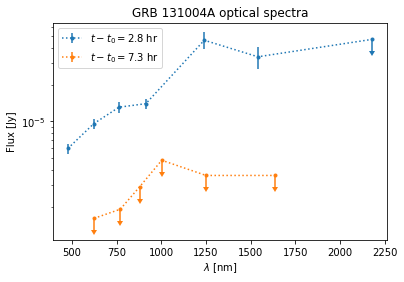

In [51]:
case = "131004A"
for time in [10080,26280]:#[55440,57903,323218]:
    data = results[(results["GRB"]==case) & (results["t_o"]==time)]
    lolims = [np.isinf(f.plus) for f in data["F_o"]]
    pos = [f.value*0.2 if np.isinf(f.plus) else f.plus for f in data["F_o"]]
    uplims = [np.isinf(f.minus) for f in data["F_o"]]
    neg = [f.value*0.2 if np.isinf(f.minus) else f.minus for f in data["F_o"]]
    val = [f.value for f in data["F_o"]]
    lam = 1e9*3e8/data["nu_o"]
    plt.errorbar(lam,val,yerr=(neg,pos),uplims=uplims,marker=".",linestyle=":",capthick=0,label=f"$t-t_0={time/3600:.1f}$ hr")
plt.legend()
plt.yscale("log")
plt.ylabel("Flux [Jy]")
plt.xlabel("$\lambda$ [nm]")
plt.title(f"GRB {case} optical spectra")
plt.savefig(f"./products/{case}_optspec.png",dpi=300,bbox_inches="tight")

## Illustrative example plot

In [54]:
pd.set_option('display.max_rows', 300)
c1 = [np.abs(B.value-0.5)<0.1 and all(np.isfinite(B.items())) for B in results[B_ox_name]]
c2 = [B.plus != B.minus for B in results["B_x"]]
truths = [c1[i] and c2[i] for i in range(len(results))]
results[truths]

GRB         t_o       dt%          nu_o  \
89    211023B     522.000  0.111783  8.514533e+14   
466   180618A     423.000  0.176039  8.514533e+14   
467   180618A     423.000  0.156016  8.514533e+14   
468   180618A     423.000  0.134894  8.514533e+14   
469   180618A     423.000  0.079489  8.514533e+14   
470   180618A     423.000  0.016343  8.514533e+14   
471   180618A     423.000  0.035403  8.514533e+14   
472   180618A     423.000  0.080343  8.514533e+14   
473   180618A     423.000  0.132041  8.514533e+14   
474   180618A     423.000  0.180374  8.514533e+14   
475   180618A     815.000  0.114644  7.715315e+14   
479   180618A     864.000  0.181660  6.897727e+14   
488   180618A    1001.000  0.189414  1.437350e+15   
490   180618A    1001.000  0.048888  1.437350e+15   
493   180618A    1074.000  0.020474  1.116903e+15   
599   180418A    3549.065  0.116439  1.334915e+15   
600   180418A    3549.065  0.066062  1.334915e+15   
601   180418A    3549.065  0.013341  1.334915e+15   
602   180418A    3549.065  0.034909  1.334915e+15   
603   180418A    3549.065  0.080625  1.334915e+15   
604   180418A    3549.065  0.130088  1.334915e+15   
605   180418A    3549.065  0.174810  1.334915e+15   
636   180418A    3754.115  0.180942  1.116903e+15   
637   180418A    3754.115  0.127654  1.116903e+15   
638   180418A    3754.115  0.071888  1.116903e+15   
639   180418A    3754.115  0.020850  1.116903e+15   
640   180418A    3754.115  0.027507  1.116903e+15   
641   180418A    3754.115  0.079828  1.116903e+15   
642   180418A    3754.115  0.127134  1.116903e+15   
643   180418A    3754.115  0.161466  1.116903e+15   
692   180418A    3958.720  0.189113  8.514533e+14   
694   180418A    3958.720  0.076487  8.514533e+14   
695   180418A    3958.720  0.025495  8.514533e+14   
697   180418A    3958.720  0.079562  8.514533e+14   
740   180418A    4370.020  0.188331  7.715315e+14   
741   180418A    4370.020  0.132042  7.715315e+14   
870   180418A  242784.000  0.017526  4.800781e+14   
1783  170728A     144.500  0.056595  7.715315e+14   
1784  170728A     144.500  0.142789  7.715315e+14   
1815  161004A     422.000  0.183353  8.514533e+14   
1825  161004A    6031.584  0.180378  4.673887e+14   
1826  161004A    6031.584  0.113015  4.673887e+14   
1917  160525B     163.000  0.170429  7.715315e+14   
2099  150424A    3490.500  0.194756  1.116903e+15   
2114  150424A    5269.000  0.111955  1.334915e+15   
2121  150424A    5269.000  0.105462  1.334915e+15   
2122  150424A    5269.000  0.166023  1.334915e+15   
2134  150424A    5371.000  0.166412  7.715315e+14   
2135  150424A    5371.000  0.133481  7.715315e+14   
2136  150424A    5371.000  0.101210  7.715315e+14   
2137  150424A    5371.000  0.068988  7.715315e+14   
2138  150424A    5371.000  0.036178  7.715315e+14   
2139  150424A    5371.000  0.003334  7.715315e+14   
2140  150424A    5371.000  0.022587  7.715315e+14   
2141  150424A    5371.000  0.049627  7.715315e+14   
2142  150424A    5371.000  0.088145  7.715315e+14   
2143  150424A    5371.000  0.149878  7.715315e+14   
2144  150424A    5371.000  0.187403  7.715315e+14   
2145  150424A    5604.000  0.182652  6.369361e+14   
2152  150424A    5604.000  0.048588  6.369361e+14   
2155  150424A    5616.000  0.185185  4.451341e+14   
2156  150424A    5616.000  0.151442  4.451341e+14   
2157  150424A    5616.000  0.117750  4.451341e+14   
2160  150424A    5616.000  0.021998  4.451341e+14   
2162  150424A    5616.000  0.046550  4.451341e+14   
2163  150424A    5616.000  0.111100  4.451341e+14   
2182  150424A    6396.000  0.194809  8.514533e+14   
2183  150424A    6396.000  0.163942  8.514533e+14   
2184  150424A    6396.000  0.131742  8.514533e+14   
2185  150424A    6396.000  0.085873  8.514533e+14   
2186  150424A    6396.000  0.012358  8.514533e+14   
2188  150424A    8481.000  0.155265  7.715315e+14   
2191  150424A   10563.000  0.052108  7.715315e+14   
2198  150424A   11320.000  0.106250  1.437350e+15   
2199  150424A   11320.000  0.069580

GRB                                                     180618A
t_o                                                       864.0
dt%                                                     0.18166
nu_o                                        689772696002300.875
F_o               0.0001503708480081596 ± 2.215946707484555e-05
nu_x          4.1880632448032506e+17 (+1.9991731172900093e+1...
F_x              3.6776658750166513e-06 ± 8.837871843211215e-07
B_ox          0.5790202965382417 (+0.08653698701715155, -0.4...
α                                                           1.0
B_ox_w_err    0.5790202965382417 (+0.11288843802922667, -0.4...
B_x                                         1.22 (+0.25, -0.23)
Jak_dark                                                  False
vdH_dark                                                  False
Year                                                       2018
Name: 479, dtype: object

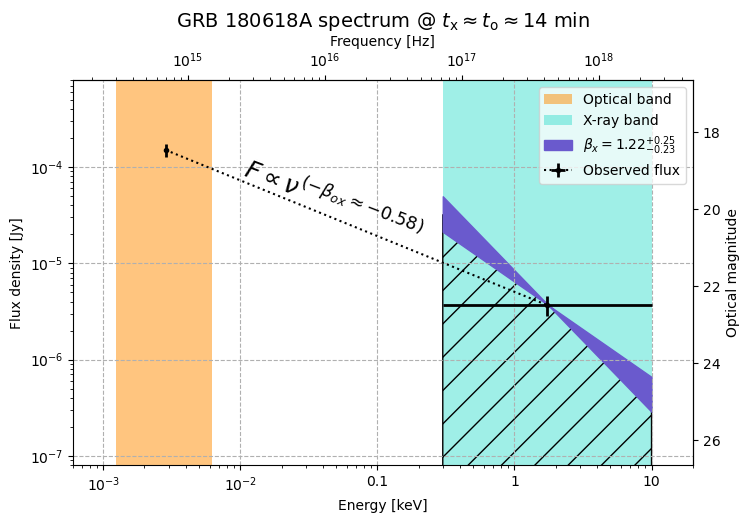

In [58]:
idx = 479
display(results.loc[idx,])
E_range = np.logspace(np.log10(0.3),np.log10(10),100)
grb = results.loc[idx,"GRB"]
beta = results.loc[idx,"B_x"]
E_o = results.loc[idx,"nu_o"]*6.62607015e-34/1.6021773e-16
E_x = results.loc[idx,"nu_x"]*6.62607015e-34/1.6021773e-16
F_o = results.loc[idx,"F_o"]
F_x = results.loc[idx,"F_x"]
t_o = results.loc[idx,"t_o"]
spectrum = E_range**-beta.value
scale = F_x.value/spectrum[len(spectrum)//2]
spectrum = scale * spectrum
spec1 = E_range**-beta.maximum
scale1 = F_x.value/spec1[len(spec1)//2]
spec1 = scale1 * spec1
spec2 = E_range**-beta.minimum
scale2 = F_x.value/spec2[len(spec2)//2]
spec2 = scale2 * spec2

fig,ax = plt.subplots(figsize=(8,5))

ax.fill_between([0.006199235,0.001239847],[1,1],alpha=0.5,fc="darkorange",label="Optical band")
ax.fill_between([0.3,10],[1,1],alpha=0.5,fc="turquoise",label="X-ray band")
ax.errorbar([E_o,E_x.value],[F_o.value,F_x.value],xerr=[(0,E_x.minus),(0,E_x.plus)],
             yerr=[(F_o.minus,F_x.minus),(F_o.plus,F_x.plus)],
             uplims=~np.isfinite((F_o.minus,F_x.minus)),capsize=0,elinewidth=2,marker=".",linestyle=":",color="k",label="Observed flux")
ax.fill_between(E_range,spectrum,fc="none",ec="k",hatch="/")
ax.fill_between(E_range,spec1,spec2,color="slateblue",label="$\\beta_x=%.2f_{-%.2f}^{+%.2f}$" %(beta.value,beta.minus,beta.plus))
ax.text(1e-2,1.6e-5,r"$F\propto\nu^{(-\beta_{ox}\approx\mathrm{-%.2f})}$" % results.loc[idx,B_ox_name].value,
         size=18,rotation=-21)

ax.legend(framealpha=0.75, loc="upper right")
ax.grid(linestyle="--")
ax.set_xlim(6e-4,20)
ax.set_ylim(8e-8,8e-4)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xticks([0.001,0.01,0.1,1,10])
ax.set_xticklabels(["$10^{-3}$","$10^{-2}$",0.1,1,10])
# ax.set_xticklabels(["$10^{-3}$","$10^{-2}$",0.3,10])
ax_top = ax.secondary_xaxis("top",functions=((lambda keV:keV*Hz_per_keV),(lambda Hz:Hz/Hz_per_keV)))
ax_top.set_xlabel("Frequency [Hz]")
ax_right = ax.secondary_yaxis("right",functions=((lambda Jy:-2.5*np.log10(Jy/3631)),(lambda m:3631*10**(-m/2.5))))
ax_right.set_ylabel("Optical magnitude")
ax_right.set_yticks(range(18,27,2))
ax_right.set_yticklabels(["18","20","22","24","26"])
# ax_right.set_yscale("linear")
# ax_right.invert_yaxis()

ax.set_title(r"GRB {} spectrum".format(grb)+r" @ $t_\mathrm{x}\approx t_\mathrm{o}\approx %.0f$ min"%round(t_o/60),size=14)
ax.set_xlabel("Energy [keV]")
ax.set_ylabel("Flux density [Jy]")
fig.savefig(f"./products/{grb}_spectrum.png",bbox_inches="tight",dpi=300)

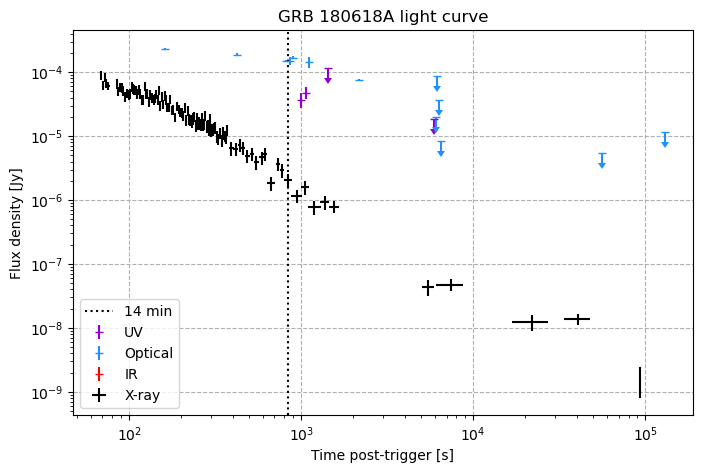

GRB     t_o       dt%  \
455  180618A   161.0  0.001487   
470  180618A   423.0  0.016343   
477  180618A   815.0  0.031596   
481  180618A   864.0  0.026627   
486  180618A   897.5  0.046156   
490  180618A  1001.0  0.048888   
493  180618A  1074.0  0.020474   
496  180618A  1112.0  0.056580   
499  180618A  1437.5  0.050929   
501  180618A  5882.5  0.071921   
502  180618A  6087.5  0.109277   
504  180618A  6190.0  0.127955   
506  180618A  6292.5  0.146632   
509  180618A  6497.5  0.124063   

                                            B_ox_w_err                  B_x  \
455  0.2701817734707163 (+0.04474859606087953, -0.2...  1.22 (+0.25, -0.23)   
470  0.5462199361034078 (+0.0818627937857624, -0.42...  1.22 (+0.25, -0.23)   
477  0.677317056166536 (+0.09773780698132033, -0.51...  1.22 (+0.25, -0.23)   
481  0.6674828969336349 (+0.09729216604542491, -0.4...  1.22 (+0.25, -0.23)   
486  0.800724408534892 (+0.11536874054817413, -0.61...  1.22 (+0.25, -0.23)   
490  0.5563424102797698 (+0.10409478164988357, -0.4...  1.22 (+0.25, -0.23)   
493  0.5759094251223985 (+0.09770079103414002, -0.4...  1.22 (+0.25, -0.23)   
496  0.6804661264558614 (+0.10004264407911767, -0.4...  1.22 (+0.25, -0.23)   
499    0.8398757950940956 (+0.12927202054024545, -inf)  1.22 (+0.25, -0.23)   
501    1.0199452356852825 (+0.15271008584954765, -inf)  1.22 (+0.25, -0.23)   
502    0.9870282975728539 (+0.14609675880156883, -inf)  1.22 (+0.25, -0.23)   
504     1.1470094712914323 (+0.1579203445903674, -inf)  1.22 (+0.25, -0.23)   
506    1.0483195418809161 (+0.15386565599251006, -inf)  1.22 (+0.25, -0.23)   
509    0.8189779366377461 (+0.12361144056492365, -inf)  1.22 (+0.25, -0.23)   

       α Jak_dark vdH_dark  
455  1.0     True     True  
470  1.0    False    False  
477  1.0    False    False  
481  1.0    False    False  
486  1.0    False    False  
490  1.0    False    False  
493  1.0    False    False  
496  1.0    False    False  
499  1.0    False    False  
501  1.0    False    False  
502  1.0    False    False  
504  1.0    False    False  
506  1.0    False    False  
509  1.0    False    False

In [59]:
fig,ax = plt.subplots(figsize=(8,5))

subset = all_optical.loc[(all_optical["GRB"]==grb)].copy()
dark_points = close_times.loc[(close_times["GRB"]==grb) & (close_times["vdH_dark"]|close_times["Jak_dark"])]

subset.loc[:,"band"] = ["UV" if wavelength<3000 else "IR" if wavelength>8000 else None if pd.isna(wavelength) else "Optical" for wavelength in subset["λ_eff"]]
bands = {"UV":["darkviolet","$\lambda<3000$ Å"],"Optical":["dodgerblue","$\lambda<3000$ Å"],"IR":"red"}
for band,info in bands.items():
    subsubset = subset[subset["band"]==band]
    neg_err = [0.3*flux.value if np.isinf(flux.minus) else flux.minus for flux in subsubset["Flux (Jy)"]]
    pos_err = [0.3*flux.value if np.isinf(flux.plus) else flux.plus for flux in subsubset["Flux (Jy)"]]
    ax.errorbar(subsubset["Time (s)"],[flux.value for flux in subsubset["Flux (Jy)"]],
                marker="_",linestyle="",color=info[0],label=f"{band}",yerr=np.array((neg_err,pos_err)),
                uplims=[np.isinf(point.minus) for point in subsubset["Flux (Jy)"]],
                lolims=[np.isinf(point.plus) for point in subsubset["Flux (Jy)"]],capthick=0)

subset = xrt_data.loc[xrt_data["GRB"]==grb]
neg_err = [0.4*flux.value if np.isinf(flux.minus) else flux.minus for flux in subset["SpecFlux"]]
pos_err = [0.4*flux.value if np.isinf(flux.plus) else flux.plus for flux in subset["SpecFlux"]]
ax.errorbar(subset.Time,[flux.value for flux in subset.SpecFlux],
            xerr=np.array(subset.Tneg,subset.Tpos).T,yerr=np.array((neg_err,pos_err)),
            uplims=[np.isinf(point.minus) for point in subset["SpecFlux"]],
            lolims=[np.isinf(point.plus) for point in subset["SpecFlux"]],
            linestyle="",capthick=0,color="k",label="X-ray")

ax.axvline(14*60,linestyle=":",color="k",label="14 min")
ax.set(xscale="log",yscale="log",xlabel="Time post-trigger [s]",ylabel="Flux density [Jy]")
tmin,tmax = ax.get_xlim()
ax.legend()
ax.grid(linestyle="--")
ax.set_title(f"GRB {grb} light curve")

fig.savefig(f"./products/{grb}_LC.png",dpi=300,transparent=False,facecolor="white",bbox_inches="tight")
plt.show()
display(close_times.loc[close_times["GRB"]==grb,["GRB","t_o","dt%",B_ox_name,"B_x","α","Jak_dark","vdH_dark"]])